# SAGE growth words
In which we find growth words based on SAGE scores.

In [48]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from data_processing.data_handler import get_default_vocab
from py_sage import sage
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Load data

In [276]:
tf_2015_2016 = pd.read_csv('../../data/frequency/2015_2016_tf_norm.tsv', sep='\t', index_col=0)
tf_2015_2016_raw = pd.read_csv('../../data/frequency/2015_2016_tf.tsv', sep='\t', index_col=0)
vocab = get_default_vocab()
tf_2015_2016 = tf_2015_2016.loc[vocab]
tf_2015_2016_raw = tf_2015_2016_raw.loc[vocab]
comment_counts_2015_2016 = pd.read_csv('../../data/frequency/2015_2016_comment_totals.tsv', sep='\t', index_col=0)

In [30]:
# smooth norm tf
tf_smooth_2015_2016 = tf_2015_2016[tf_2015_2016 > 0.].min().min()
tf_smooth_2015_2016 = tf_2015_2016 + tf_smooth_2015_2016

In [288]:
def get_etas(tf, tf_raw):
    vocab = tf.index
    k_lower = 1
    k_upper = int(tf.shape[1] / 2) + 1
    k_range = range(k_lower, k_upper)
    all_etas = {}
    for k in k_range:
        # use early as base rate against which to compare late
        tf_early = pd.np.array(pd.np.log10(tf.ix[:, 0:k].mean(axis=1)))
        tf_late = tf_raw.ix[:, -k:].mean(axis=1)
#         tf_late = pd.np.array(pd.np.log10(tf.ix[:, -k:].mean(axis=1)))
        etas = sage.estimate(tf_late, tf_early)
        etas = pd.Series(etas, index=vocab)
        all_etas[k] = etas
    all_etas = pd.DataFrame(all_etas)
    return all_etas

In [299]:
all_etas_2015_2016 = get_etas(tf_smooth_2015_2016, tf_2015_2016_raw)
print(all_etas_2015_2016.head())

             1         2         3         4         5         6
just  5.364437  5.366538  5.341879  5.291928  5.277625  5.290666
like  5.331427  5.333730  5.308930  5.261007  5.247819  5.260746
can   5.199863  5.199734  5.177435  5.131328  5.120345  5.131192
get   5.114976  5.121287  5.098584  5.055127  5.041841  5.053038
one   5.098508  5.101679  5.079610  5.037761  5.027987  5.041245


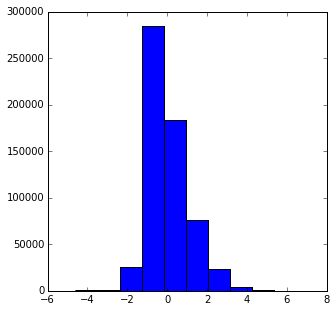

In [300]:
plt.figure(figsize=(5,5))
plt.hist(all_etas_2015_2016.values.flatten())
plt.show()

In [301]:
pd.set_option('display.max_rows', 1000)
k_range = sorted(all_etas_2015_2016.columns)
for k in k_range:
    all_etas_k = all_etas_2015_2016[k].sort_values(inplace=False, ascending=False)
    print(len(all_etas_k[all_etas_k > 0.]))
    print(len(all_etas_k[all_etas_k < 0.]))
    print(all_etas_k)

42267
57733
just               5.364437
like               5.331427
trump              5.319534
stellaris          5.220207
can                5.199863
removed            5.176193
roadhog            5.136788
get                5.114976
one                5.098508
people             5.038827
will               5.016538
think              4.986212
really             4.887975
time               4.883939
good               4.877170
undertale          4.846268
know               4.834331
even               4.817979
also               4.796912
much               4.762631
now                4.739123
see                4.715135
make               4.709319
well               4.696811
want               4.686039
way                4.676586
still              4.673831
go                 4.670462
game               4.650773
going              4.640387
right              4.593930
got                4.588408
something          4.564389
hillary            4.563607
need               4.561642
deleted 

Most of the positive eta values seem more common (e.g., `better`). How do we filter for the interesting words?

In [292]:
test_growth_words = ['af', 'cringy', 'doggo', 'cummies', 'lmao', 'rn', 'tbh', 
                     'kys', 'cuck', 'memery', 'shitpost', 'yas', 'ngl',
                     'waddup', 'rando', 'clickbaity', 'fuckery', 'lit',
                     'edgy', 'triggered']
print(all_etas_2015_2016.loc[test_growth_words])

                   1         2         3         4         5         6
af          2.578509  2.534115  2.461331  2.384758  2.340297  2.318854
cringy      1.291556  1.278504  1.223354  1.136523  1.091879  1.079116
doggo       2.887752  2.209657  1.770813  1.365272  1.124035  0.891023
cummies     2.140555  1.762080  1.273060  1.031721  1.121556  0.896463
lmao        3.038280  2.987678  2.921639  2.856828  2.821960  2.809096
rn          1.919096  1.874778  1.795151  1.720632  1.667609  1.642939
tbh         3.024986  3.002054  2.938798  2.867722  2.824968  2.811020
kys         1.632433  1.723116  1.554083  1.331128  1.148441  1.015971
cuck        3.418954  3.234066  3.068831  2.861631  2.655961  2.519354
memery      0.067232 -0.075972 -0.169058 -0.323866 -0.430791 -0.492798
shitpost    2.310961  2.537759  2.372274  2.238499  2.165153  2.136925
yas         0.869566  0.868145  0.804986  0.741165  0.657058  0.661367
ngl         0.517769  0.470462  0.367584  0.275463  0.246872  0.207350
waddup

In [332]:
# generalize to all growth words
import os, re
def get_all_growth_words(data_dir='../../data/frequency/growth_words/'):
    """
    Generate set of all the growth words
    we already know about.
    """
    growth_word_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) 
                         if re.findall('2015_2016_growth_word.*\.csv', f)]
    growth_word_data = [pd.read_csv(f, sep=',', index_col=None) for f in growth_word_files]
    growth_words = set(reduce(lambda x,y: x+y, 
                              [list(reduce(lambda x,y: x+y, [ws.split('/') for d in growth_word_data
                                                             for ws in d['words']]))]
                             ))
    return growth_words

In [333]:
known_growth_words = get_all_growth_words()

In [334]:
print(', '.join(sorted(known_growth_words)))

abbreviations, abductor, abetted, abject, abjectly, ablation, aboit, absolute, abstracted, abysmally, abyss, abyssal, acceptances, accesories, accessibility, accession, accolades, accomplish, accomplished, accomplishing, accosting, accountability, accountable, accountants, accounting, acct, accumulating, accumulator, accuracy, accurately, accusation, accusations, accused, accuses, accusing, achievable, achieve, achiever, achieving, acidosis, acks, acquaint, acquiesce, acquiescence, acquiescing, action, actuary, acupuncture, adagio, adaptability, adaptations, adblocker, additional, adhesion, adhesions, adhesive, adjusted, adjustment, adlib, adlibs, administration, administrations, administratively, admires, admonished, adoptable, adopter, adored, adressed, adulting, advantageous, adventurism, adversary, adversely, advisers, advocated, advocating, af, afar, affairs, affiliated, affiliation, affiliations, affordable, aforementioned, aft, afterglow, aganist, ageist, agents, aggregate, agha

15446
15329
15160
15315
15292
14840


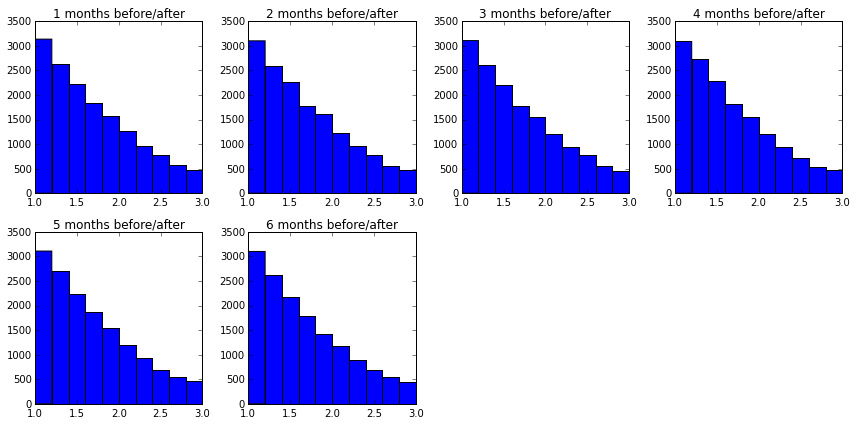

In [167]:
cols = 4
rows = int(len(k_range) / cols) + 1
size = 3
plt.figure(figsize=(cols * size, rows * size))
for i, k in enumerate(k_range):
    plt.subplot(rows, cols, i+1)
    all_etas_k = all_etas_2015_2016[k]
    upper = 3.
    lower = 1.
    all_etas_k_cutoff = all_etas_k[(all_etas_k < upper) & (all_etas_k >= lower)]
    plt.hist(all_etas_k_cutoff)
    plt.title('%d months before/after'%(k))
    print(len(all_etas_k_cutoff))
plt.tight_layout()
plt.show()

In [171]:
# middle first
k = 3
all_etas_k = all_etas_2015_2016[k]
upper = 3.
lower = 1.
all_etas_k_cutoff = all_etas_k[(all_etas_k >= lower) & (all_etas_k < upper)]

In [173]:
banned_words = pd.read_csv('../../data/frequency/growth_words/growth_words_banned.csv', index_col=None)
banned_words = set(banned_words['words'][0].split('/'))
all_etas_k_cutoff_words = sorted(set(all_etas_k_cutoff.index) - banned_words)
print(len(all_etas_k_cutoff_words))

13820


In [174]:
print(','.join(all_etas_k_cutoff_words))

aaa,aaand,aaron,ab,abandon,abandoned,abandoning,abandonthread,abc,abebooks,aber,abide,abilities,abnormal,aboard,abolish,abomination,abort,abortion,abortions,abraham,abroad,abs,absence,absent,absolute,absorb,absorbed,absorption,abstract,absurd,absurdly,abundance,abuse,abused,abuser,abusing,abusive,abysmal,abyss,abyssal,ac,aca,academia,academic,academics,academy,acc,accelerate,acceleration,accent,accents,accept,acceptable,acceptance,accepted,accepting,accepts,accessed,accessible,accessing,accessories,accessory,accident,accidental,accidentally,accidents,accommodate,accommodation,accompanied,accomplish,accomplished,accomplishment,accomplishments,accord,according,accordingly,accords,accountability,accountable,accountant,accounted,accounting,accounts,accumulate,accuracy,accurate,accurately,accusation,accusations,accuse,accused,accusing,accustomed,ace,achieve,achieved,achievement,achievements,achieving,acid,acknowledge,acknowledged,acknowledging,acl,acne,acoustic,acquire,acquired,acquiring,ac

In [214]:
# remove known growth words
all_etas_k_cutoff_words_known = set(known_growth_words) & set(all_etas_k_cutoff_words)
print(len(all_etas_k_cutoff_words_known))
all_etas_k_cutoff_words_unknown = set(all_etas_k_cutoff_words) - set(known_growth_words)
print(len(all_etas_k_cutoff_words_unknown))

1649
12171


In [215]:
# non-dictionary stuff first
english = {w.strip() for w in open('../../data/frequency/english_words.txt', 'r')}
all_etas_k_cutoff_words_non_english = list(set(all_etas_k_cutoff_words_unknown) - english)
print(', '.join(sorted(all_etas_k_cutoff_words_non_english)))

aaa, aaand, aaron, abandonthread, abebooks, aber, aca, acc, acl, activision, adblock, adc, adcs, adderall, addon, addons, adidas, admins, adrian, ae, afaik, afk, ag, agatha, aggro, aghs, ahh, ahhh, ahl, aint, airbnb, aka, ala, alani, aldo, aldous, aldritch, alex, ali, alibris, allingham, allsburg, alot, als, alts, ambra, ambrose, amc, amirite, amsp, amy, anakin, anankos, andy, anime, anor, anouilh, ao, aos, ap, apc, aphro, apologise, apps, aram, archdragon, arduino, arent, arma, artanis, arya, asimov, askreddit, askwomen, asriel, assad, asshat, assholes, aswell, athene, athleticism, atleast, atx, audi, auel, aug, autocorrect, aww, awww, ayy, ayyy, azerbaijan, azir, babymetal, backend, backstab, backstory, badass, badbadbad, bae, ballpark, balor, bam, barca, barnes, bart, basetao, bastardbowl, batshit, battlecry, bautista, bayern, baylor, bayo, bayonetta, bbc, bbq, bbs, bc, bdsm, behaviour, belive, bemelmans, benjen, berserker, beth, beverly, beyonce, bf, bg, bgh, bi, biblio, biden, bie

(k=3) Non-banned non-English growth words:

[aaand, abandonthread, addon, addons, afaik, afk, ahh, ahhh, aint, aka, ala, alot, alts, amirite, apologise, apps, arent, asshat, assholes, aswell, athleticism, atleast, autocorrect, aww, awww, ayy, ayyy, backend, backstab, backstory, badass, badbadbad, bae, ballpark, batshit, bc, behaviour, belive, bf, botting, brah, brb, breastfeeding, brits, bruh, bs, btw, burrito, butthole, butthurt, buyout, carb, carbs, cardio, cellphone, cig, circlejerk, cis, clickbiat, clunky, clusterfuck, commenter, commenters, config, congrats, cooldown, cooldowns, coolheaded, copypasta, cosplay, couldnt, crits, cutscene, cutscenes, dae, dammit, dat, dawg, daycare, dayz, deadlift, deadlifts, def, definately, derp, dev, devs, dickhead, didnt, diff, dipshit, dismissive, div, doin, dopamine, doublelift, douchebag, downside, downsides, downvote, downvoted, downvotes, downvoting, doxing, duh, dumbass, dumpster, dunno, eachother, ehh, ehhh, emailed, everyones, everytime, ew, eww, exclusives, exp, fanbase, fanboy, fanboys, fanfic, fap, faq, fav, fave, favourite, favourites, fest, fracking, freakin, friggin, ftfy, ftw, fucker, fuckers, fuckin, func, fuuuck, fyi, gameplay, gamers, gank, ganked, ganking, ganks, geez, gf, gimme, goddammit, godsent, goin, googled, googling, gooo, gotcha, grats, gtfo, gunna, hahah, hahaha, hahahah, hahahaha, hahahahaha, hashtag, hasnt, heh, hehe, hm, hmm, hmmm, homophobia, homophobic, horseshit, iirc, imho, imma, immersive, inbox, irl, islamist, islamists, kek, kickass, kk, laggy, laner, laning, laptops, lemme, lgbt, lil, login, lookin, looong, lul, lvl, mah, malware, matchups, maxed, med, meds, megathread, megathreads, meh, merch, messaged, mfw, mmm, modded, modding, modmail, moreso, motherfucker, motherfuckers, motherfucking, muh, naw, neckbeard, neighbour, neighbourhood, neighbours, neoliberal, nerf, nerfed, nerfing, nerfs, nevermind, newbie, newbies, nigga, ninja, ninjas, noob, noobs, noone, nooo, nsfw, nvm, nxt, ocd, ofcourse, ohh, ohhh, omfg, omg, ooo, oooh, organisation, organised, outsourcing, outta, overclock, overclocked, overclocking, pedophiles, perma, photoshopped, pic, pissy, playerbase, playlist, playlists, playstyle, playthroughs, plugin, plugins, plz, podcast, podcasts, poo, positivity, premade, preorder, preordered, prob, prolly, promo, promos, ramen, realised, recognise, reddiquette, redditor, redditors, rehab, rekt, remaster, remastered, repost, reposted, reposting, reposts, respawn, restroom, rewatch, rly, robotic, rofl, runtime, sayin, scammed, screenshot, scumbag, selfie, selfies, seperate, sheesh, shhh, shite, shithole, shitload, shitstorm, shittier, shittiest, shotgunners, shoulda, shoutout, shrooms, sidebar, sjw, sjws, smartphone, smartphones, sms, snarky, someones, soo, sooo, sorta, spammed, spamming, srs, sry, standalone, startup, stfu, strat, strats, strawman, subpar, subreddits, superhot, suprised, synth, synths, tanky, teamfight, teamfights, teamspeak, tech, teh, texted, texting, themed, thingy, tifu, timeframe, tldr, trans, transgender, transitioned, transitioning, uhh, uhhh, uhm, um, umm, ummm, undergrad, underwhelming, undomestic, uninstall, uninstalled, unranked, unsubscribe, untill, upfront, upvote, upvoted, upvotes, upvoting, username, usernames, vape, vaping, veggie, veggies, waaay, waifu, wat, wayyy, wc, website, websites, welp, werent, wew, whos, wifi, woah, wooo, workaround, workflow, workforce, workplace, worldview, wot, woulda, wtf, wut, yada, yah, yall, yeh, yesss, yo, yolo, youve, yum]

In [222]:
cutoff_words_non_english = ['aaand', 'abandonthread', 'addon', 'addons', 'afaik', 'afk', 'ahh', 'ahhh', 'aint', 'aka', 'ala', 'alot', 'alts', 'amirite', 'apologise', 'apps', 'arent', 'asshat', 'assholes', 'aswell', 'athleticism', 'atleast', 'autocorrect', 'aww', 'awww', 'ayy', 'ayyy', 'backend', 'backstab', 'backstory', 'badass', 'badbadbad', 'bae', 'ballpark', 'batshit', 'bc', 'behaviour', 'belive', 'bf', 'botting', 'brah', 'brb', 'breastfeeding', 'brits', 'bruh', 'bs', 'btw', 'burrito', 'butthole', 'butthurt', 'buyout', 'carb', 'carbs', 'cardio', 'cellphone', 'cig', 'circlejerk', 'cis', 'clickbait', 'clunky', 'clusterfuck', 'commenter', 'commenters', 'config', 'congrats', 'cooldown', 'cooldowns', 'coolheaded', 'copypasta', 'cosplay', 'couldnt', 'crits', 'cutscene', 'cutscenes', 'dae', 'dammit', 'dat', 'dawg', 'daycare', 'dayz', 'deadlift', 'deadlifts', 'def', 'definately', 'derp', 'dev', 'devs', 'dickhead', 'didnt', 'diff', 'dipshit', 'dismissive', 'div', 'doin', 'dopamine', 'doublelift', 'douchebag', 'downside', 'downsides', 'downvote', 'downvoted', 'downvotes', 'downvoting', 'doxing', 'duh', 'dumbass', 'dumpster', 'dunno', 'eachother', 'ehh', 'ehhh', 'emailed', 'everyones', 'everytime', 'ew', 'eww', 'exclusives', 'exp', 'fanbase', 'fanboy', 'fanboys', 'fanfic', 'fap', 'faq', 'fav', 'fave', 'favourite', 'favourites', 'fest', 'fracking', 'freakin', 'friggin', 'ftfy', 'ftw', 'fucker', 'fuckers', 'fuckin', 'func', 'fuuuck', 'fyi', 'gameplay', 'gamers', 'gank', 'ganked', 'ganking', 'ganks', 'geez', 'gf', 'gimme', 'goddammit', 'godsent', 'goin', 'googled', 'googling', 'gooo', 'gotcha', 'grats', 'gtfo', 'gunna', 'hahah', 'hahaha', 'hahahah', 'hahahaha', 'hahahahaha', 'hashtag', 'hasnt', 'heh', 'hehe', 'hm', 'hmm', 'hmmm', 'homophobia', 'homophobic', 'horseshit', 'iirc', 'imho', 'imma', 'immersive', 'inbox', 'irl', 'islamist', 'islamists', 'kek', 'kickass', 'kk', 'laggy', 'laner', 'laning', 'laptops', 'lemme', 'lgbt', 'lil', 'login', 'lookin', 'looong', 'lul', 'lvl', 'mah', 'malware', 'matchups', 'maxed', 'med', 'meds', 'megathread', 'megathreads', 'meh', 'merch', 'messaged', 'mfw', 'mmm', 'modded', 'modding', 'modmail', 'moreso', 'motherfucker', 'motherfuckers', 'motherfucking', 'muh', 'naw', 'neckbeard', 'neighbour', 'neighbourhood', 'neighbours', 'neoliberal', 'nerf', 'nerfed', 'nerfing', 'nerfs', 'nevermind', 'newbie', 'newbies', 'nigga', 'ninja', 'ninjas', 'noob', 'noobs', 'noone', 'nooo', 'nsfw', 'nvm', 'nxt', 'ocd', 'ofcourse', 'ohh', 'ohhh', 'omfg', 'omg', 'ooo', 'oooh', 'organisation', 'organised', 'outsourcing', 'outta', 'overclock', 'overclocked', 'overclocking', 'pedophiles', 'perma', 'photoshopped', 'pic', 'pissy', 'playerbase', 'playlist', 'playlists', 'playstyle', 'playthroughs', 'plugin', 'plugins', 'plz', 'podcast', 'podcasts', 'poo', 'positivity', 'premade', 'preorder', 'preordered', 'prob', 'prolly', 'promo', 'promos', 'ramen', 'realised', 'recognise', 'reddiquette', 'redditor', 'redditors', 'rehab', 'rekt', 'remaster', 'remastered', 'repost', 'reposted', 'reposting', 'reposts', 'respawn', 'restroom', 'rewatch', 'rly', 'robotic', 'rofl', 'runtime', 'sayin', 'scammed', 'screenshot', 'scumbag', 'selfie', 'selfies', 'seperate', 'sheesh', 'shhh', 'shite', 'shithole', 'shitload', 'shitstorm', 'shittier', 'shittiest', 'shotgunners', 'shoulda', 'shoutout', 'shrooms', 'sidebar', 'sjw', 'sjws', 'smartphone', 'smartphones', 'sms', 'snarky', 'someones', 'soo', 'sooo', 'sorta', 'spammed', 'spamming', 'srs', 'sry', 'standalone', 'startup', 'stfu', 'strat', 'strats', 'strawman', 'subpar', 'subreddits', 'superhot', 'suprised', 'synth', 'synths', 'tanky', 'teamfight', 'teamfights', 'teamspeak', 'tech', 'teh', 'texted', 'texting', 'themed', 'thingy', 'tifu', 'timeframe', 'tldr', 'trans', 'transgender', 'transitioned', 'transitioning', 'uhh', 'uhhh', 'uhm', 'um', 'umm', 'ummm', 'undergrad', 'underwhelming', 'undomestic', 'uninstall', 'uninstalled', 'unranked', 'unsubscribe', 'untill', 'upfront', 'upvote', 'upvoted', 'upvotes', 'upvoting', 'username', 'usernames', 'vape', 'vaping', 'veggie', 'veggies', 'waaay', 'waifu', 'wat', 'wayyy', 'wc', 'website', 'websites', 'welp', 'werent', 'wew', 'whos', 'wifi', 'woah', 'wooo', 'workaround', 'workflow', 'workforce', 'workplace', 'worldview', 'wot', 'woulda', 'wtf', 'wut', 'yada', 'yah', 'yall', 'yeh', 'yesss', 'yo', 'yolo', 'youve', 'yum']
cutoff_words_non_english += ['bbs', 'bdsm', 'bi', 'blog', 'blogs', 'booo', 'cg', 'choo', 'distro', 'dm', 'eg', 'flashbang', 'framerate', 'hai', 'ive', 'lel', 'necro', 'org', 'pb', 'pharma', 'pms', 'pos', 'pov', 'pr', 'prequel', 'prequels', 'procs', 'ps', 'qa', 'rez', 'rpg', 'rpgs', 'shopaholic', 'stam', 'std', 'tdee', 'tf', 'tha', 'thx', 'tvs', 'ty', 'ulti', 'ults', 'veg', 'vibe', 'wich', 'winrate', 'xd', 'xyz']
print(len(cutoff_words_non_english))

470


In [256]:
# update bad words
new_banned_words = (set(all_etas_k_cutoff_words_non_english) - set(cutoff_words_non_english))
banned_words = pd.read_csv('../../data/frequency/growth_words/growth_words_banned.csv', index_col=False)
banned_words['words'] = ['/'.join(sorted(set(banned_words['words'][0].split('/')) | new_banned_words))]
print(banned_words['words'])
banned_words.to_csv('../../data/frequency/growth_words/growth_words_banned.csv', index=None)

0    aa/aaa/aan/aaoa/aaron/aasimar/aayla/abbey/abbi...
Name: words, dtype: object


In [223]:
cutoff_words_all = all_etas_k_cutoff_words_known | set(cutoff_words_non_english)
print(len(cutoff_words_all))
print('/'.join(sorted(cutoff_words_all)))

2119
aaand/abandonthread/absolute/abyss/abyssal/accomplish/accomplished/accountability/accountable/accounting/accuracy/accurately/accusation/accusations/accused/accusing/achieve/achieving/additional/addon/addons/adjusted/adjustment/administration/advocated/advocating/af/afaik/affairs/affiliated/affiliation/affordable/afk/aforementioned/agents/aggregate/ahh/ahhh/aint/aka/ala/alienate/alienating/align/alignment/allegations/alleged/allegiance/allocate/allocated/allocation/ally/alot/altered/alts/ambassador/amber/amex/amirite/among/analysis/analytics/analyzed/anarchism/anarchist/anecdotal/anecdotes/annual/anotha/anti/antics/anxiety/anxious/apologise/appeals/appoint/appointed/appointments/apprentice/apps/archetype/archetypes/archives/arcs/arena/arent/arf/arrives/ascendancy/ash/assassinated/assaulted/assaulting/assaults/assembly/assessment/asshat/assholes/assign/assigned/astonishing/aswell/async/athleticism/atleast/atm/attacked/attackers/attacking/attacks/audience/audiences/audit/augment/aura

In [225]:
# update file
cutoff_out_file = '../../data/frequency/growth_words/2015_2016_SAGE_3.csv'
cutoff_words_all_df = pd.DataFrame({'category' : ['misc'], 'words' : ['/'.join(sorted(cutoff_words_all))]})
cutoff_words_all_df.to_csv(cutoff_out_file, index=None)

In [217]:
# now English stuff
all_etas_k_cutoff_words_english = list(set(all_etas_k_cutoff_words_unknown) & english)
print(len(all_etas_k_cutoff_words_english))
print(', '.join(sorted(all_etas_k_cutoff_words_english)))

10499
ab, abandon, abandoned, abandoning, abc, abide, abilities, abnormal, aboard, abolish, abomination, abort, abortion, abortions, abraham, abroad, abs, absence, absent, absorb, absorbed, absorption, abstract, absurd, absurdly, abundance, abuse, abused, abuser, abusing, abusive, abysmal, ac, academia, academic, academics, academy, accelerate, acceleration, accent, accents, accept, acceptable, acceptance, accepted, accepting, accepts, accessed, accessible, accessing, accessories, accessory, accident, accidental, accidentally, accidents, accommodate, accommodation, accompanied, accomplishment, accomplishments, accord, according, accordingly, accords, accountant, accounted, accounts, accumulate, accurate, accuse, accustomed, ace, achieved, achievement, achievements, acid, acknowledge, acknowledged, acknowledging, acne, acoustic, acquire, acquired, acquiring, acquisition, acronym, acted, acting, actions, activate, activated, activates, activating, activation, active, actively, activism, 

Non-common growth words:

[]

In [263]:
all_etas_k.loc['crappy']

2.1614253076749148

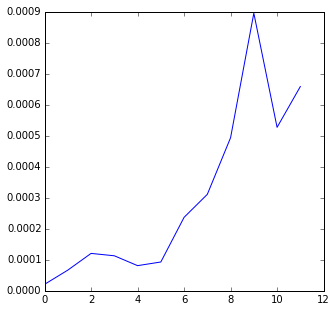

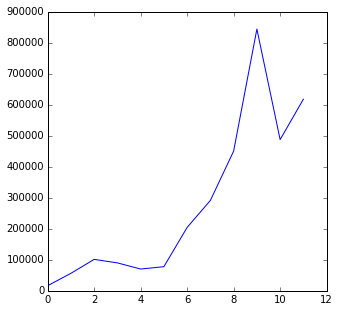

4.83493826883
6.94402893269e-05
0.000693898697697


In [270]:
test_word = 'trump'
X = range(tf_2015_2016.shape[1])
plt.figure(figsize=(5,5))
plt.plot(X, tf_2015_2016.loc[test_word])
plt.show()
plt.figure(figsize=(5,5))
plt.plot(X, tf_2015_2016_raw.loc[test_word])
plt.show()
print(all_etas_k.loc[test_word])
print(tf_2015_2016.ix[test_word, 0:3].mean())
print(tf_2015_2016.ix[test_word, -3:].mean())

## Plot example growth words

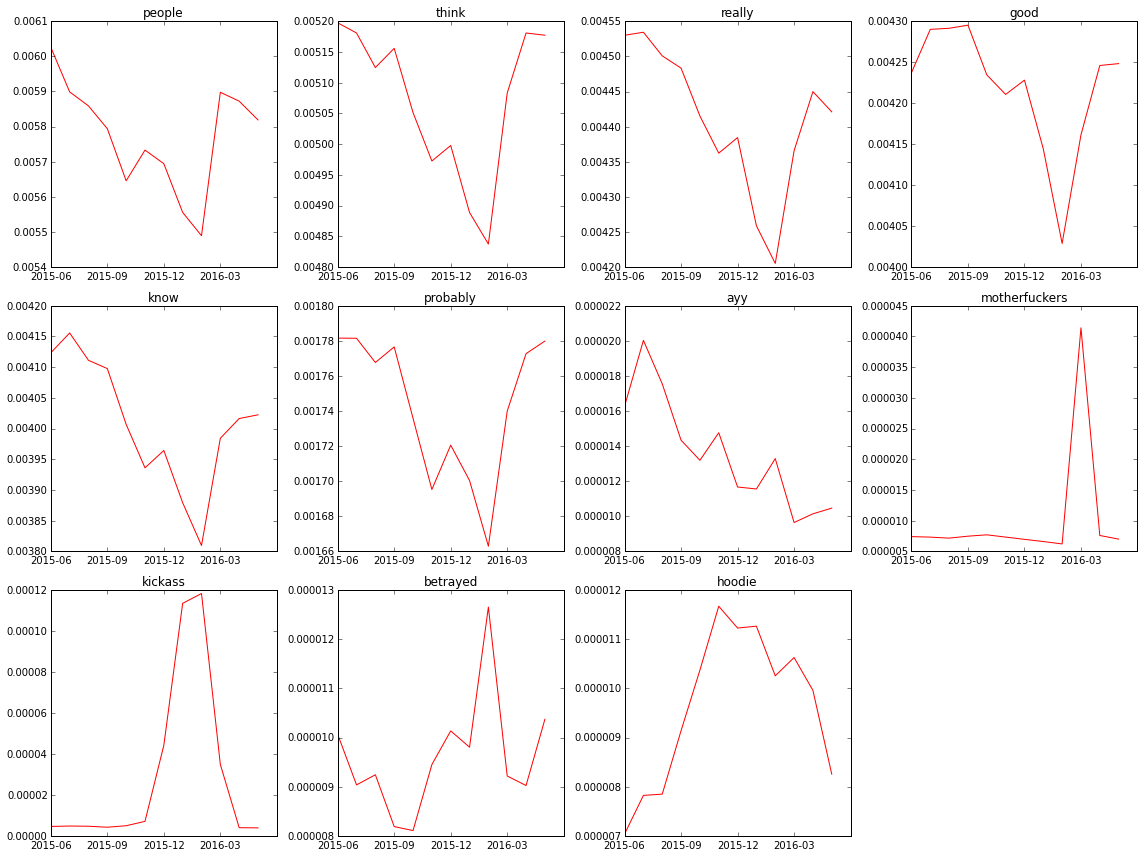

In [76]:
ws = ['people', 'think', 'really', 'good', 'know', 'probably', 'ayy', 'motherfuckers', 'kickass', 'betrayed', 'hoodie']
cols = 4
N = len(ws)
rows = int(N / cols) + 1
size = 4
plt.figure(figsize=(cols * size, rows * size))
x_pos = range(tf_2015_2016.shape[1])
x_labels = sorted(tf_2015_2016.columns)
x_ticks, x_labels = zip(*zip(x_pos, x_labels)[::3])
for i, w in enumerate(ws):
    plt.subplot(rows, cols, i+1)
    X = range(tf_2015_2016.shape[1])
    plt.plot(X, tf_2015_2016.loc[w], 'r-')
    plt.xticks(x_ticks, x_labels)
    plt.title(w)
plt.tight_layout()
plt.show()    

In [125]:
all_etas_2015_2016 = get_etas(tf_smooth_2015_2016)
all_etas_2015_2016 = pd.DataFrame(all_etas_2015_2016)
ws = ['af', 'ghosted', 'doggo', 'tbh', 'cuck']
print(all_etas_2015_2016.loc[ws])

                1         2         3         4         5         6
af       0.000149  0.000155  0.000158  0.000160  0.000163  0.000165
ghosted -0.000030 -0.000029 -0.000029 -0.000029 -0.000028 -0.000029
doggo   -0.000050 -0.000052 -0.000054 -0.000058 -0.000058 -0.000058
tbh      0.000270  0.000279  0.000284  0.000289  0.000293  0.000296
cuck     0.000029  0.000030  0.000031  0.000028  0.000027  0.000027


Surprising! Only `ghosted` and `doggo` have negative eta values even though all words grow significantly from 2015-2016.

## Compare with 2014-2016

In [39]:
tf_2014_2016 = pd.read_csv('../../data/frequency/2014_2016_tf_norm.tsv', sep='\t', index_col=0)
tf_2014_2016 = tf_2014_2016.loc[vocab]
tf_2014_2016.fillna(0, inplace=True)
tf_smooth_2014_2016 = tf_2014_2016[tf_2014_2016 > 0.].min().min()
tf_smooth_2014_2016 = tf_2014_2016 + tf_smooth_2014_2016
all_etas_2014_2016 = get_etas(tf_smooth_2014_2016)

In [45]:
k_range = sorted(all_etas_2014_2016.columns)
for k in k_range:
    all_etas_k = all_etas_2014_2016[k].sort_values(inplace=False, ascending=False)
    print(len(all_etas_k[all_etas_k > 0.]))
    print(all_etas_k)

27639
just                 0.002685
like                 0.002607
can                  0.002353
one                  0.002209
get                  0.002208
people               0.002103
will                 0.002012
think                0.001996
really               0.001884
time                 0.001832
know                 0.001830
good                 0.001819
much                 0.001691
even                 0.001689
also                 0.001684
now                  0.001632
see                  0.001621
make                 0.001621
well                 0.001618
want                 0.001601
go                   0.001579
way                  0.001560
still                0.001535
game                 0.001521
going                0.001511
something            0.001464
right                0.001457
got                  0.001437
say                  0.001404
need                 0.001401
first                0.001392
back                 0.001385
never                0.001375
pret

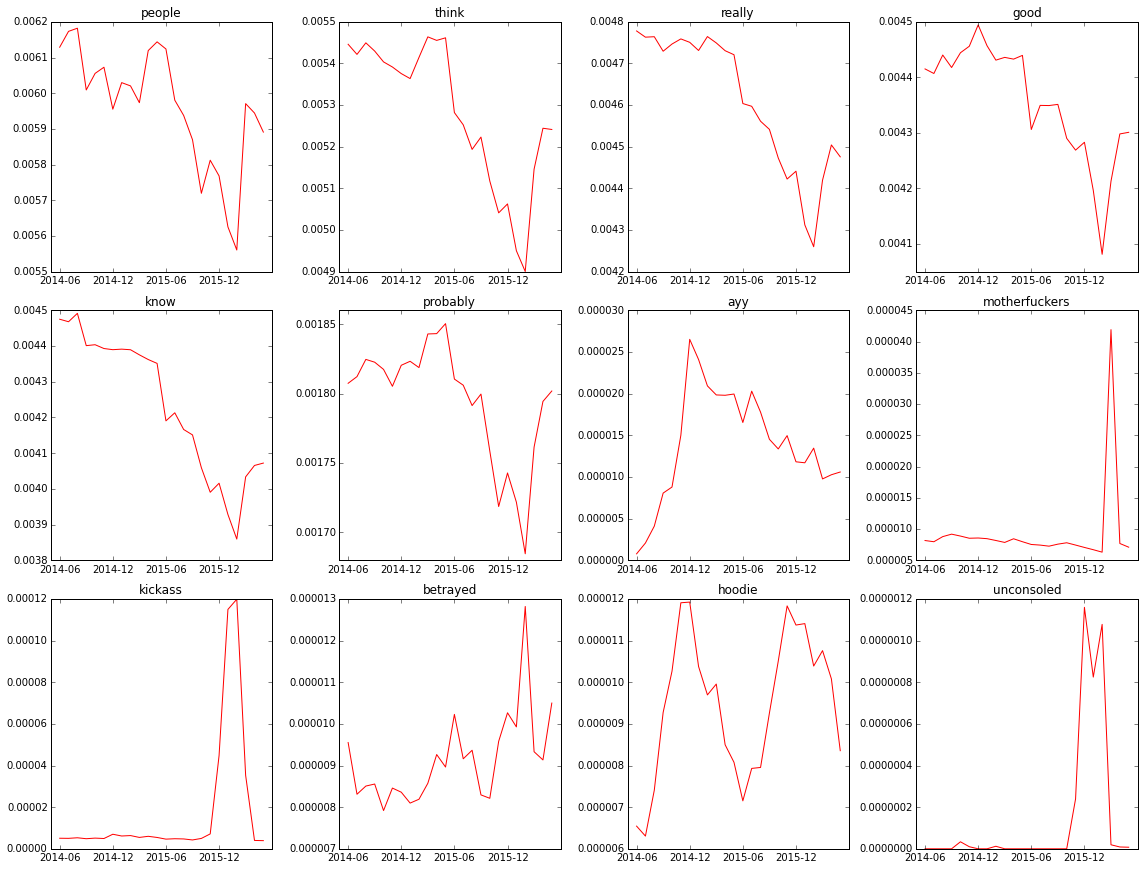

In [116]:
ws = ['people', 'think', 'really', 'good', 'know', 'probably', 
      'ayy', 'motherfuckers', 'kickass', 'betrayed', 'hoodie', 'unconsoled']
cols = 4
N = len(ws)
rows = int(N / cols) + 1
size = 4
plt.figure(figsize=(cols * size, rows * size))
n_ticks = 4
N_tf = tf_2014_2016.shape[1]
tick_ctr = N_tf / n_ticks
x_pos = range(1, N_tf+1)
x_labels = sorted(tf_2014_2016.columns)
x_ticks, x_labels = zip(*zip(x_pos, x_labels)[::tick_ctr])
for i, w in enumerate(ws):
    plt.subplot(rows, cols, i+1)
    X = range(tf_2014_2016.shape[1])
    plt.plot(x_pos, tf_2014_2016.loc[w], 'r-')
    plt.xticks(x_ticks, x_labels)
    plt.title(w)
plt.tight_layout()
plt.show()    

Interesting to note that most common words like "people" are more associated with early time periods. Does this mean that they're being replaced by specialized words?

In [86]:
from gensim.models import Word2Vec
struc_embeddings_2016_05 = Word2Vec.load_word2vec_format('../../data/embeddings/2016-05_wang2vec_100_5_embeddings', binary=True)

In [104]:
def plot_word_neighbors(w, neighbors, tf):
    cols = 4
    rows = int(len(neighbors) / cols) + 1
    size = 4
    plt.figure(figsize=(cols * size, rows * size))
    N = tf.shape[1]
    X = range(N)
    all_words = [w] + neighbors
    ymin = tf.ix[all_words, :].min().min()
    ymax = tf.ix[all_words, :].max().max() * 10
    n_ticks = 4
    tick_ctr = N / n_ticks
    x_pos = range(tf.shape[1])
    x_labels = sorted(tf.columns)
    x_ticks, x_labels = zip(*zip(x_pos, x_labels)[::tick_ctr])
    for i, n in enumerate(neighbors):
        plt.subplot(rows, cols, i+1)
        plt.plot(X, tf.loc[w], 'b-', label=w)
        plt.plot(X, tf.loc[n], 'r-.', label=n)
        plt.legend(loc='center left')
        plt.yscale('log')
        plt.ylim((ymin, ymax))
        plt.xticks(x_ticks, x_labels)
    plt.tight_layout()
    plt.show()

In [118]:
def plot_word_and_embedding_neighbor_tf(w, embeddings, tf, top_k=10):
    neighbor_sim_pairs = embeddings.most_similar(w, topn=top_k*2)
    neighbor_sim_pairs = [(n,s) for n,s in neighbor_sim_pairs if n in tf.index][:top_k]
    neighbors, neighbor_sims = zip(*neighbor_sim_pairs)
    neighbors = list(neighbors)
    print('%s has neighbors %s'%(d, ','.join(neighbors)))
    plot_word_neighbors(w, neighbors, tf)

2015-06 has neighbors folks,poeple,peopel,redditors,peole,idiots,ppl,dumbasses,individuals,dipshits


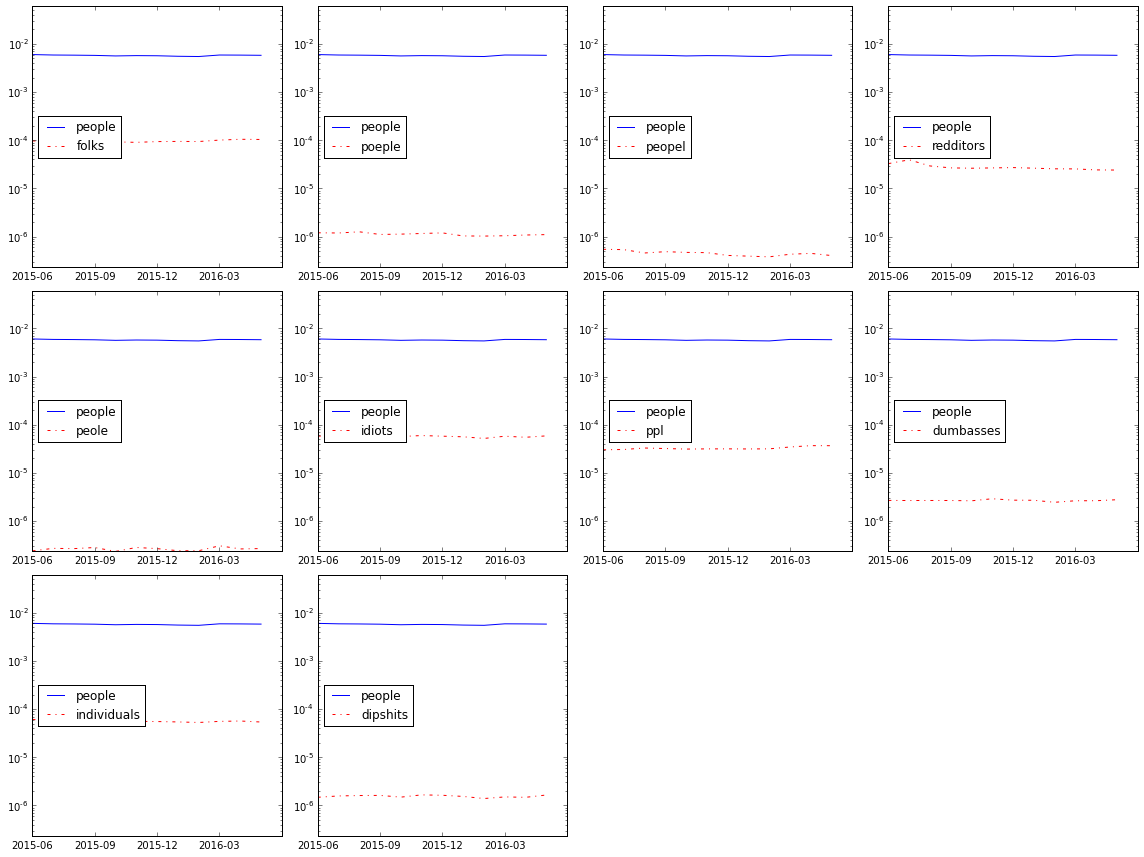

2015-07 has neighbors peole,poeple,folks,peope,peopel,pepole,peopl,redditors,ppl,redditers


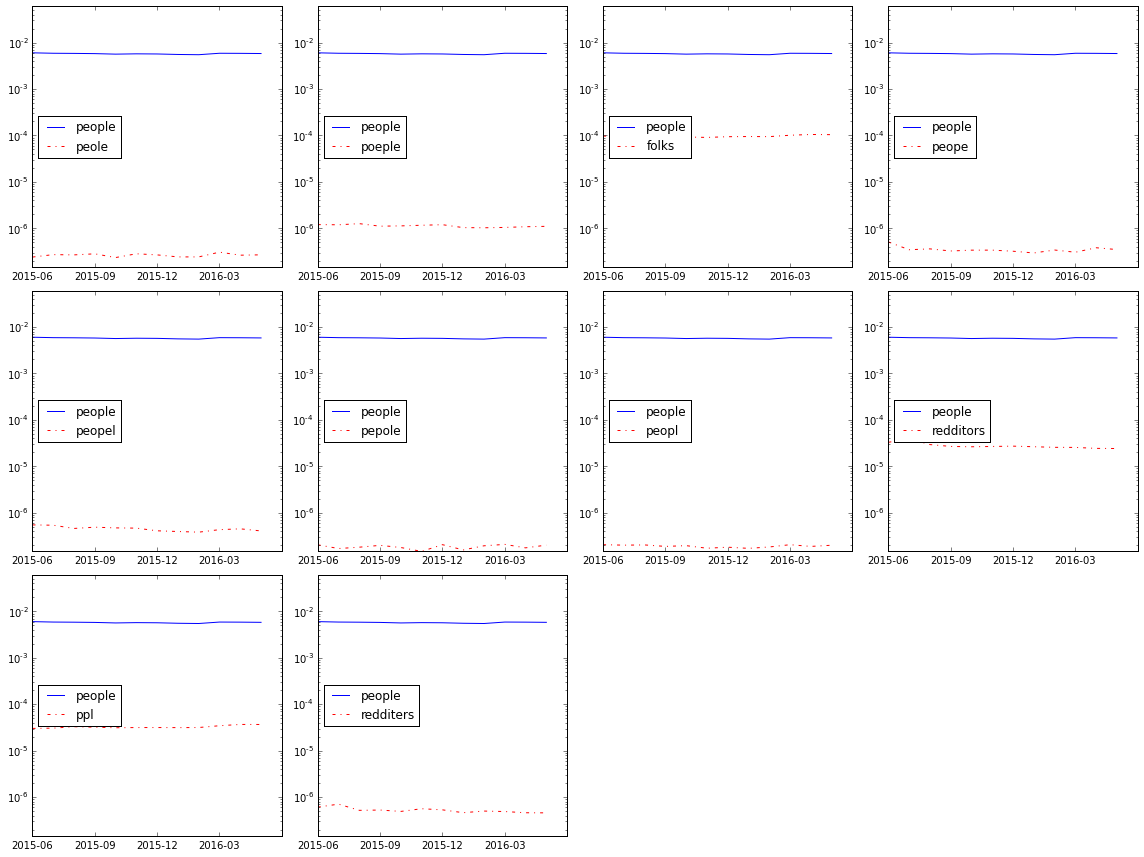

2015-08 has neighbors poeple,folks,peope,peole,peopel,redditors,ppl,prople,idiots,peopl


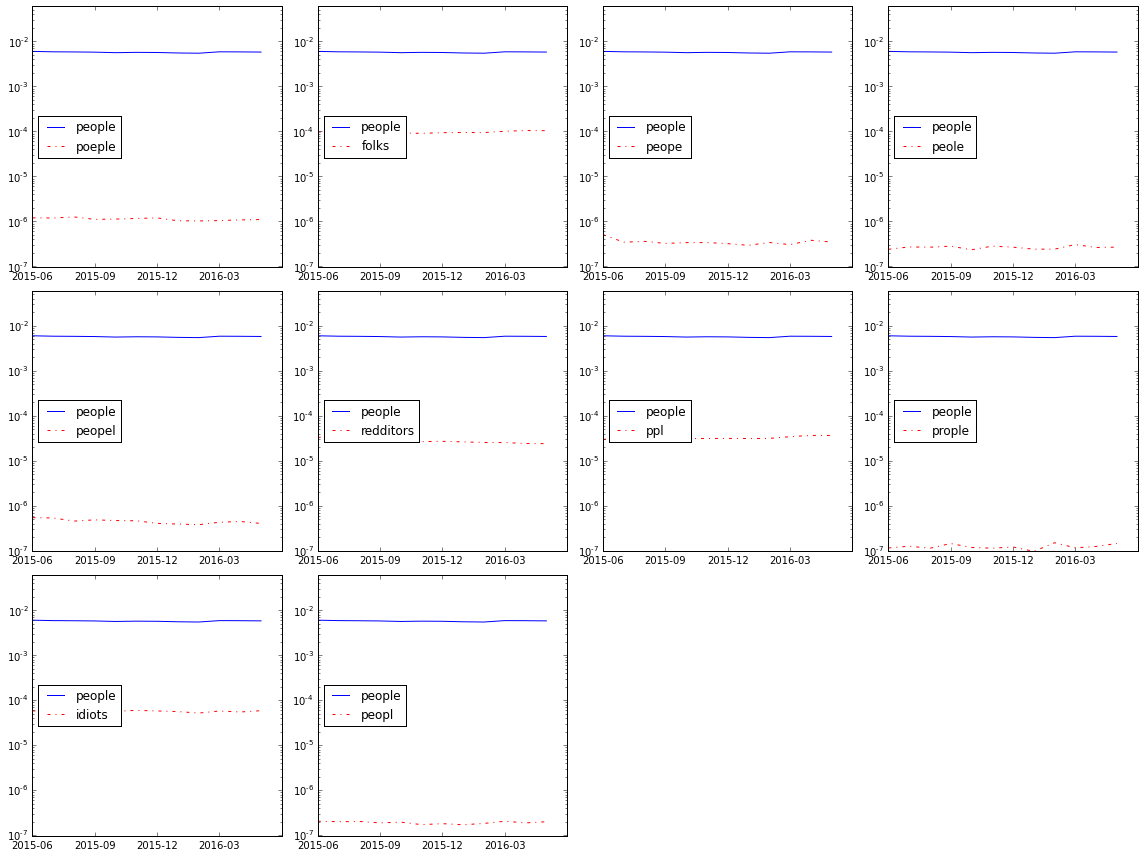

2015-09 has neighbors folks,poeple,peopel,peope,prople,redditors,peole,peopl,pepole,ppl


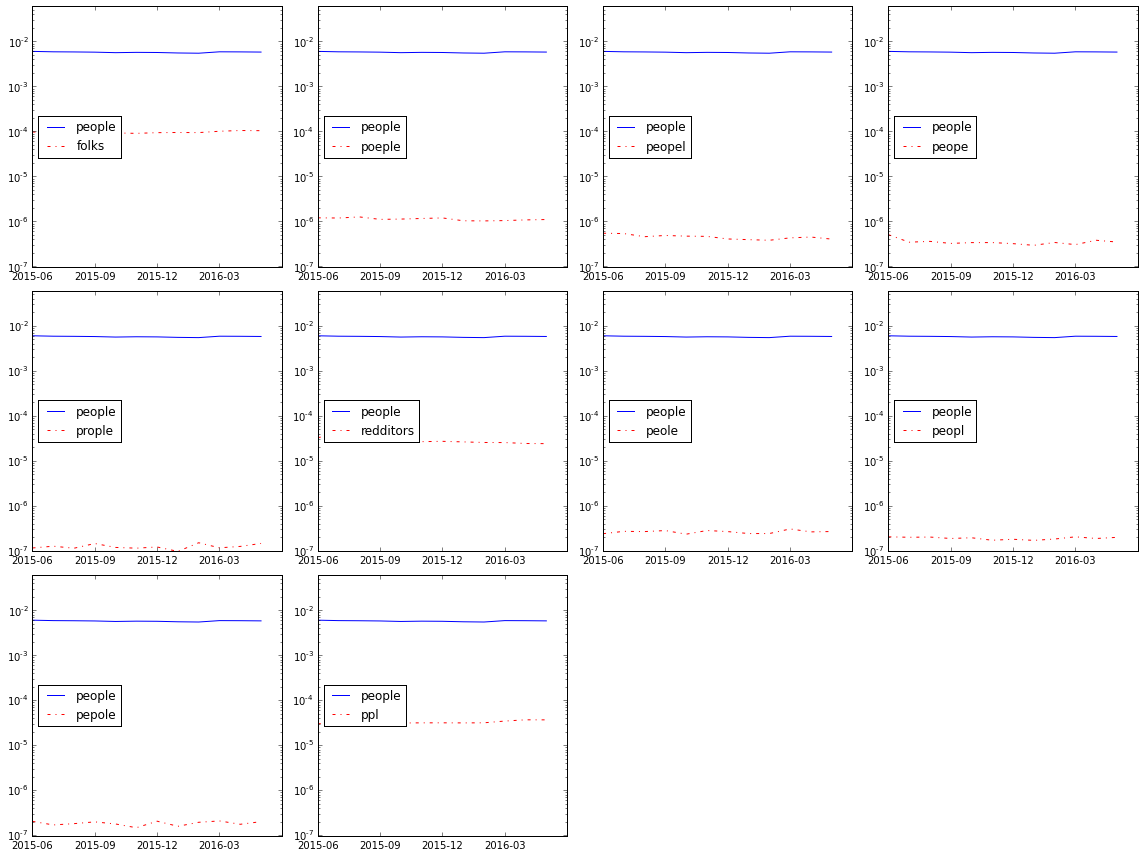

2015-10 has neighbors peope,peopel,folks,poeple,peole,redditors,pepole,ppl,redditers,dumbasses


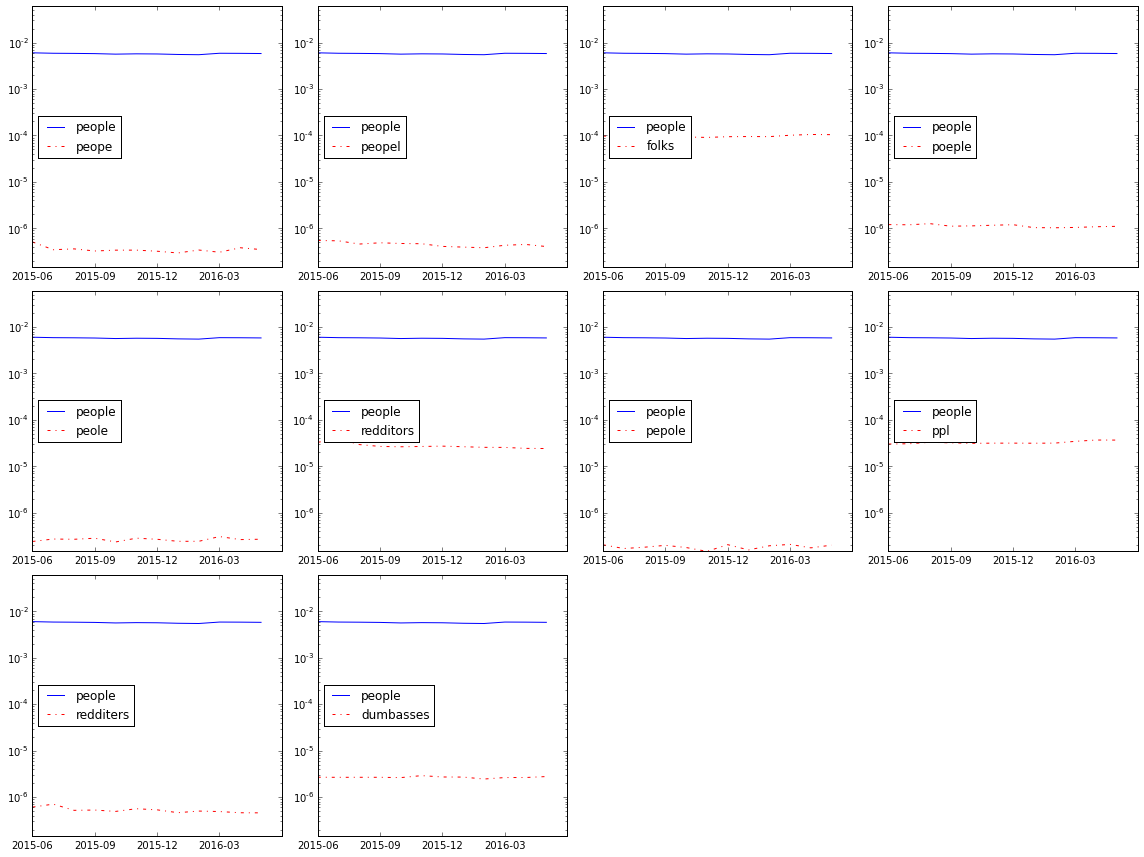

2015-11 has neighbors folks,peope,poeple,peopel,peole,redditors,prople,pepole,peopl,peple


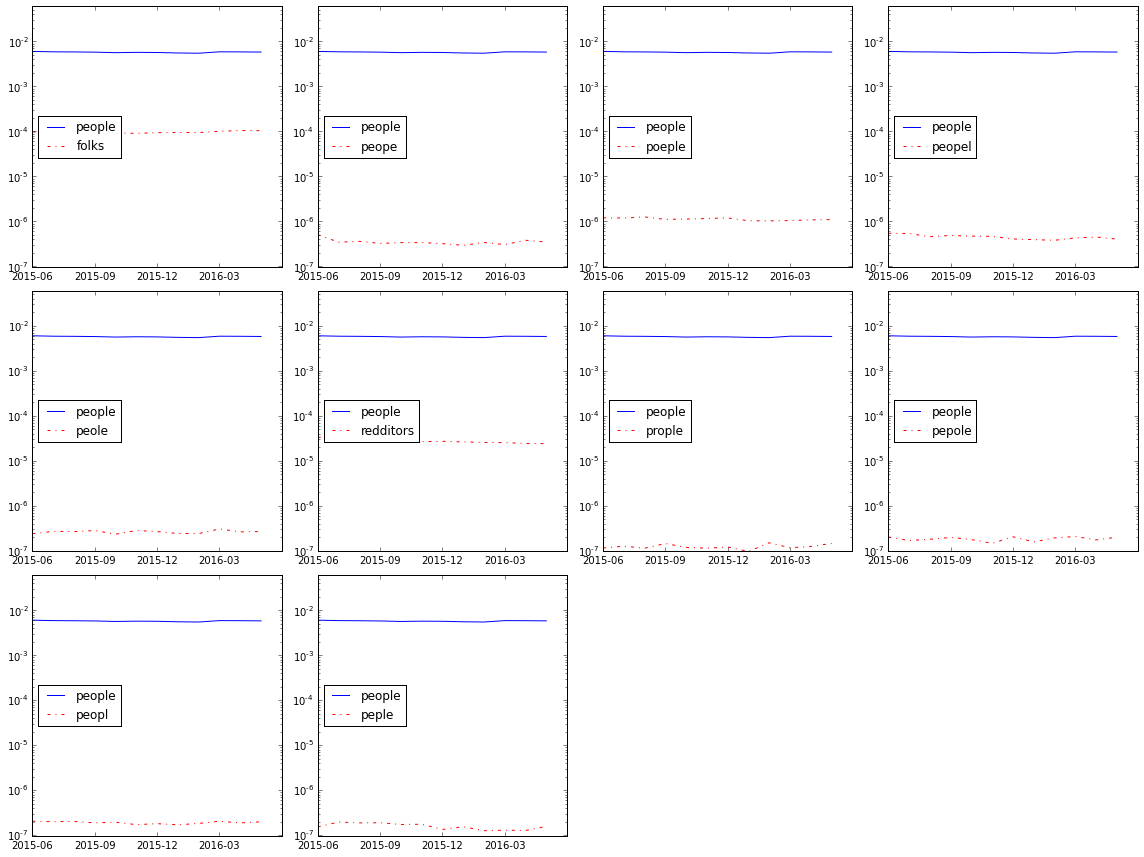

2015-12 has neighbors peole,folks,poeple,redditors,peope,prople,peopel,idiots,ppl,peopl


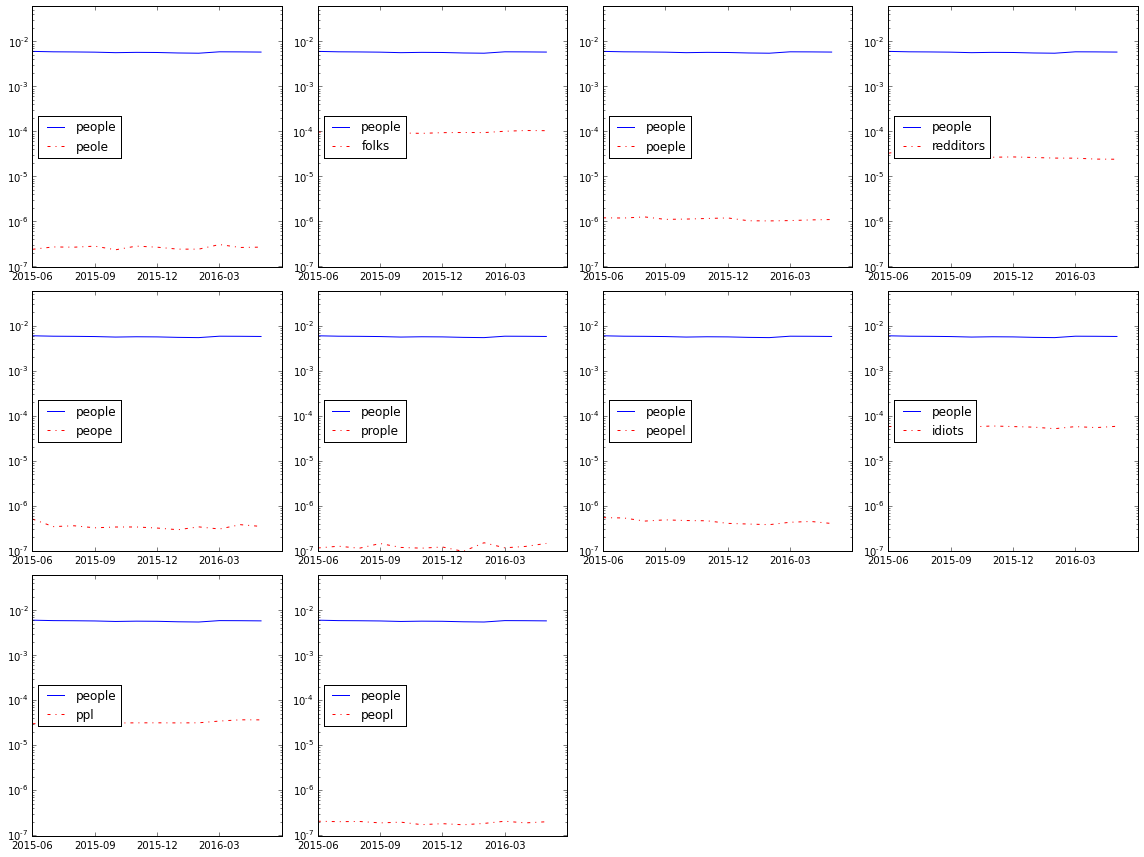

2016-01 has neighbors folks,peope,poeple,peopel,peole,redditors,prople,ppl,pepole,redditers


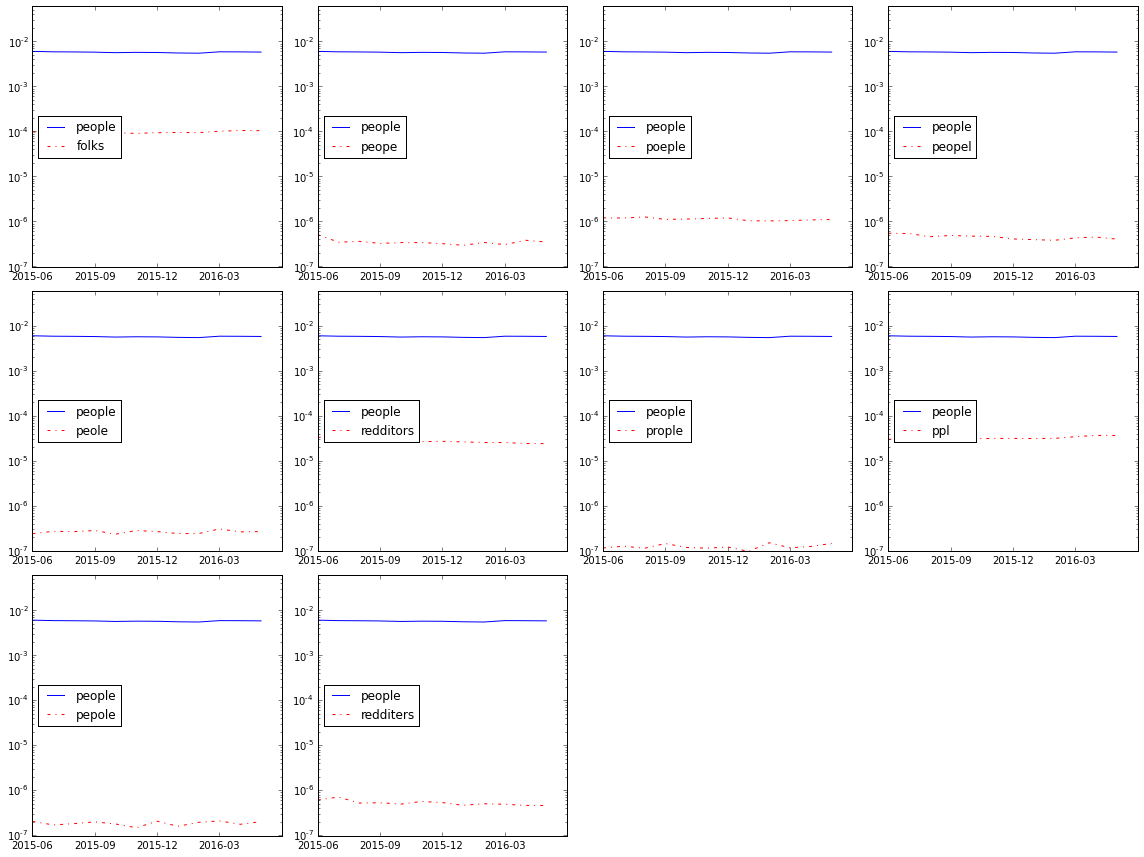

2016-02 has neighbors folks,peopel,poeple,peole,peope,redditors,prople,pepole,ppl,peple


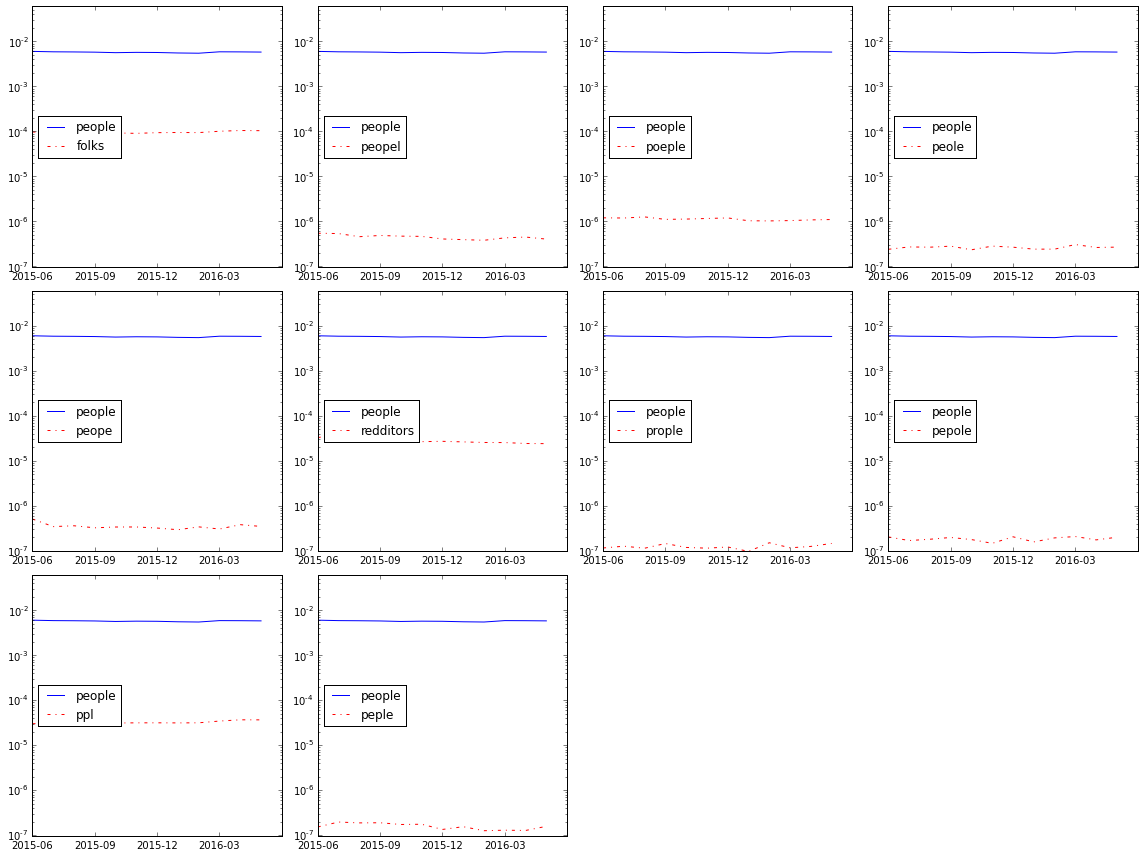

2016-03 has neighbors folks,peole,peope,peopel,poeple,redditors,peple,dumbasses,idiots,redditers


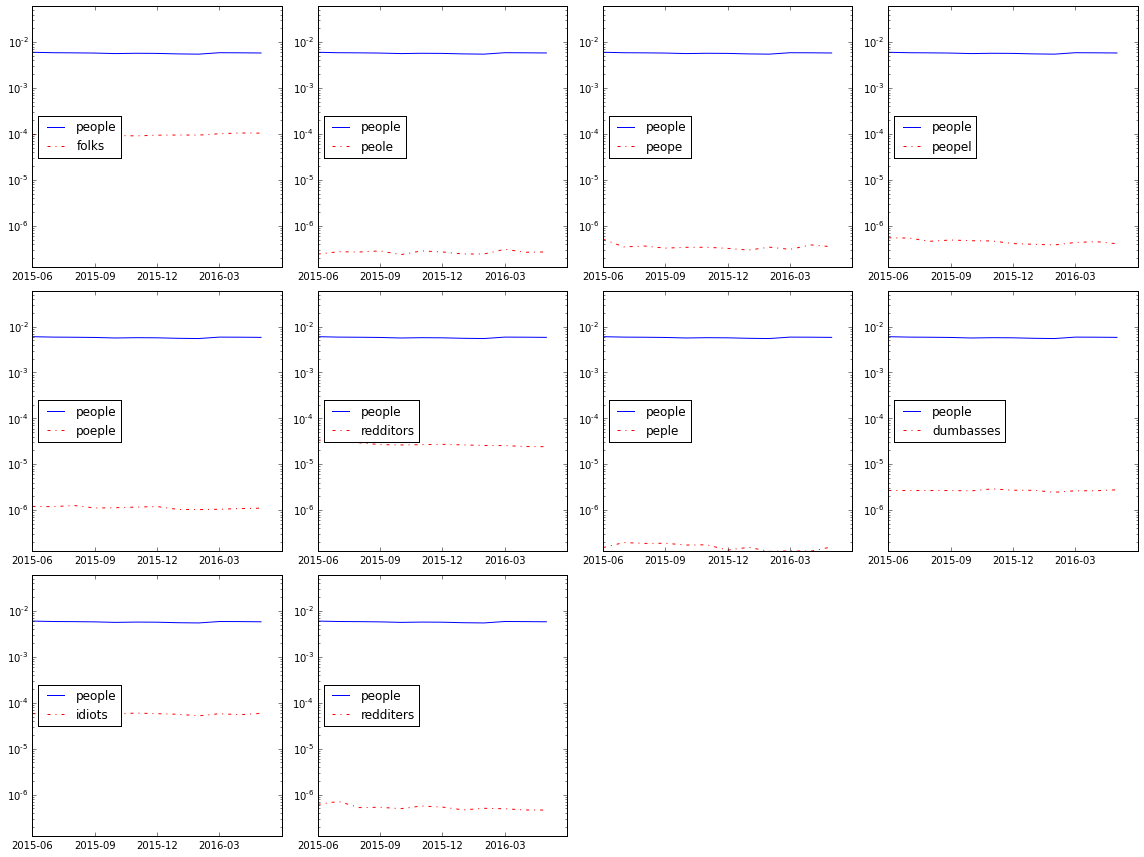

2016-04 has neighbors folks,peope,peole,peopel,poeple,prople,peple,redditors,pepole,peopl


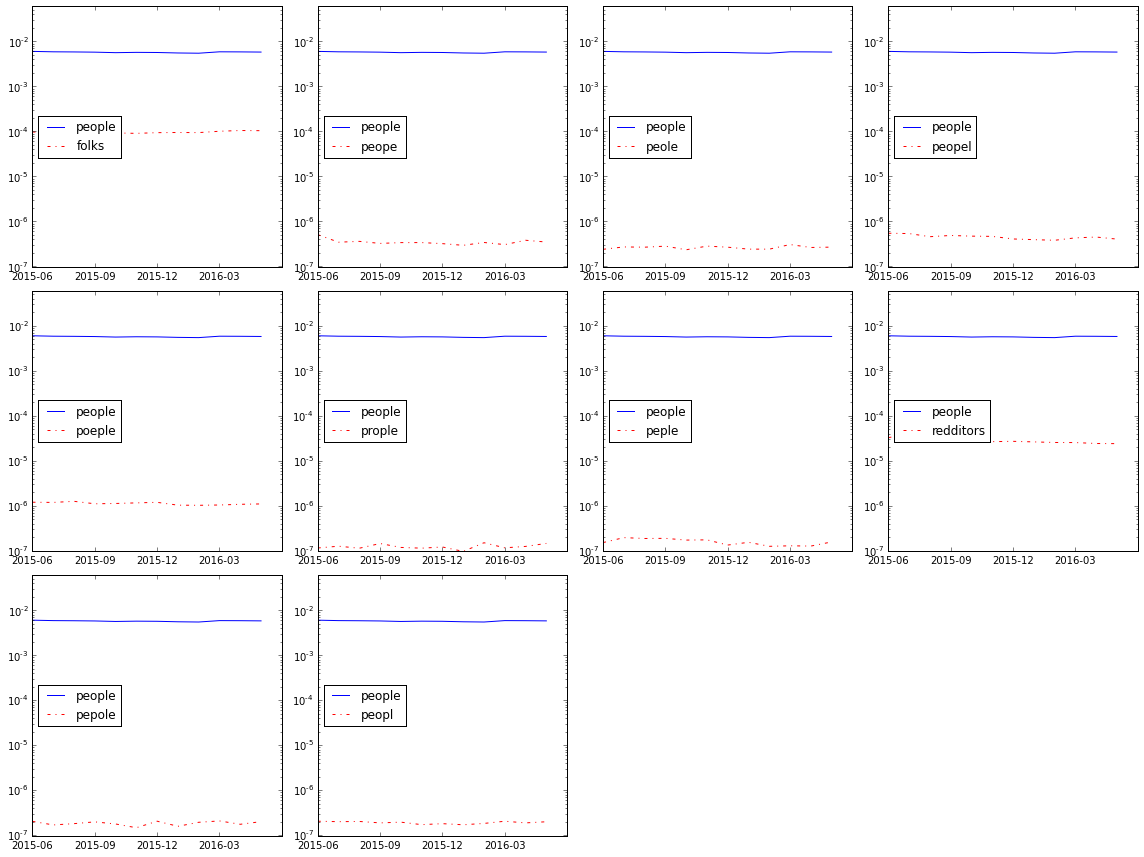

2016-05 has neighbors peole,folks,poeple,redditors,peopel,peope,pepole,prople,ppl,peple


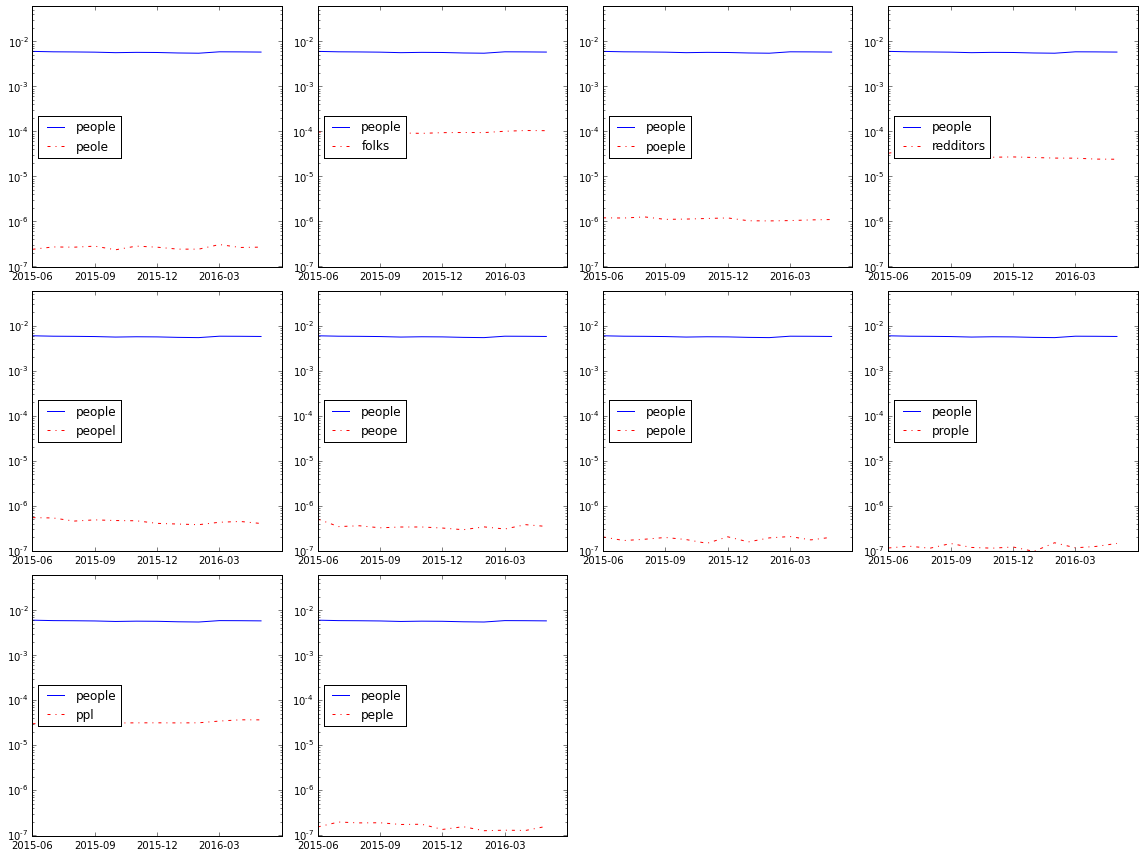

In [120]:
all_dates = sorted(tf_2015_2016.columns)
w = 'people'
top_k = 10
embedding_type = 'wang2vec'
for d in all_dates:
    embeddings = Word2Vec.load_word2vec_format('../../data/embeddings/%s_%s_100_5_embeddings'%(d, embedding_type), 
                                               binary=True)
    plot_word_and_embedding_neighbor_tf(w, embeddings, tf_2015_2016, top_k=top_k)

2015-06 has neighbors poeple,folks,peole,peopel,idiots,redditors,dumbasses,ppl,peopl,dipshits


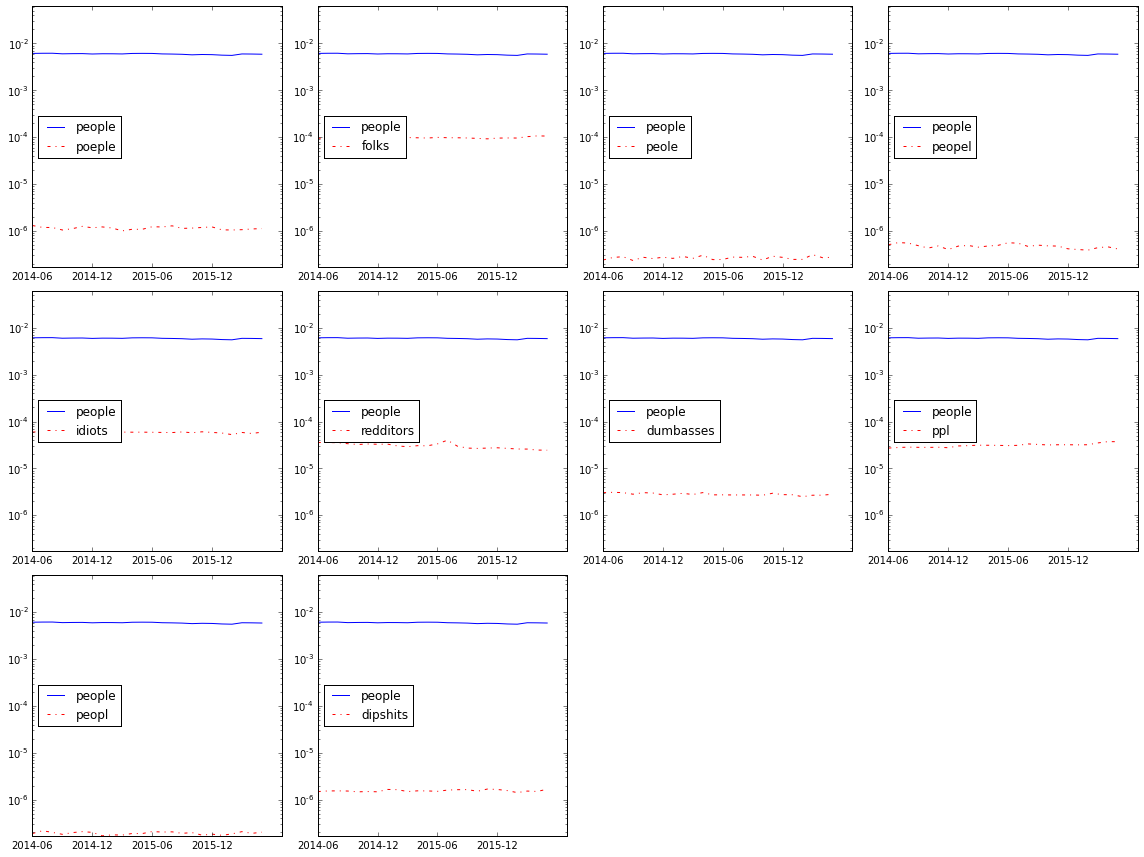

2015-07 has neighbors peole,poeple,folks,peope,peopel,redditors,idiots,prople,peopl,pepole


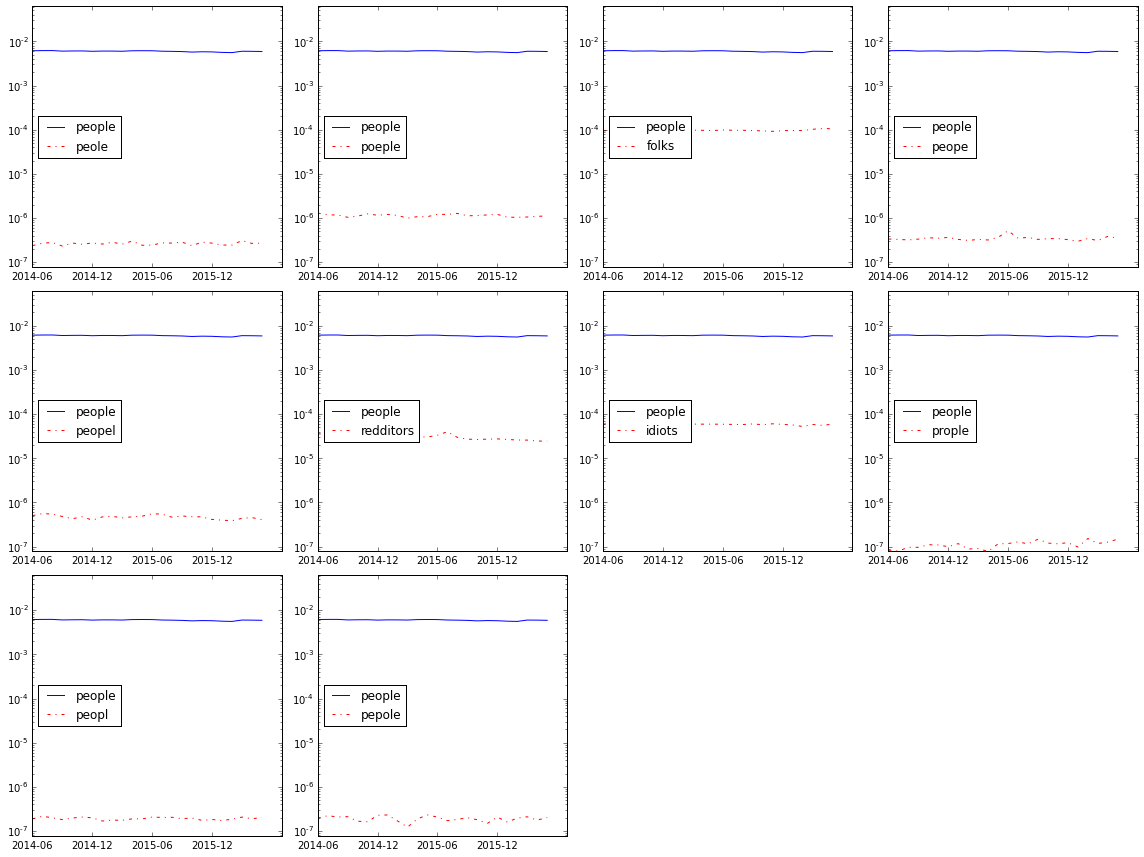

2015-08 has neighbors folks,poeple,peole,redditors,idiots,peope,peopel,prople,ppl,dumbasses


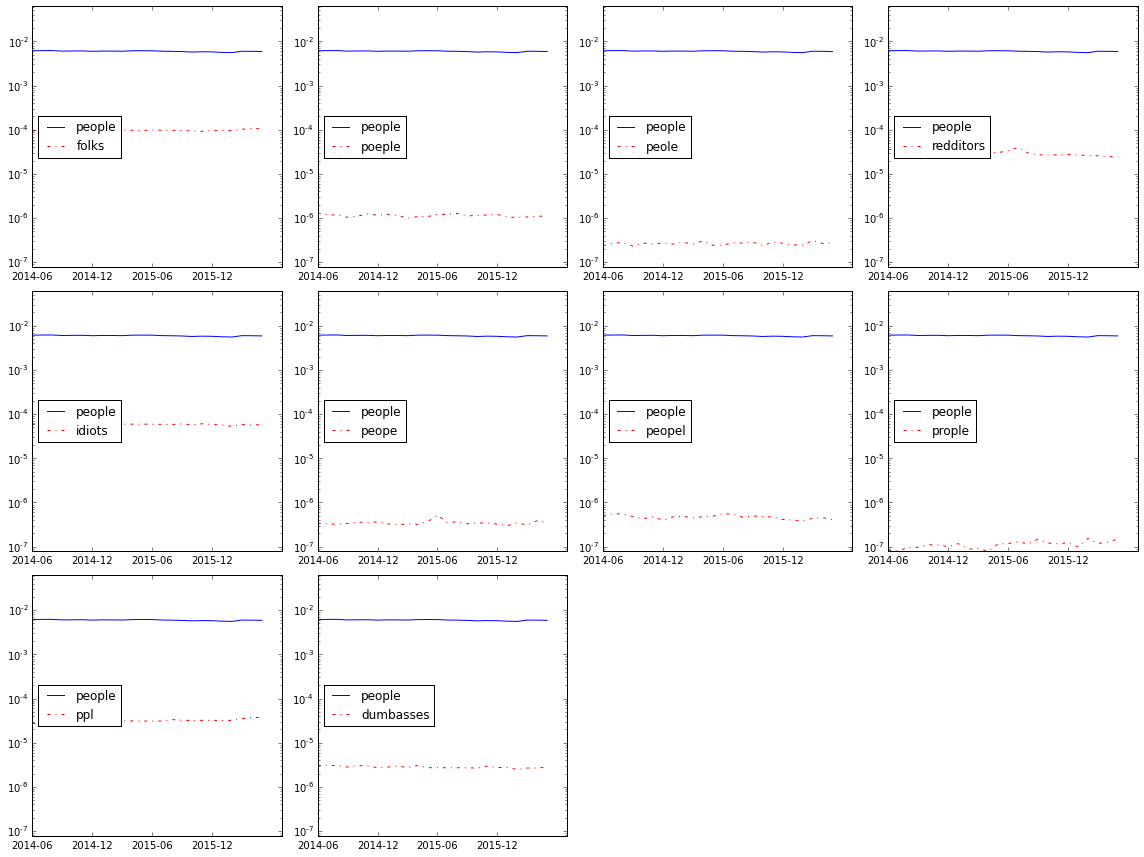

2015-09 has neighbors poeple,folks,peope,peopel,redditors,prople,peole,idiots,pepole,dipshits


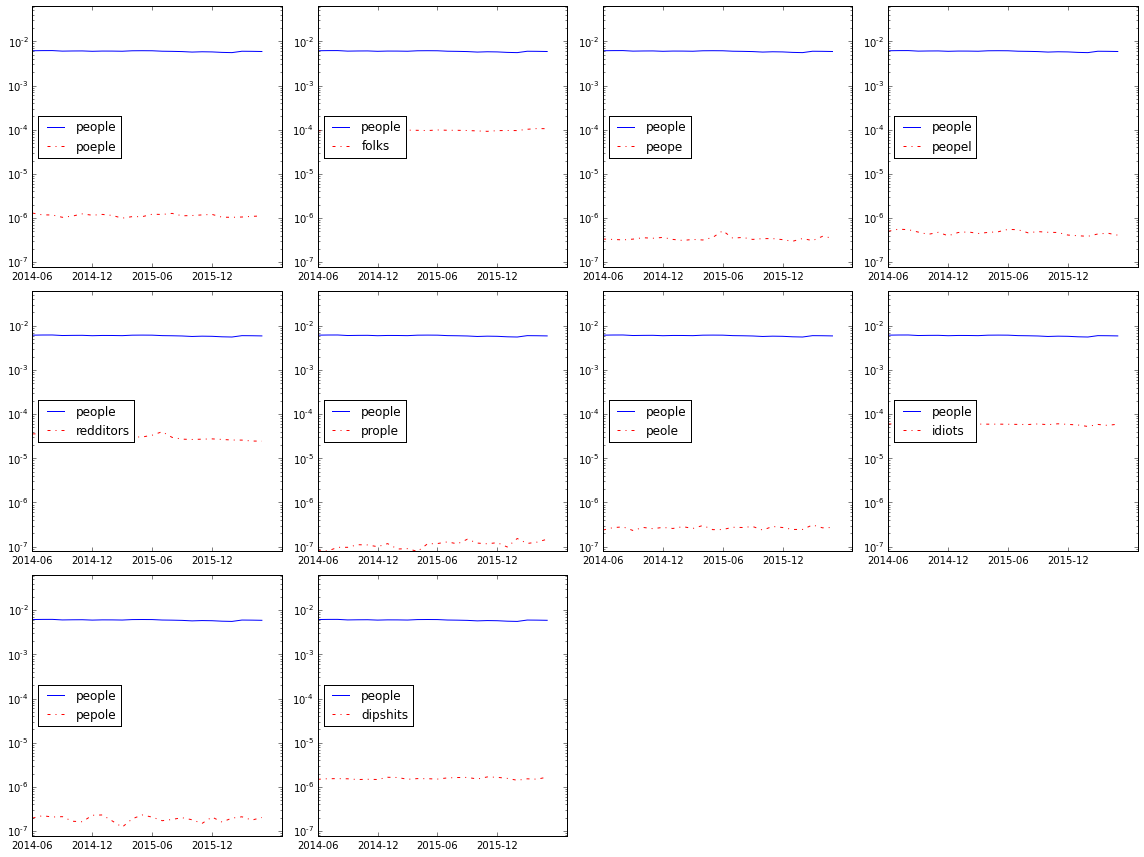

2015-10 has neighbors peopel,poeple,peope,folks,redditors,peole,idiots,pepole,dumbasses,ppl


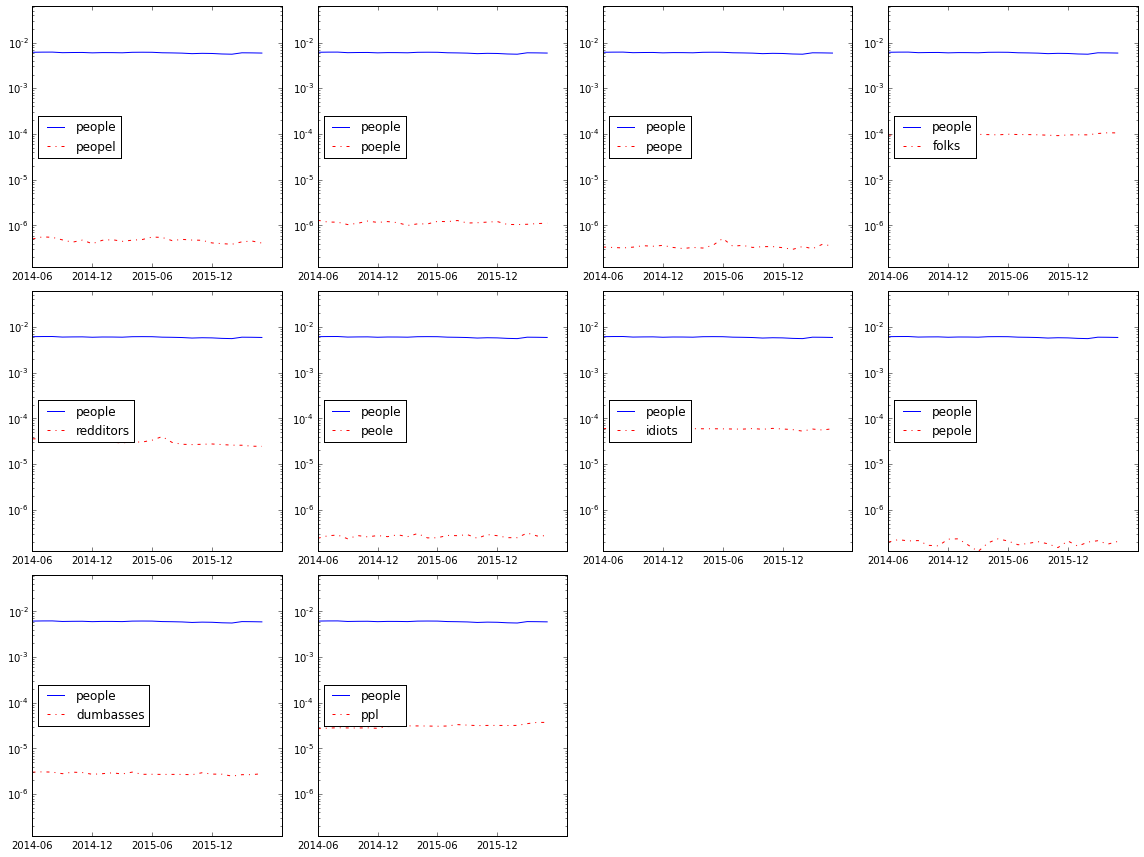

2015-11 has neighbors folks,peope,poeple,peopel,peole,redditors,idiots,dumbasses,others,prople


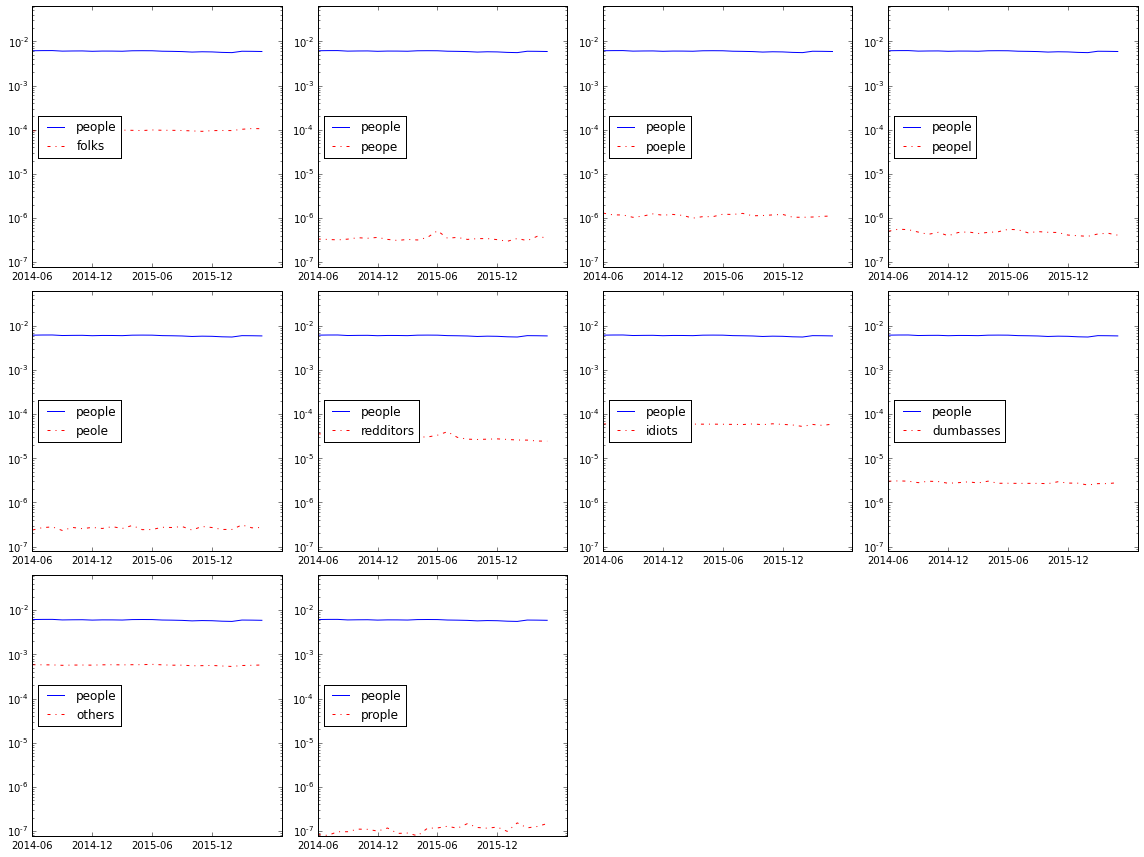

2015-12 has neighbors poeple,peole,folks,redditors,peopel,peope,idiots,ppl,others,morons


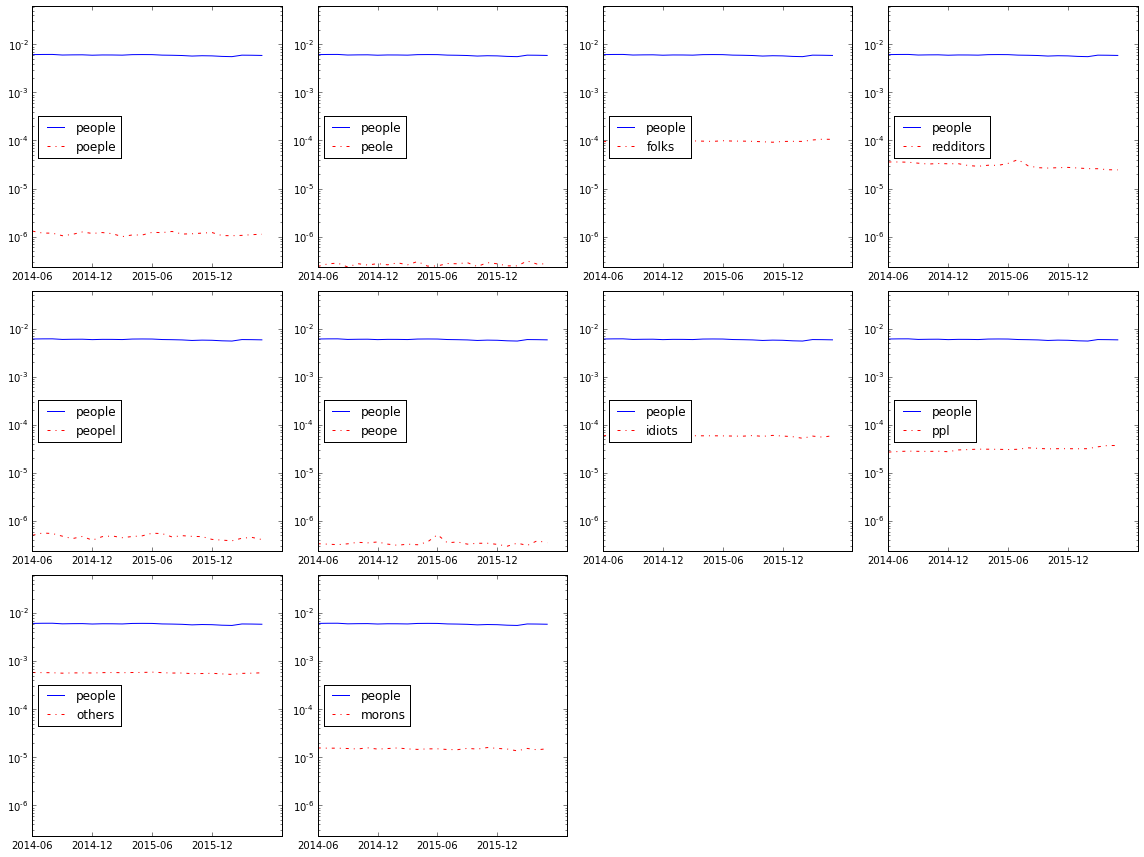

2016-01 has neighbors peope,poeple,peole,peopel,prople,folks,redditors,pepole,redditers,peopl


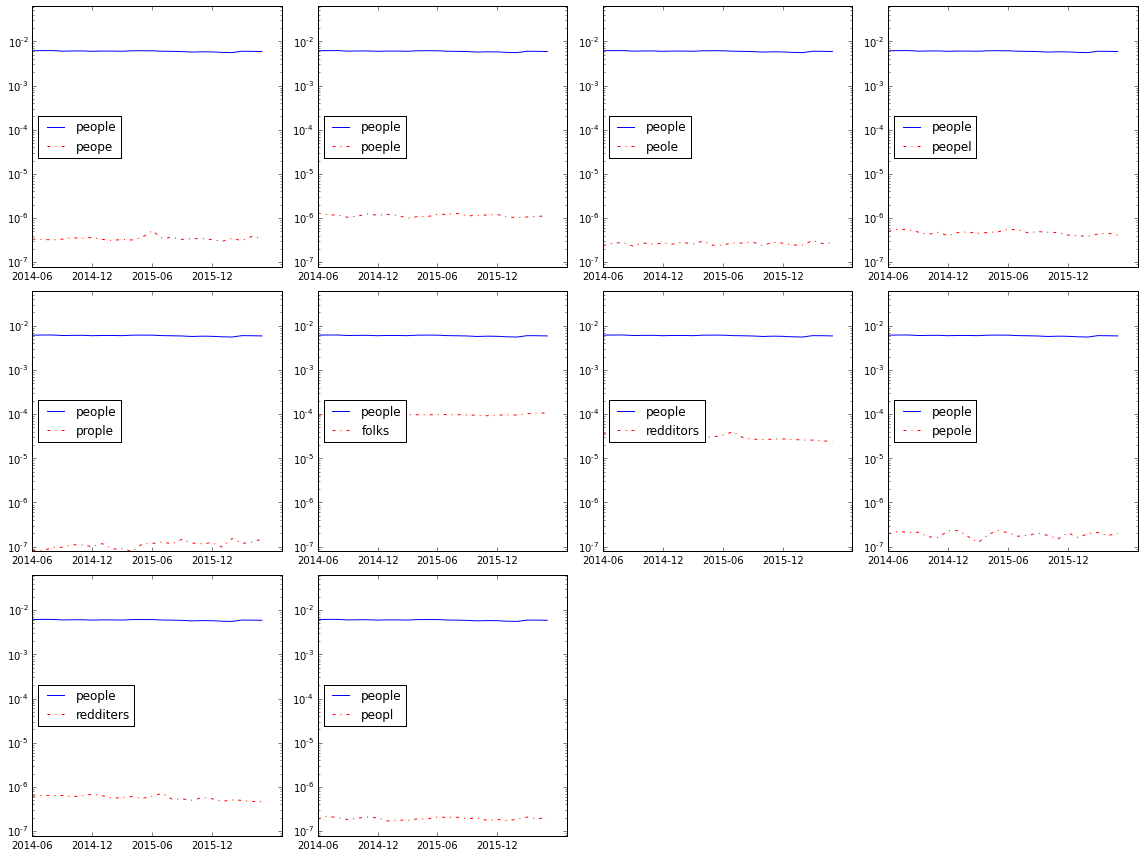

2016-02 has neighbors poeple,folks,peopel,peope,redditors,peole,idiots,ppl,dumbasses,dipshits


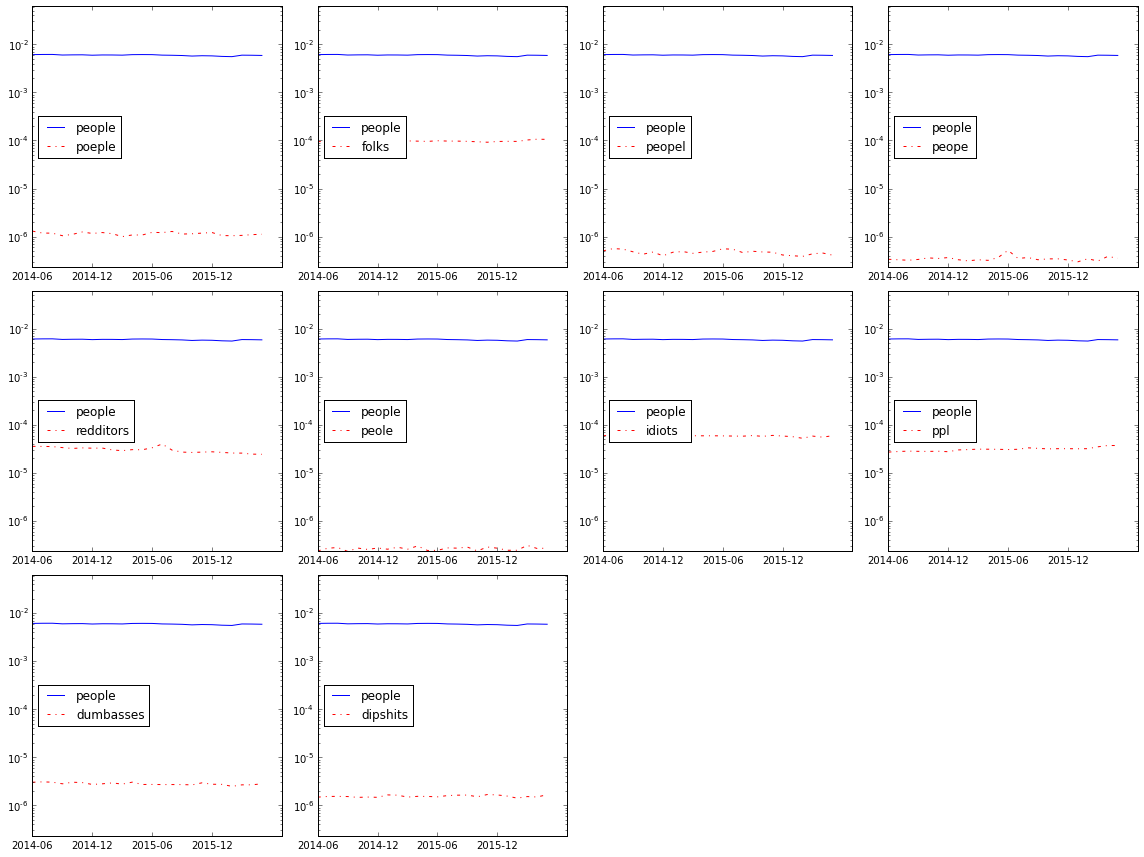

2016-03 has neighbors poeple,folks,peopel,peole,redditors,peope,idiots,ppl,others,dumbasses


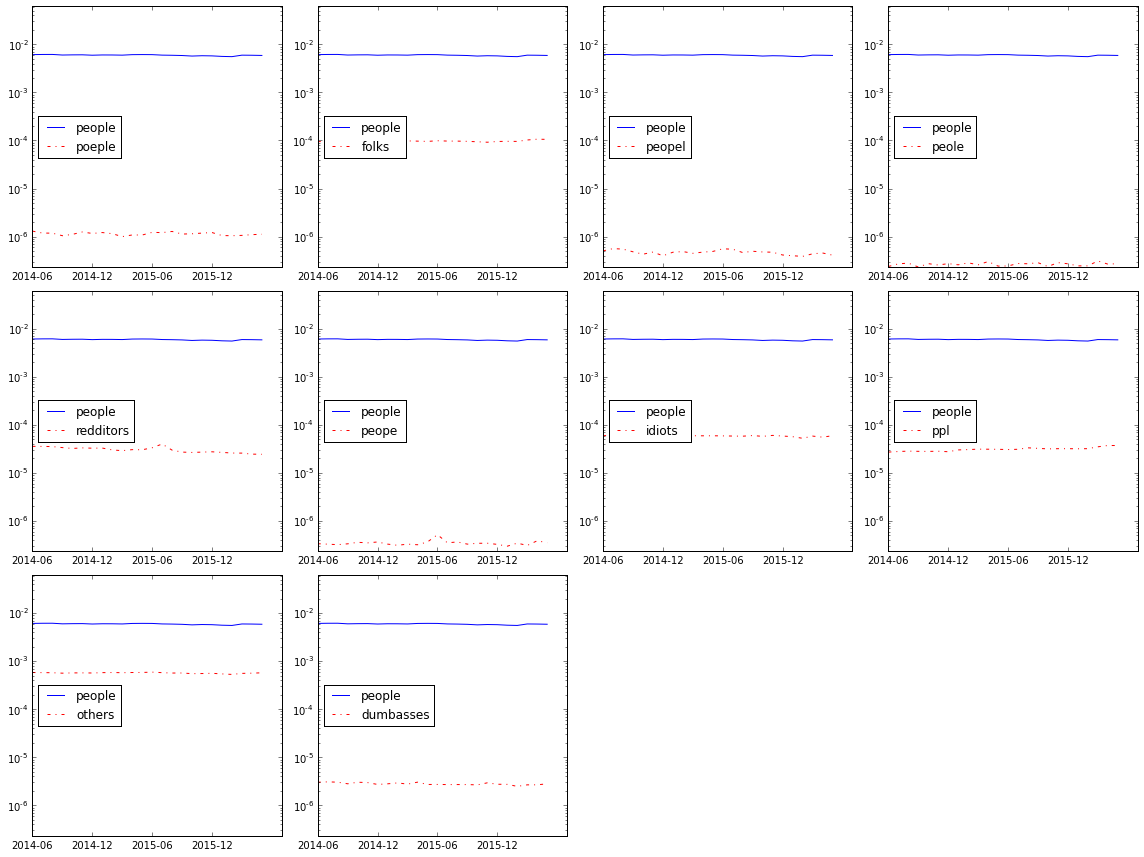

2016-04 has neighbors peope,folks,poeple,redditors,peole,peopel,idiots,ppl,peopl,prople


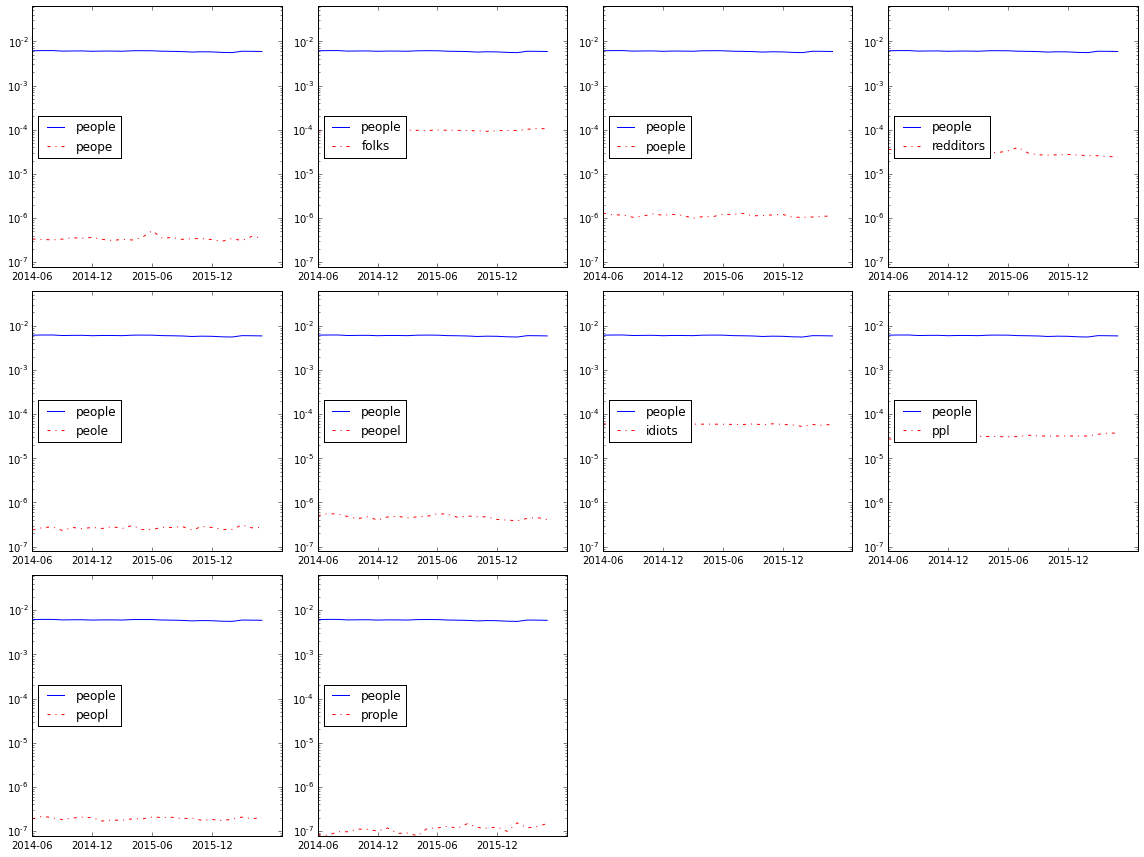

2016-05 has neighbors poeple,folks,peole,peope,redditors,idiots,peopel,ppl,pepole,dumbasses


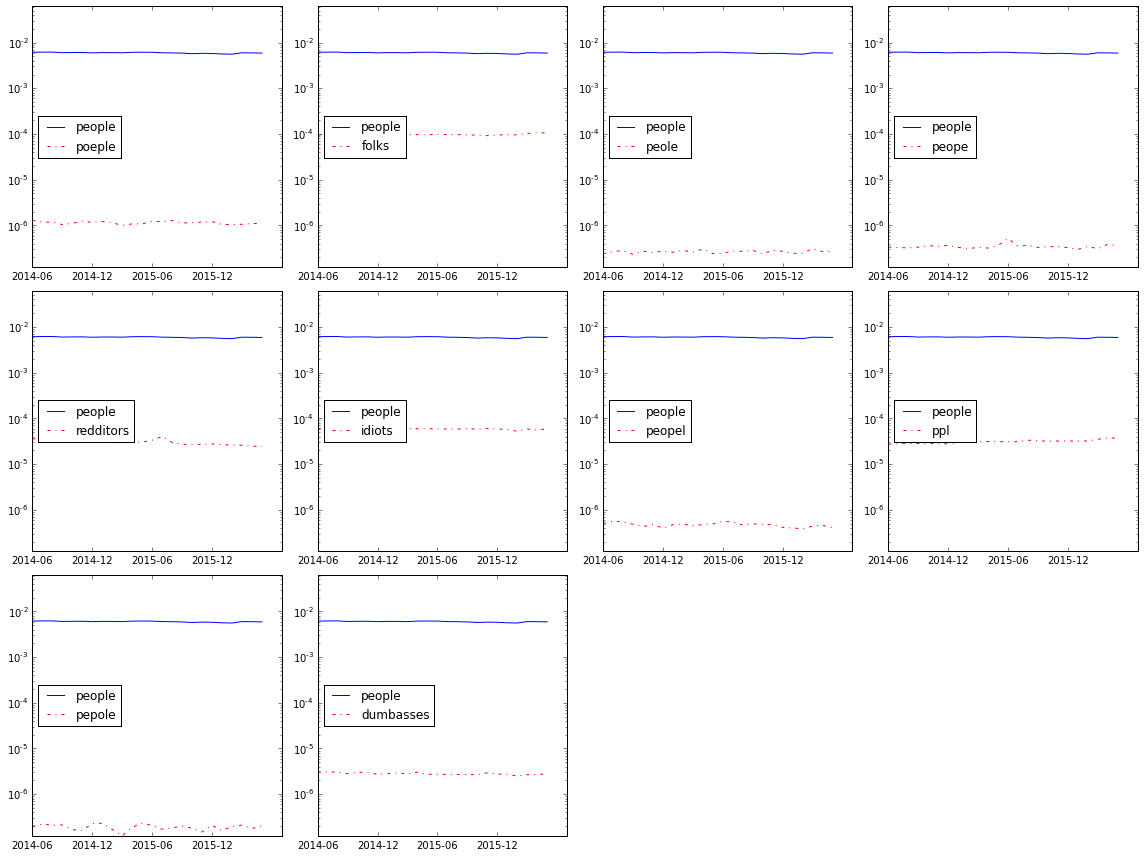

In [110]:
w = 'people'
top_k = 10
embedding_type = 'word2vec'
for d in all_dates:
    embeddings = Word2Vec.load_word2vec_format('../../data/embeddings/%s_%s_100_5_embeddings'%(d, embedding_type), 
                                               binary=True)
    neighbor_sim_pairs = embeddings.most_similar(w, topn=top_k)
    neighbors, neighbor_sims = zip(*neighbor_sim_pairs)
    neighbors = list(neighbors)
    print('%s has neighbors %s'%(d, ','.join(neighbors)))
    plot_word_neighbors(w, neighbors, tf_2014_2016)

2015-06 has neighbors definitely,prolly,probaby,defiantly,proably,proabably,definately,certainly,probly,probaly


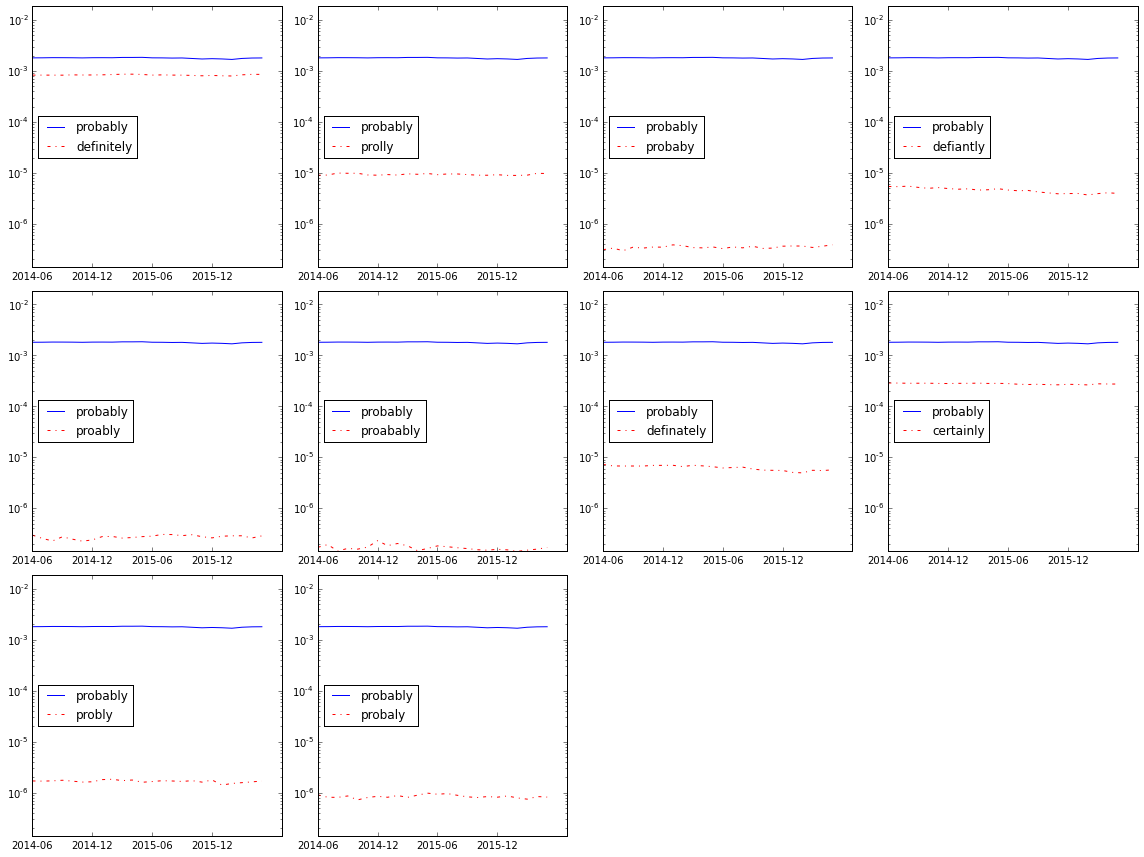

2015-07 has neighbors definitely,probaby,prolly,definately,proably,certainly,probly,defiantly,defintely,likely


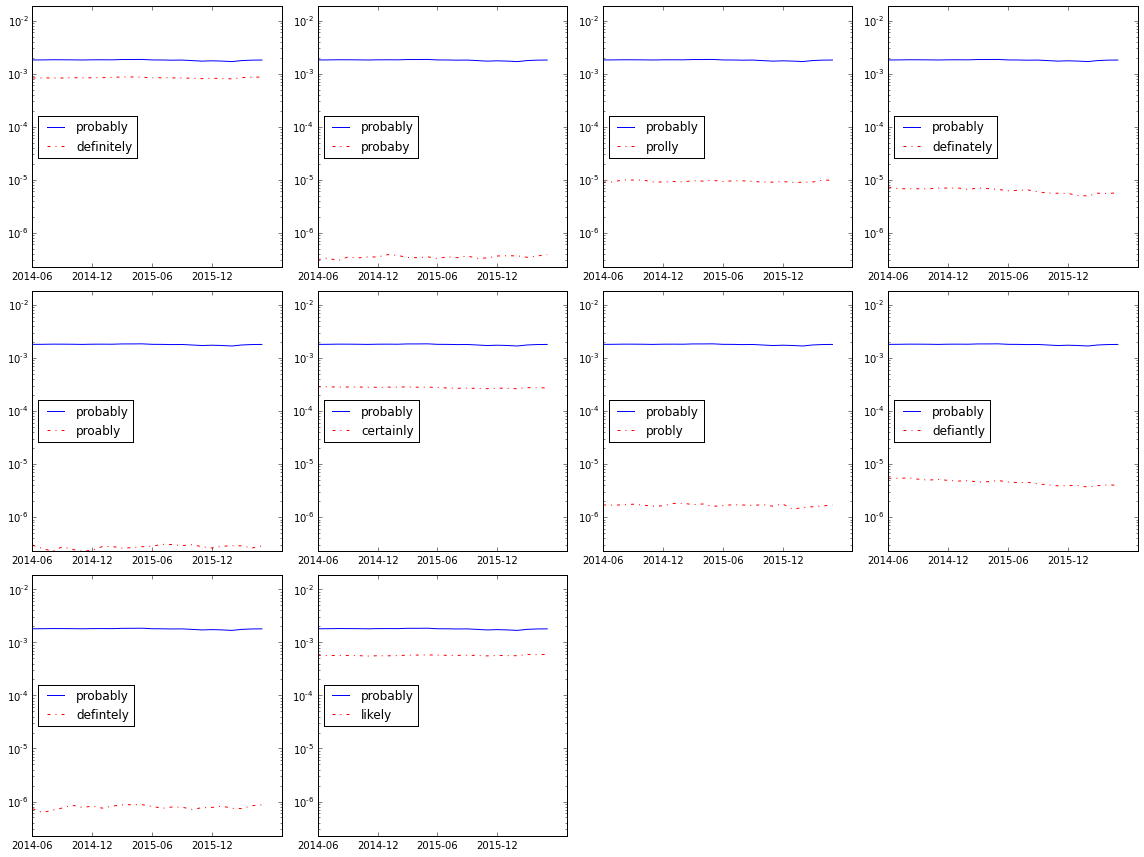

2015-08 has neighbors definitely,definately,prolly,proably,probaby,probly,defiantly,certainly,definetely,likely


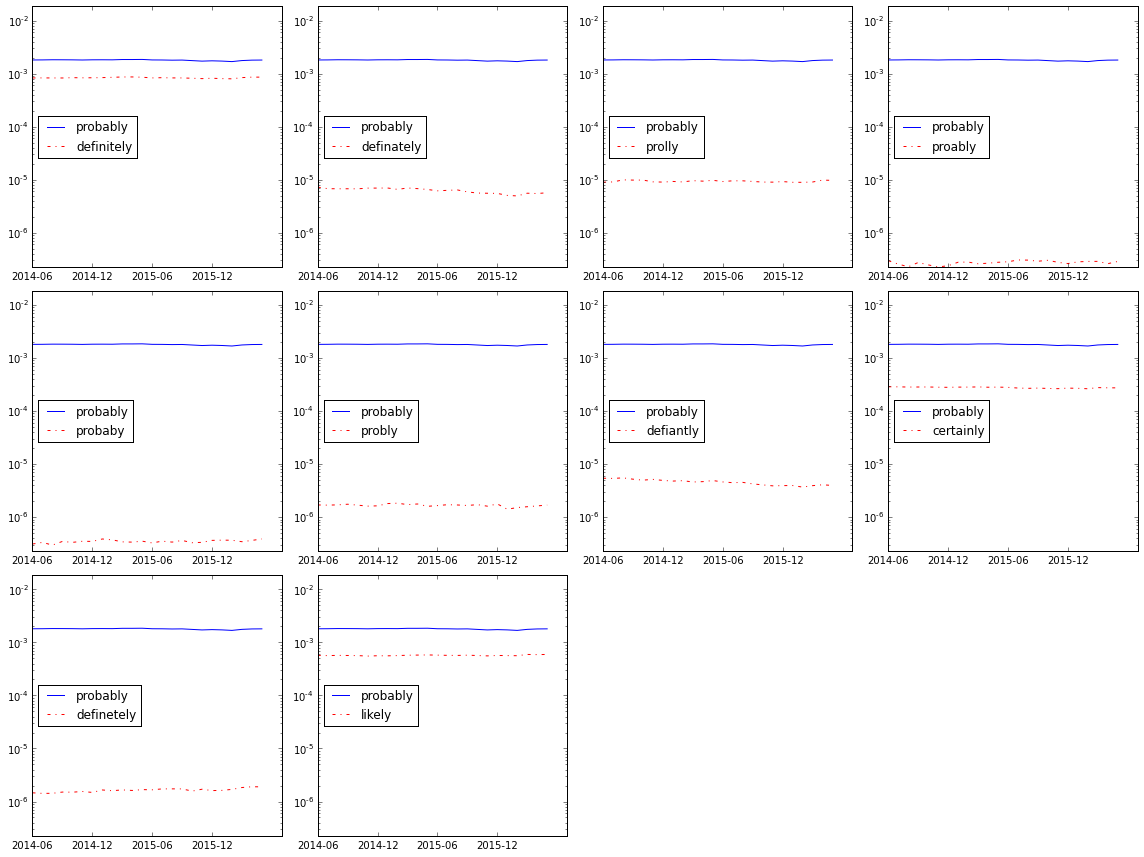

2015-09 has neighbors definitely,probaby,prolly,probly,defiantly,certainly,definately,probabaly,proabably,still


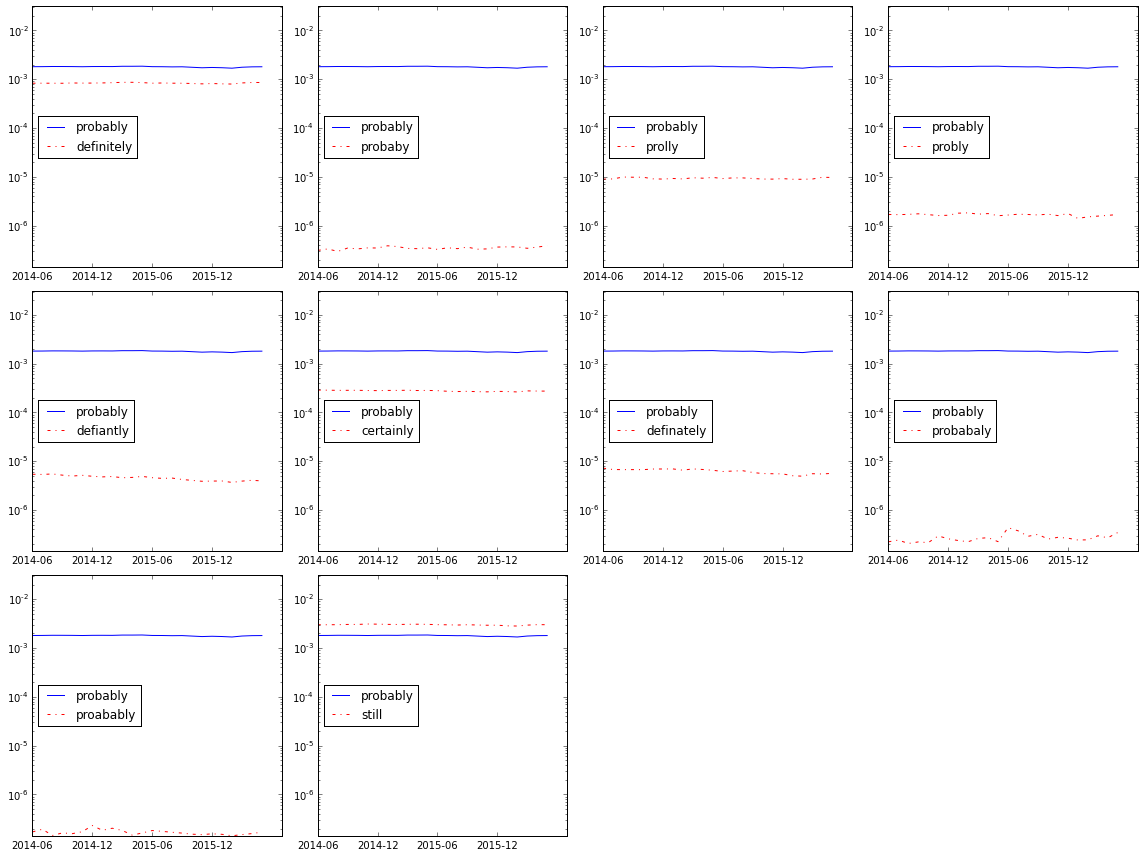

2015-10 has neighbors definitely,prolly,probly,definately,probobly,proably,defiantly,definetly,probaly,certainly


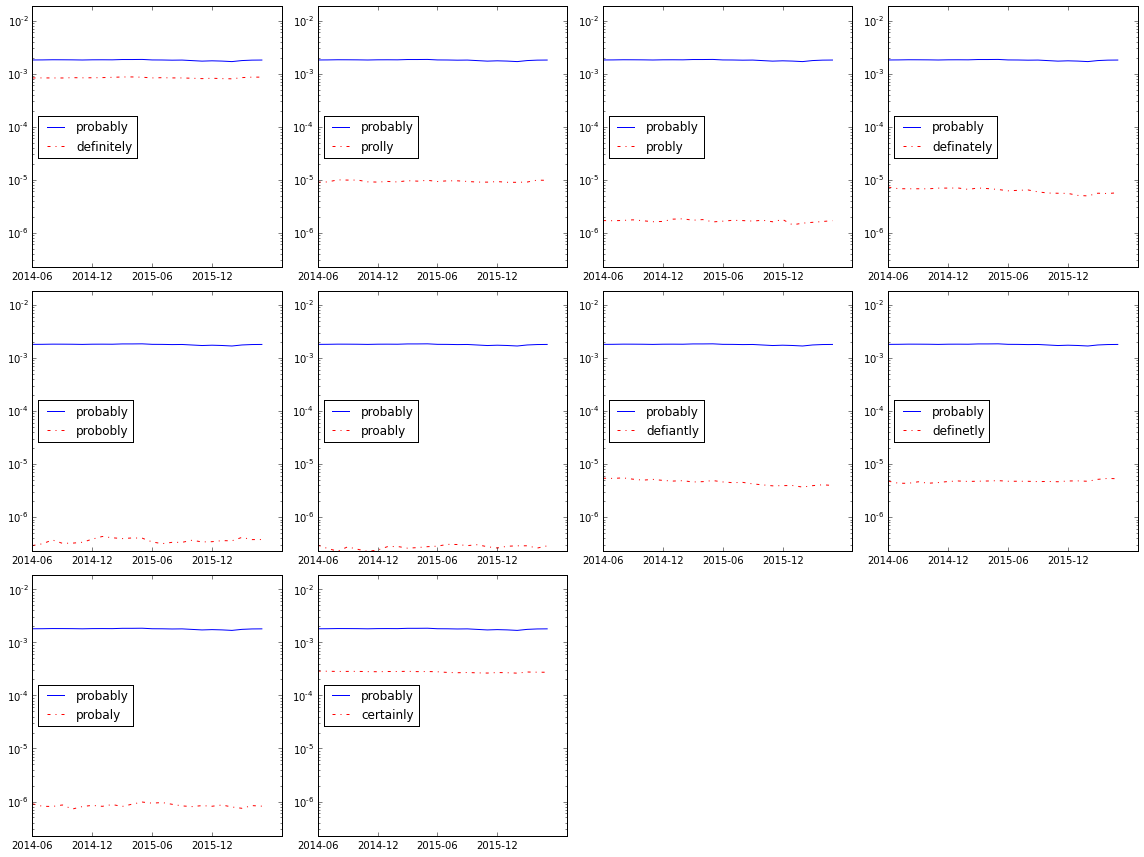

2015-11 has neighbors definitely,probaby,prolly,definately,defiantly,probabaly,certainly,probly,still,likely


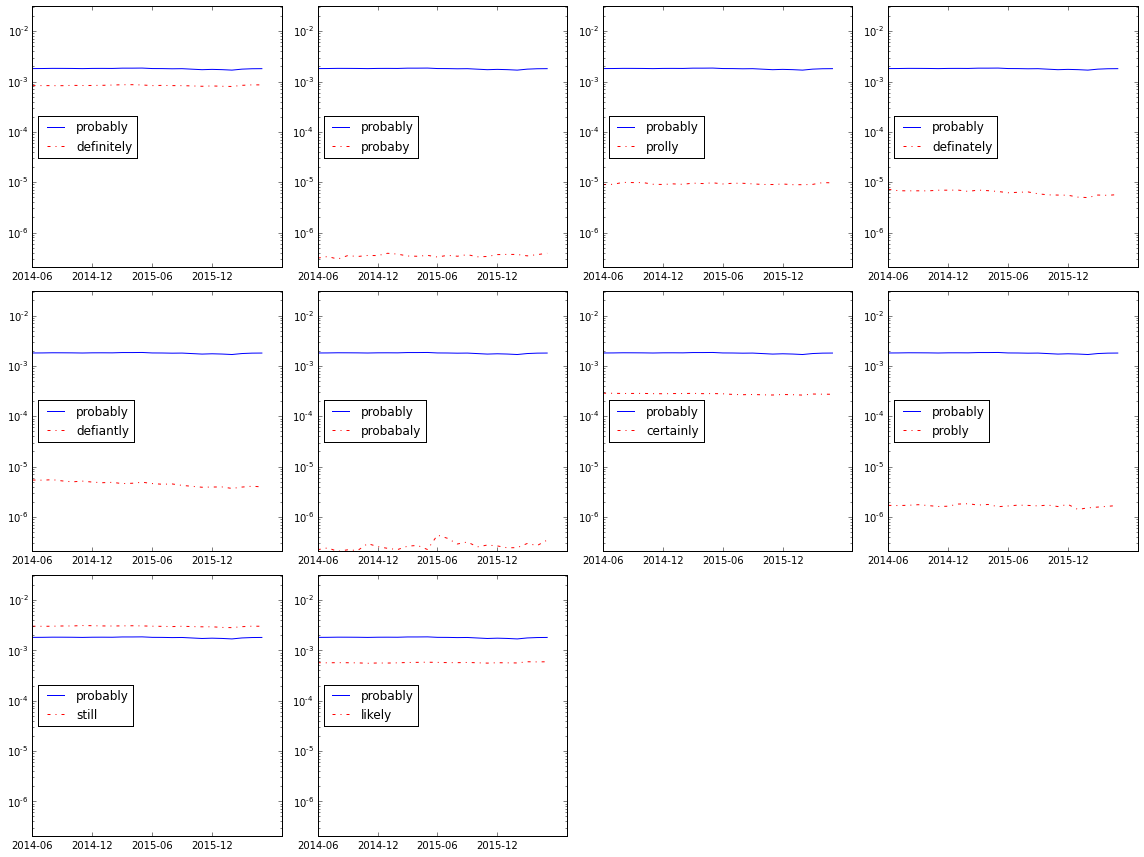

2015-12 has neighbors definitely,defiantly,prolly,definately,probaby,still,definitley,certainly,definetly,probabaly


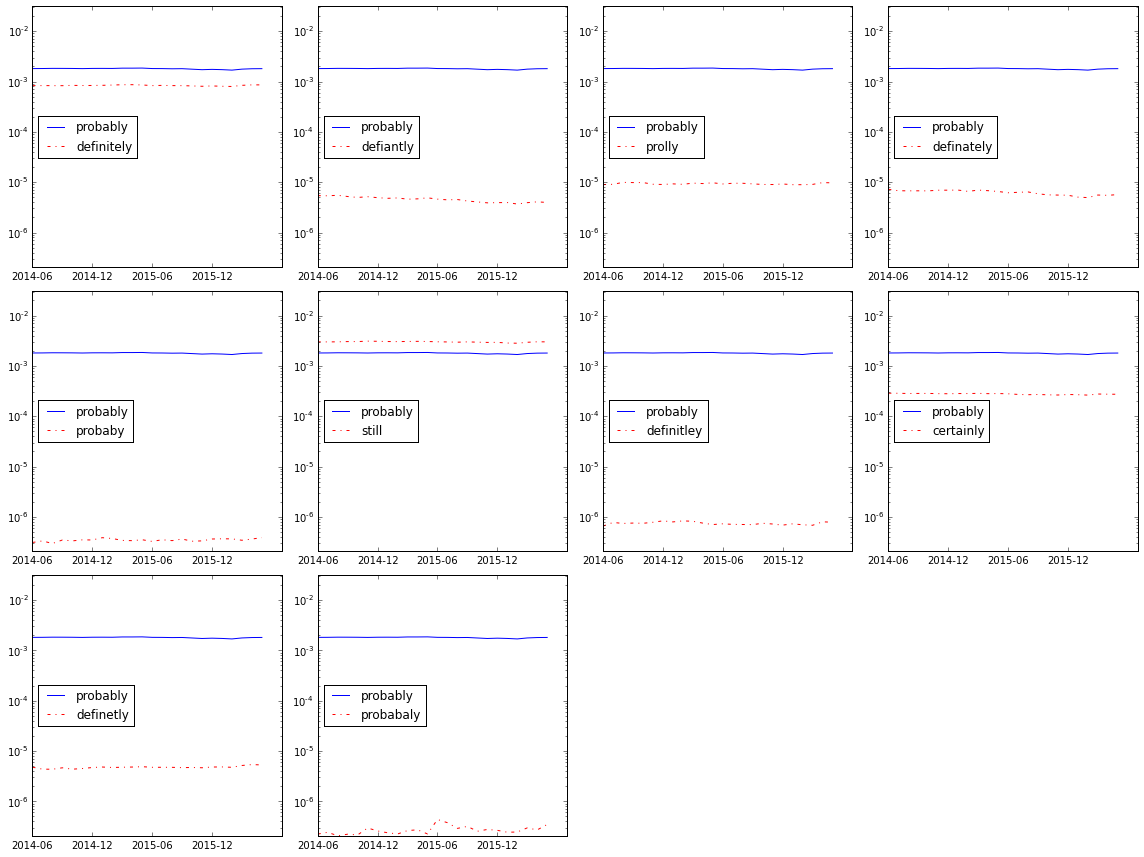

2016-01 has neighbors definitely,prolly,defintely,probobly,probaby,definately,defiantly,still,probly,certainly


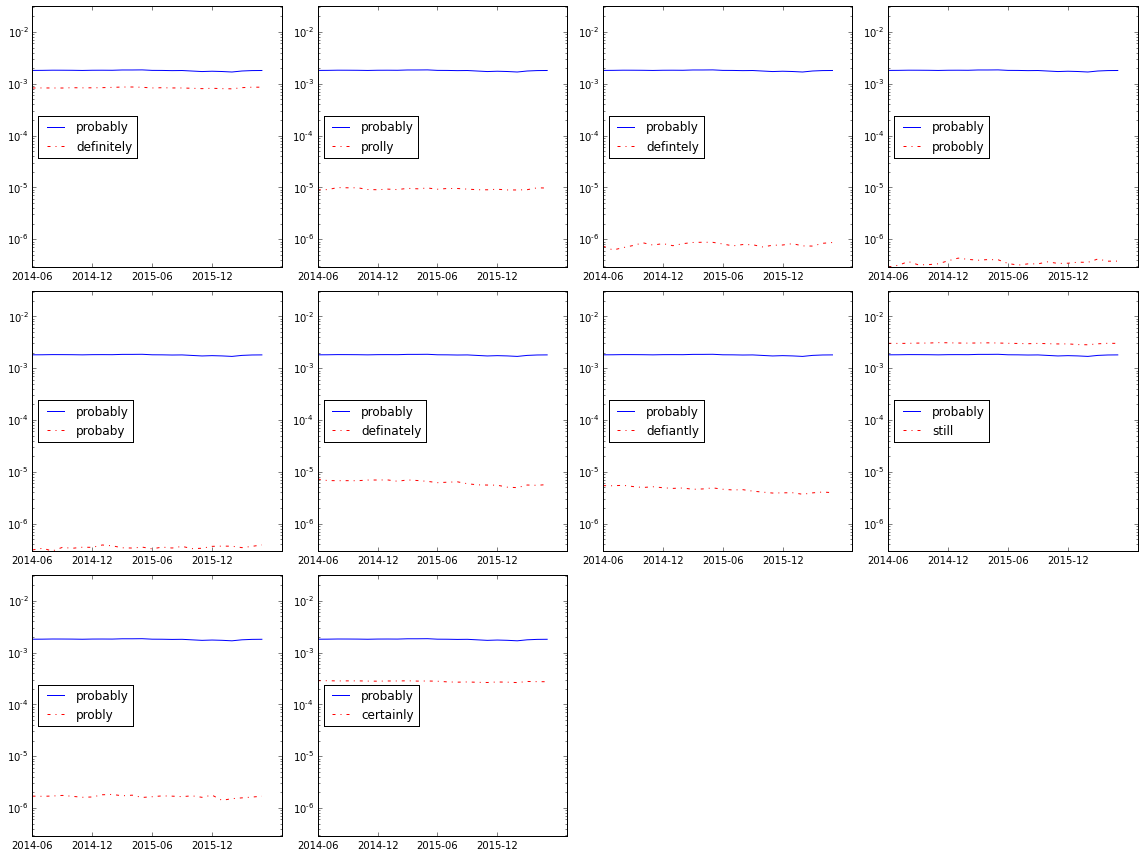

2016-02 has neighbors probaby,definitely,probabaly,defiantly,prolly,definately,certainly,definetly,defintely,still


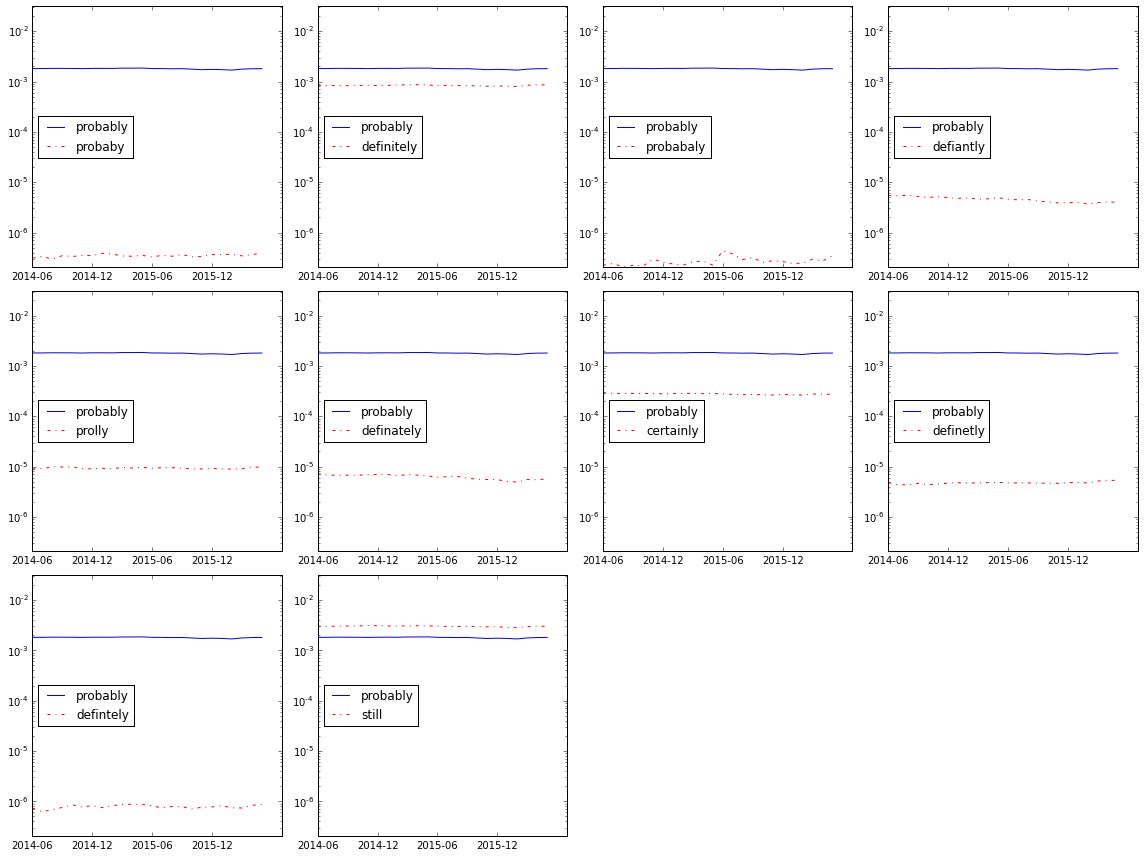

2016-03 has neighbors definitely,defiantly,prolly,propably,probabaly,definately,certainly,probobly,probly,definetly


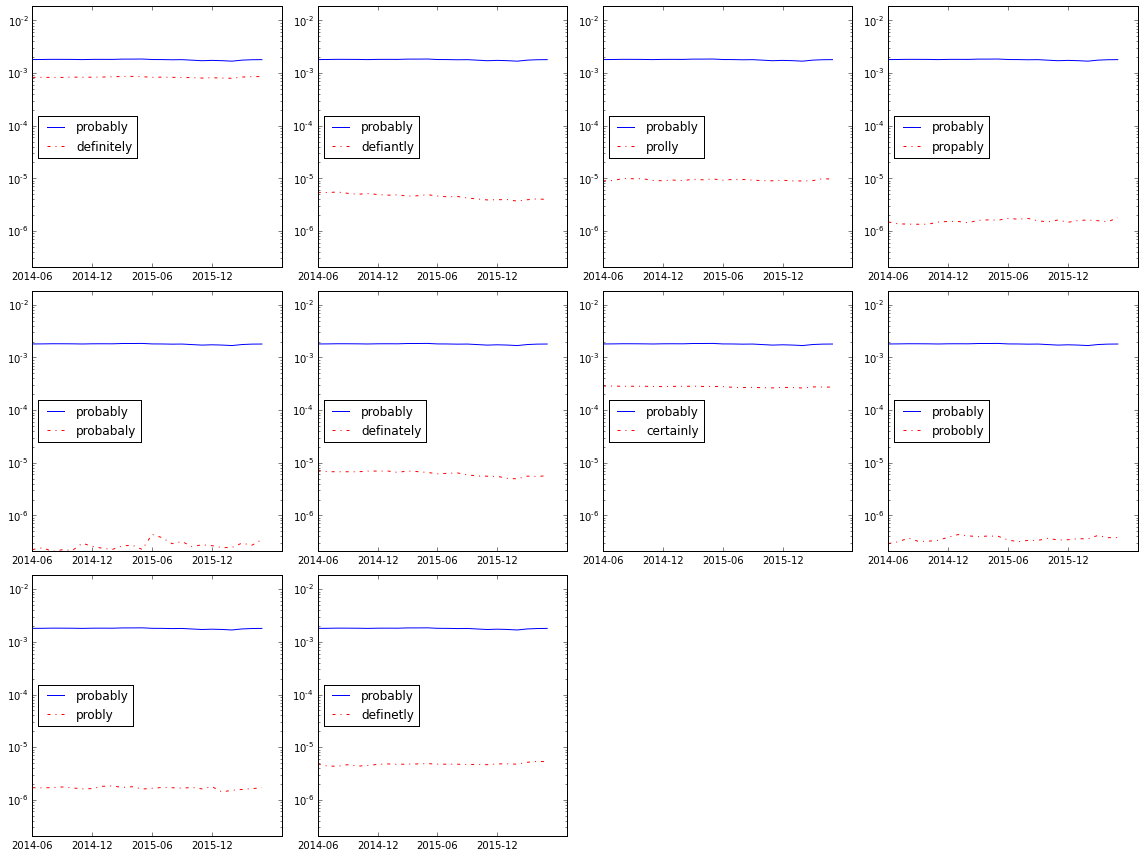

2016-04 has neighbors definitely,prolly,defiantly,defintely,probaby,definately,probly,certainly,still,probaly


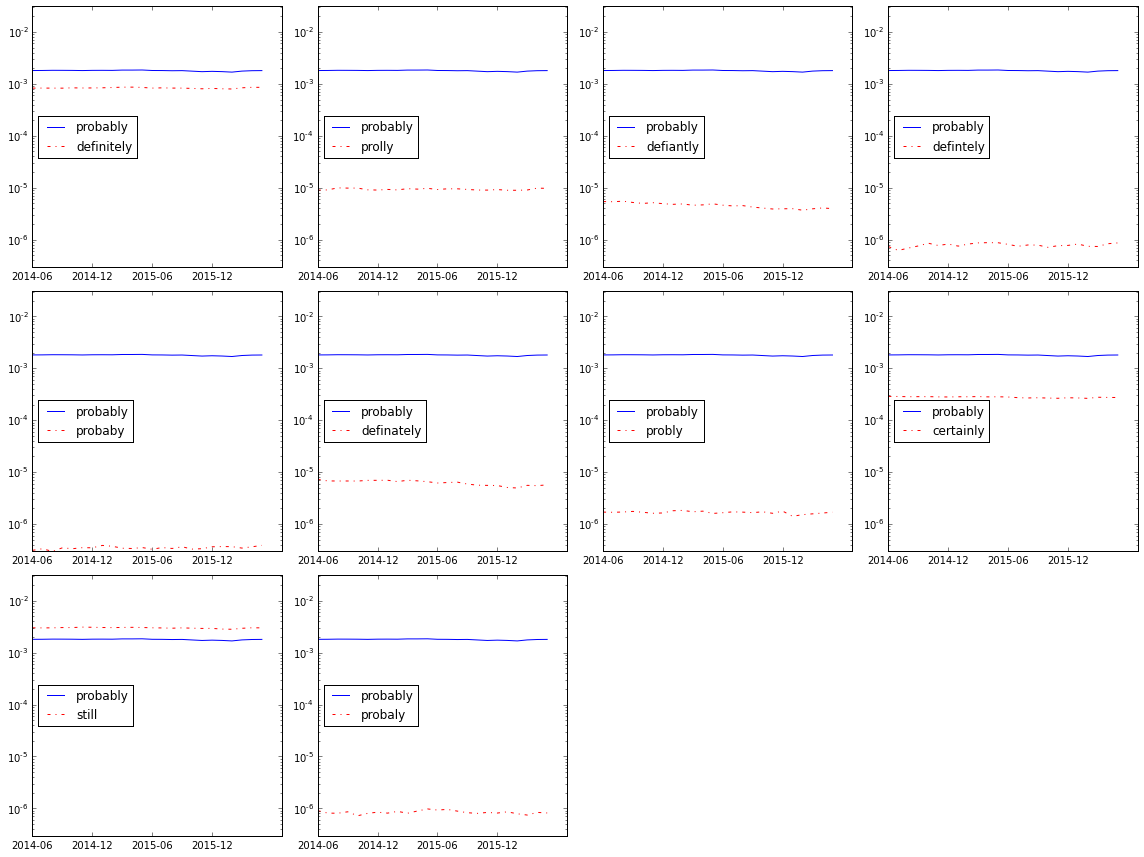

2016-05 has neighbors definitely,probaby,definately,prolly,probly,probabaly,defiantly,definitley,propably,definetly


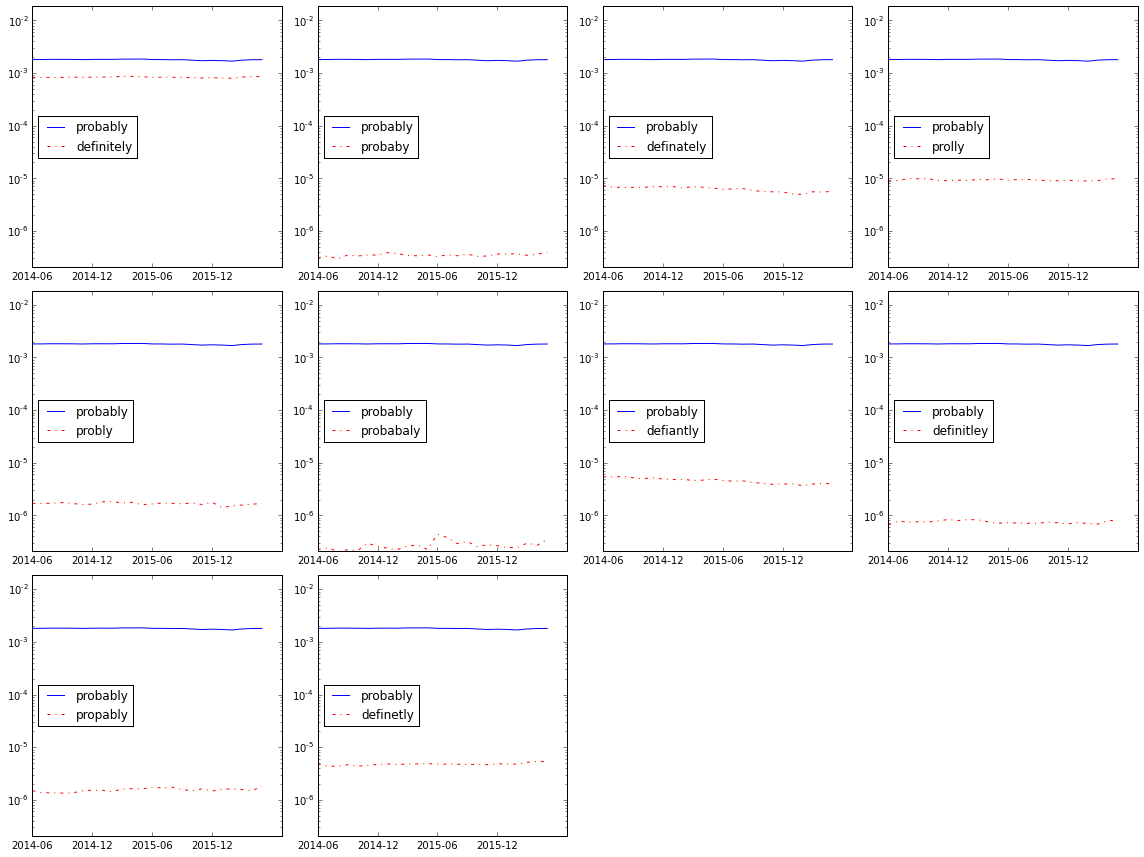

In [106]:
w = 'probably'
top_k = 10
embedding_type = 'wang2vec'
for d in all_dates:
    embeddings = Word2Vec.load_word2vec_format('../../data/embeddings/%s_%s_100_5_embeddings'%(d, embedding_type), 
                                               binary=True)
    neighbor_sim_pairs = embeddings.most_similar(w, topn=top_k)
    neighbors, neighbor_sims = zip(*neighbor_sim_pairs)
    neighbors = list(neighbors)
    print('%s has neighbors %s'%(d, ','.join(neighbors)))
    plot_word_neighbors(w, neighbors, tf_2014_2016)

2015-06 has neighbors prolly,definitely,maybe,likely,reckon,anyway,probaby,think,though,probbaly


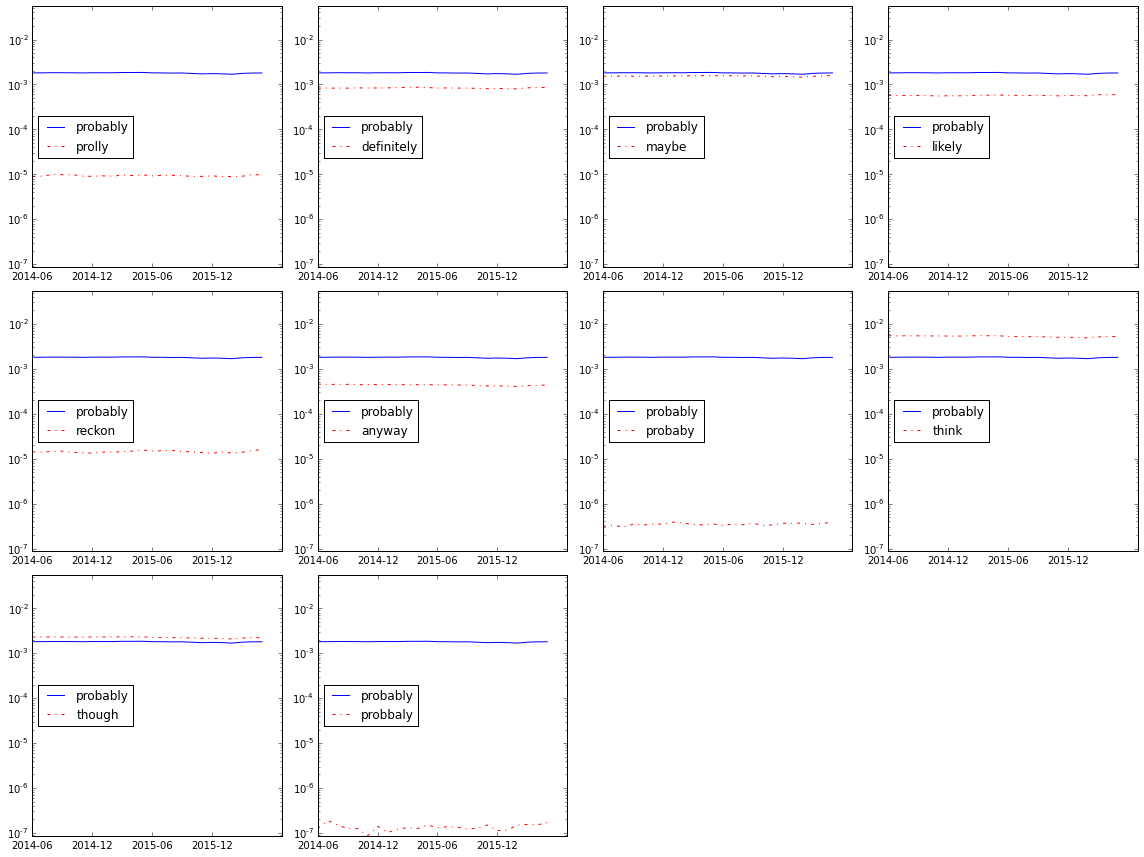

2015-07 has neighbors prolly,definitely,likely,definately,think,probly,though,maybe,reckon,anyway


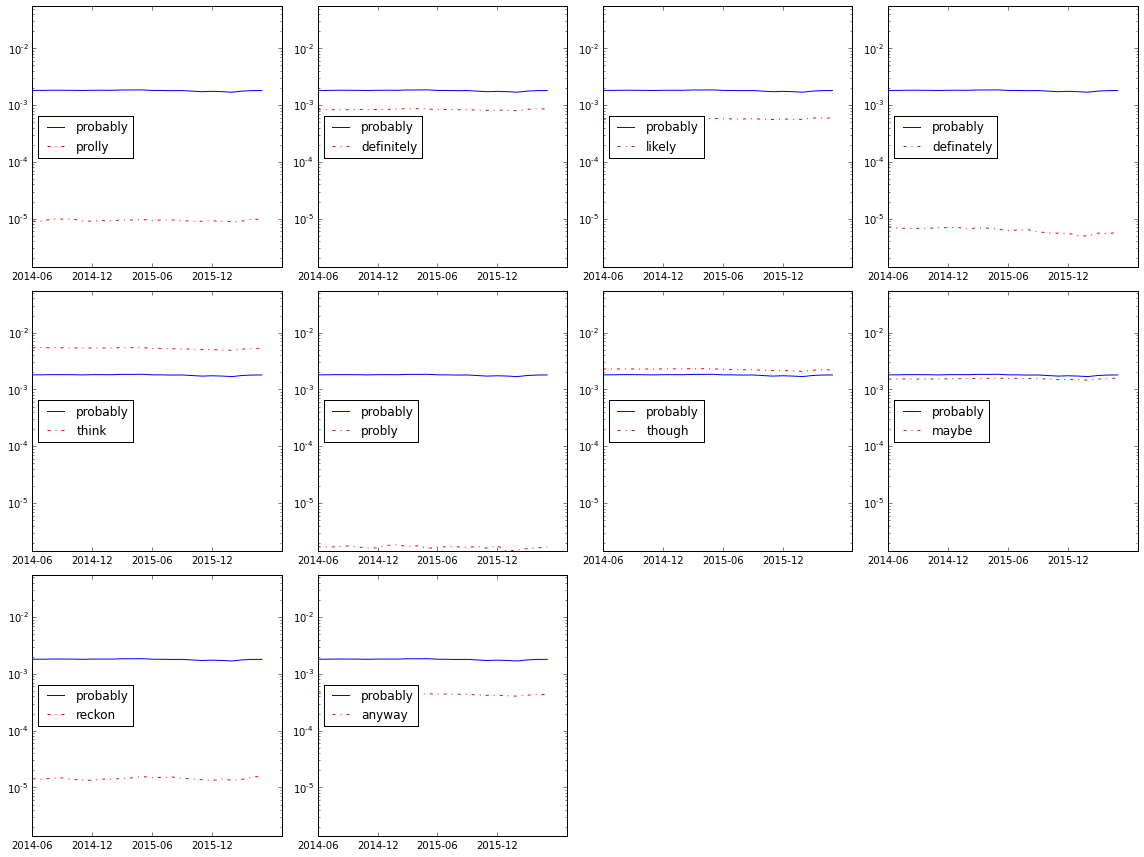

2015-08 has neighbors prolly,probaby,definitely,maybe,probly,think,though,anyway,likely,probobly


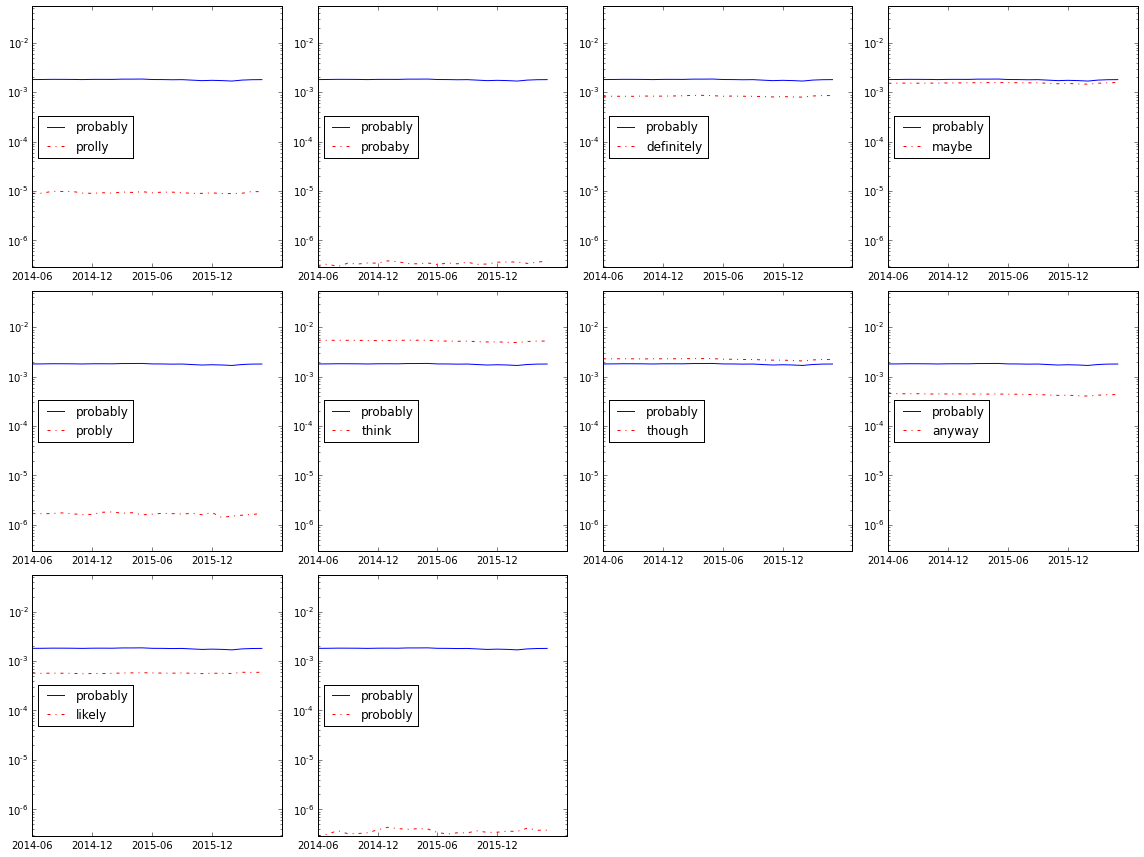

2015-09 has neighbors probly,prolly,definitely,probaby,maybe,reckon,likely,probabaly,though,think


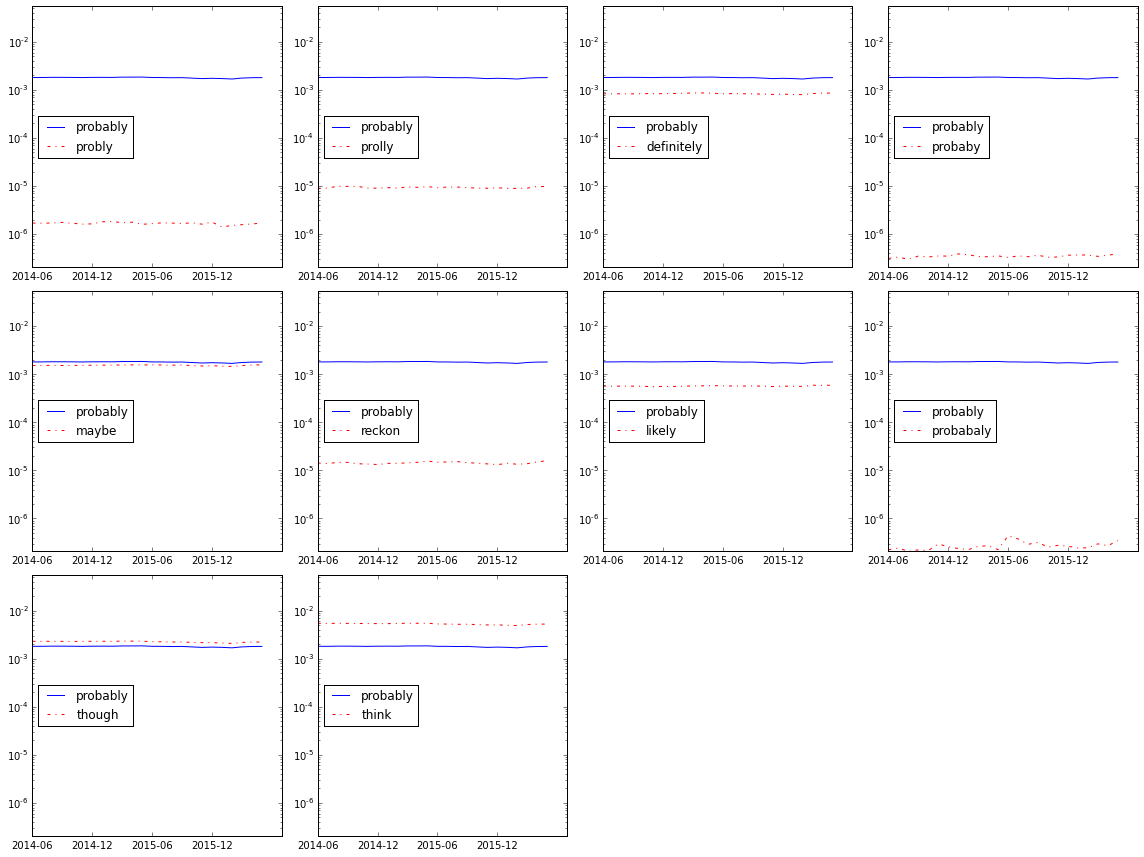

2015-10 has neighbors prolly,definitely,maybe,anyway,though,think,likely,probly,bet,reckon


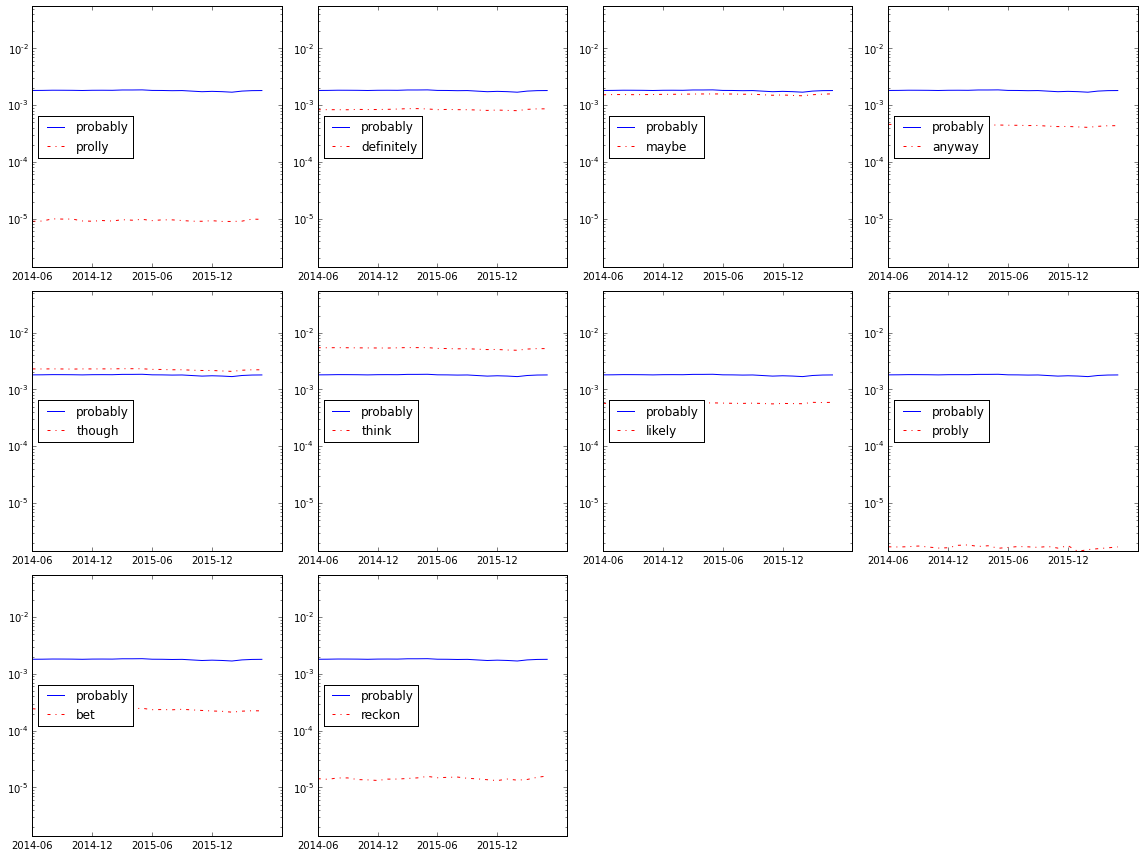

2015-11 has neighbors maybe,definitely,prolly,though,likely,anyway,think,guess,reckon,anyways


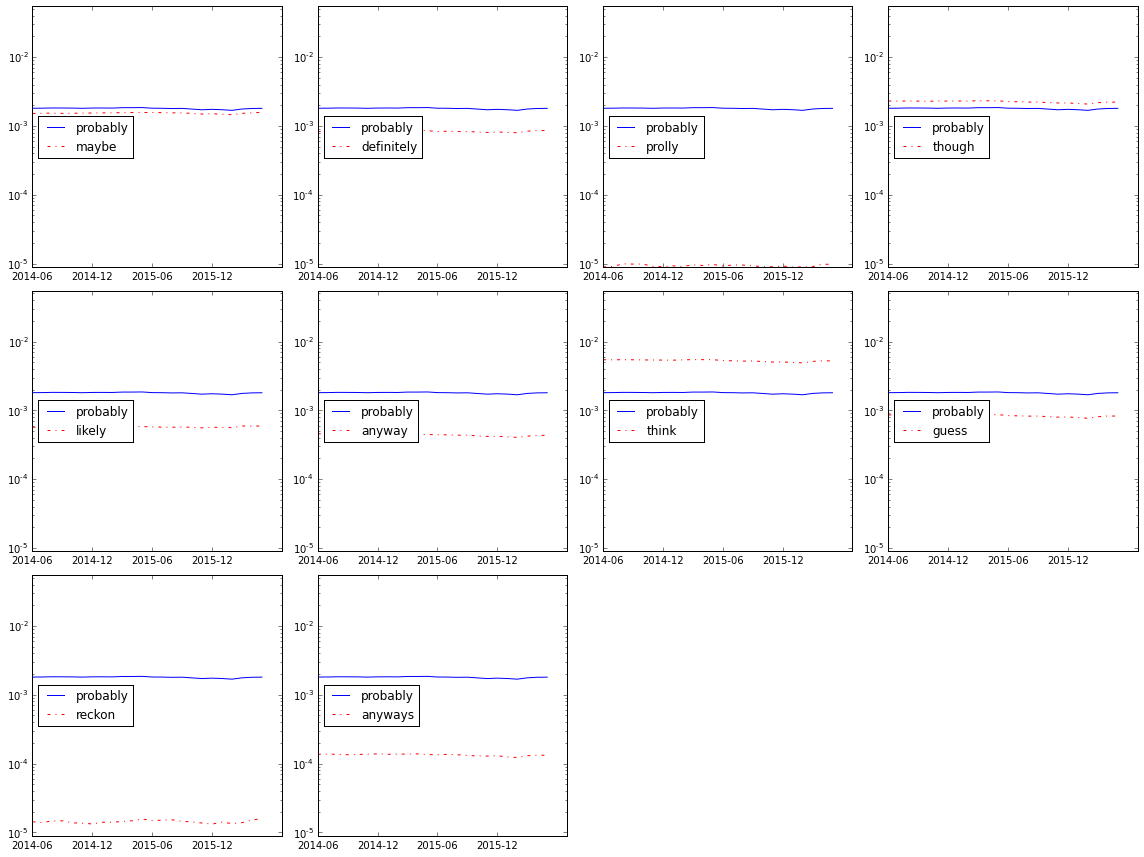

2015-12 has neighbors definitely,prolly,maybe,think,bet,though,likely,anyway,probly,reckon


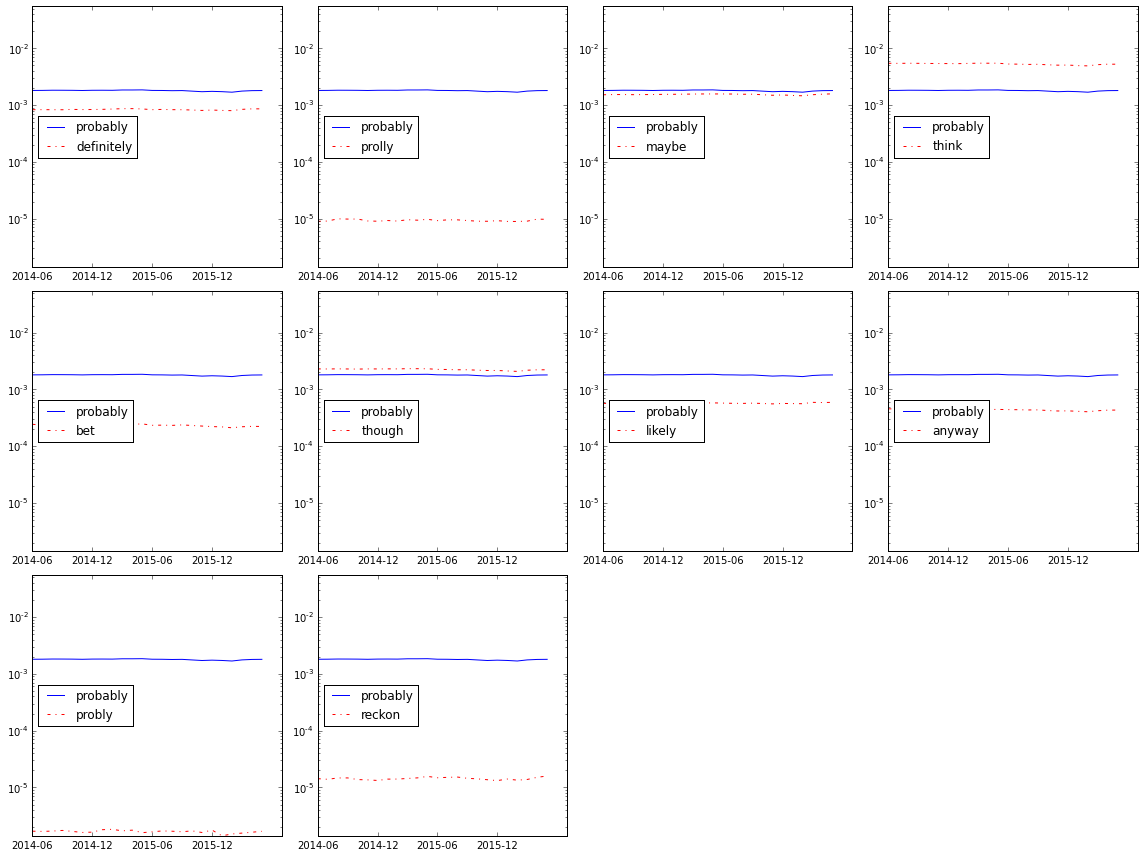

2016-01 has neighbors still,definitely,probaby,proably,also,defintely,definately,probabaly,actually,defiantly


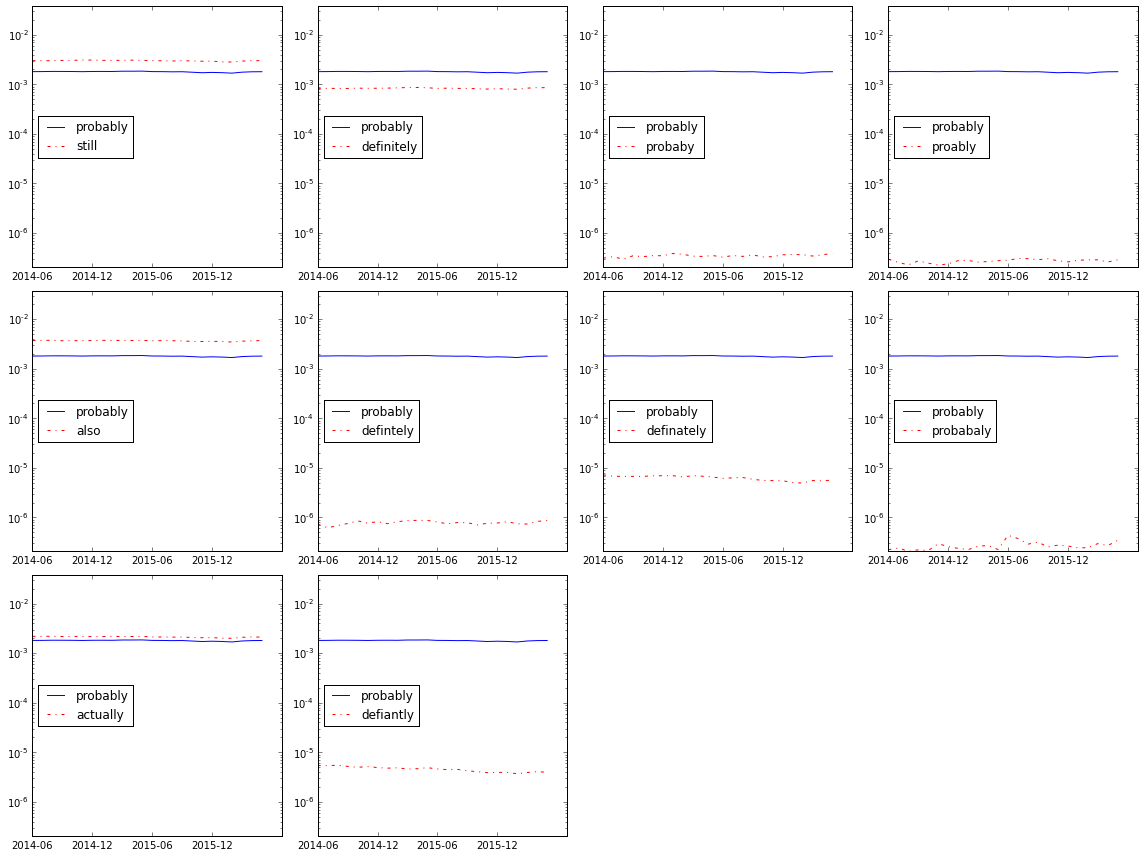

2016-02 has neighbors definitely,think,prolly,though,maybe,reckon,anyway,definately,guess,likely


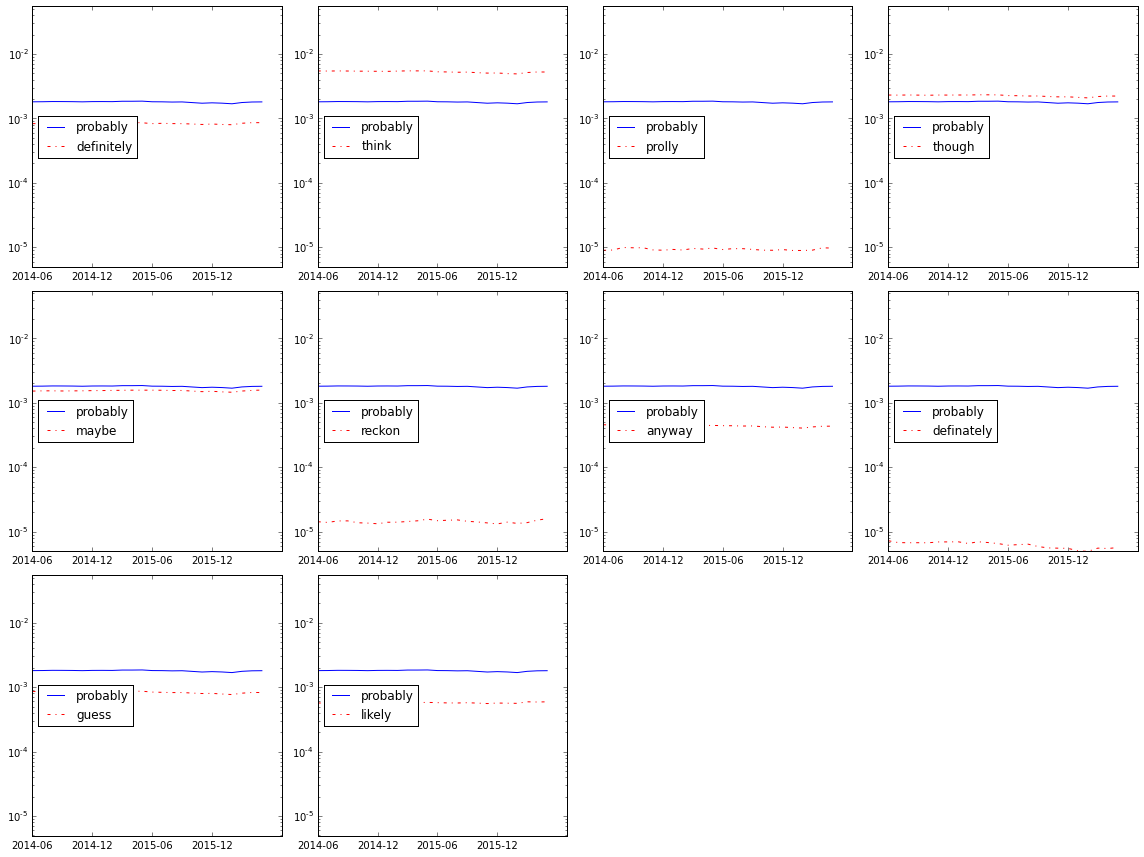

2016-03 has neighbors definitely,prolly,maybe,think,though,probly,likely,probaby,bet,guess


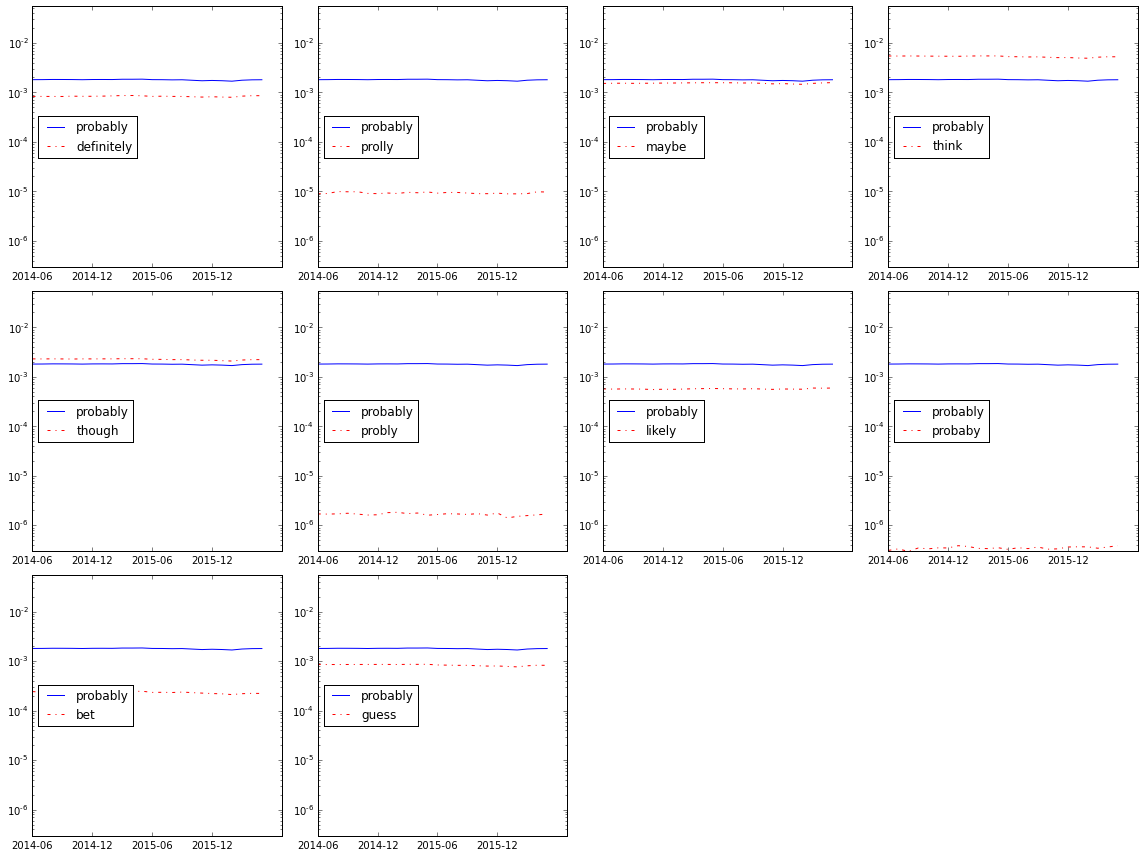

2016-04 has neighbors prolly,probaby,definitely,maybe,probabaly,probly,reckon,though,prooobably,likely


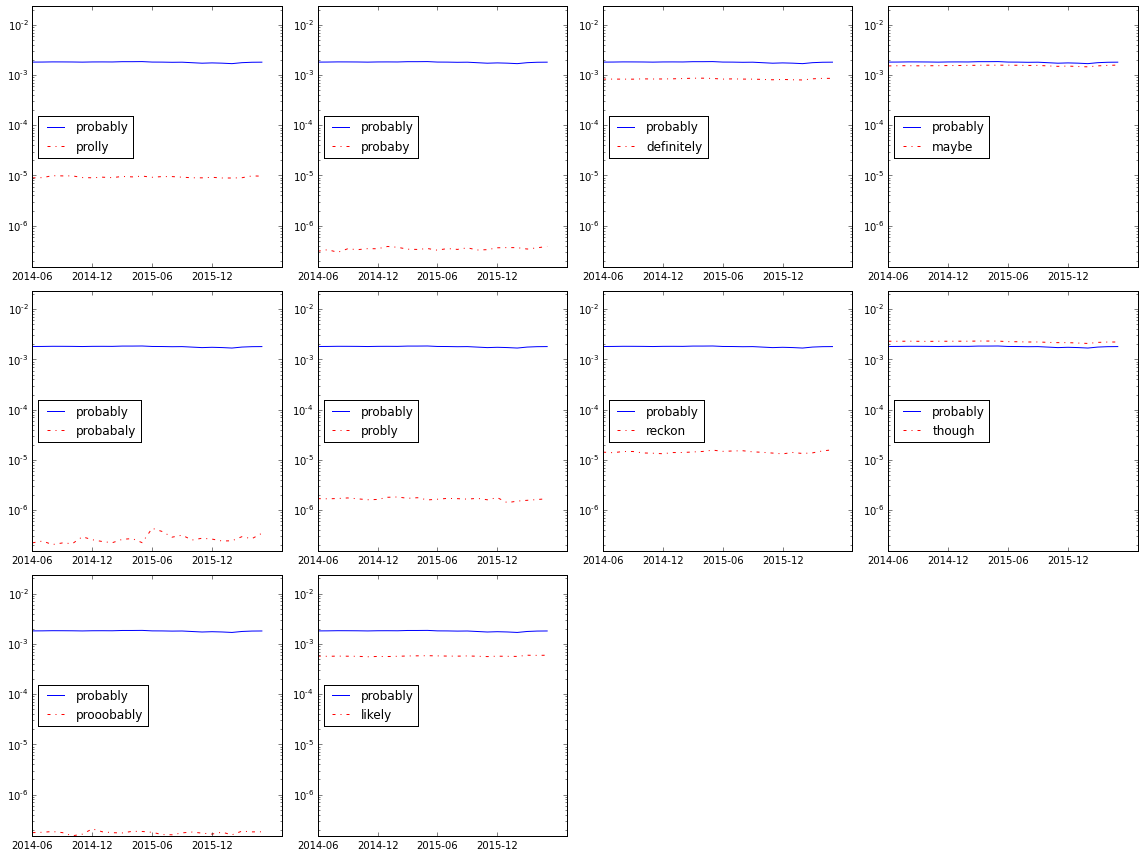

2016-05 has neighbors prolly,probly,maybe,definitely,probaby,proably,though,definately,likely,think


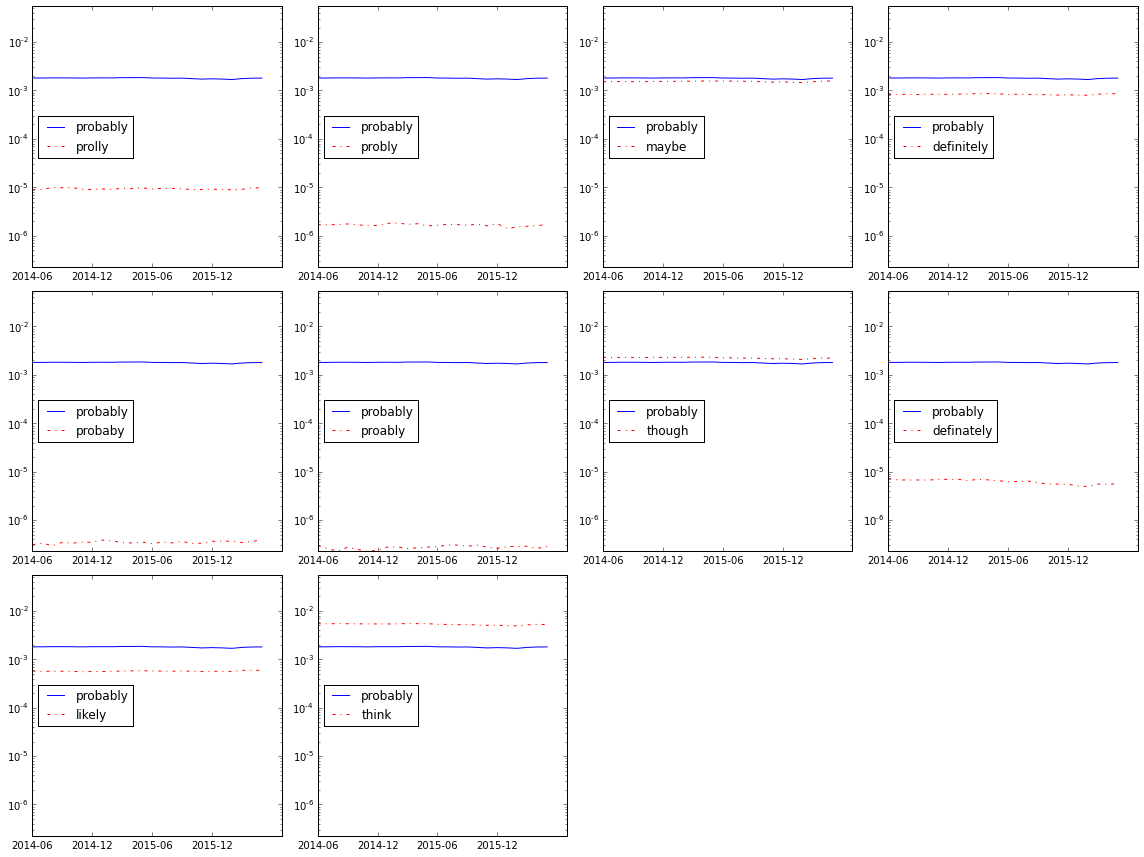

In [112]:
w = 'probably'
top_k = 10
embedding_type = 'word2vec'
for d in all_dates:
    embeddings = Word2Vec.load_word2vec_format('../../data/embeddings/%s_%s_100_5_embeddings'%(d, embedding_type), 
                                               binary=True)
    neighbor_sim_pairs = embeddings.most_similar(w, topn=top_k*2)
    neighbor_sim_pairs = [(n,s) for n,s in neighbor_sim_pairs if n in tf_2014_2016.index][:top_k]
    neighbors, neighbor_sims = zip(*neighbor_sim_pairs)
    neighbors = list(neighbors)
    print('%s has neighbors %s'%(d, ','.join(neighbors)))
    plot_word_neighbors(w, neighbors, tf_2014_2016)

## Compare 2014-2016 and 2015-2016

In [43]:
all_etas_diff = all_etas_2014_2016 - all_etas_2015_2016
all_etas_diff = all_etas_diff[all_etas_2015_2016.columns]
for k in k_range:
    print(all_etas_diff[k].sort_values(inplace=False, ascending=False))

usa               0.000279
benis             0.000214
ghana             0.000198
www               0.000179
dogecoin          0.000158
vitality          0.000148
cup               0.000146
portugal          0.000133
added             0.000132
merle             0.000127
brazil            0.000126
soccer            0.000123
spurs             0.000117
suarez            0.000117
fromage           0.000117
kari              0.000116
uruguay           0.000106
costa             0.000106
rica              0.000106
oberyn            0.000105
doge              0.000104
dexterity         0.000099
shibe             0.000098
lmq               0.000096
luvdisc           0.000095
wildstar          0.000094
mojang            0.000093
wc                0.000093
spain             0.000092
ooc               0.000092
elsa              0.000092
football          0.000091
moon              0.000091
know              0.000090
algeria           0.000090
england           0.000089
ochoa             0.000089
t

KeyError: 7

Positive value => more associated with early 2014 (2014-2016) OR more associated with late 2016 (2015-2016).

Negative value => more associated with early 2015 (2015-2016) OR more associated with late 2016 (2014-2016).

## Normalize by comment counts??
Divide raw counts by total number of comments per timestep to account for growing number of comments over time.

In [315]:
comment_counts_2015_2016 = pd.read_csv('../../data/frequency/2015_2016_comment_totals.tsv', sep='\t', index_col=0)
scaler = comment_counts_2015_2016.mean()
tf_2015_2016_normed = tf_2015_2016_raw / comment_counts_2015_2016.ix['total'] * scaler
print(tf_2015_2016_normed.head())

        2015-06    2015-07    2015-08    2015-09    2015-10    2015-11  \
just  8032405.0  8606733.0  8467288.0  8067936.0  8630239.0  8242711.0   
like  7540114.0  8103239.0  8023752.0  7617562.0  8071260.0  7735257.0   
can   5954297.0  6432149.0  6358353.0  6008836.0  6382635.0  6105517.0   
get   5117251.0  5533346.0  5472933.0  5256947.0  5640544.0  5341576.0   
one   5111341.0  5474341.0  5419511.0  5160197.0  5479751.0  5283848.0   

        2015-12    2016-01    2016-02    2016-03    2016-04    2016-05  
just  8546557.0  8967152.0  8624148.0  9348403.0  9366215.0  9511877.0  
like  8058139.0  8524702.0  8189008.0  8854890.0  8825818.0  8952361.0  
can   6349665.0  6791866.0  6553764.0  7033689.0  6971655.0  7082398.0  
get   5558060.0  5890954.0  5771330.0  6093615.0  6075660.0  6091460.0  
one   5503359.0  5840679.0  5660618.0  5960037.0  5909053.0  5988989.0  


In [316]:
etas_2015_2016_normed = get_etas(tf_2015_2016, tf_2015_2016_normed)

In [309]:
etas_2015_2016_normed.head()

1             2             3             4             5  \
just  1.497370e-06  1.496323e-06  1.497961e-06  1.496988e-06  1.493365e-06   
like  1.407233e-06  1.407094e-06  1.411412e-06  1.412788e-06  1.411135e-06   
can   1.106260e-06  1.105228e-06  1.110481e-06  1.114654e-06  1.114153e-06   
get   9.471352e-07  9.528618e-07  9.576036e-07  9.654086e-07  9.643176e-07   
one   9.303321e-07  9.307132e-07  9.354523e-07  9.438919e-07  9.455074e-07   

                 6  
just  1.493480e-06  
like  1.410409e-06  
can   1.112042e-06  
get   9.636603e-07  
one   9.463649e-07

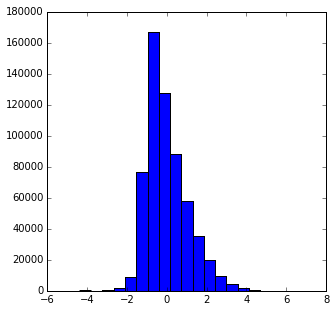

In [317]:
plt.figure(figsize=(5,5))
plt.hist(etas_2015_2016_normed.values.flatten(), bins=20)
plt.show()

In [318]:
k_range = sorted(etas_2015_2016_normed.columns)
for k in k_range:
    all_etas_k = etas_2015_2016_normed[k].sort_values(inplace=False, ascending=False)
    print(len(all_etas_k[all_etas_k > 0.]))
    print(len(all_etas_k[all_etas_k < 0.]))
    print(all_etas_k)

42101
57899
stellaris          5.476118
just               5.359715
like               5.326548
trump              5.314529
roadhog            5.238270
can                5.194941
removed            5.171036
get                5.109576
undertale          5.107869
one                5.093574
people             5.033669
will               5.011478
think              4.981119
really             4.882884
time               4.878848
good               4.872079
know               4.829240
even               4.812889
also               4.791822
much               4.757541
now                4.734032
see                4.710045
make               4.704229
well               4.691721
want               4.680949
way                4.671495
still              4.668741
go                 4.665372
game               4.645683
going              4.635298
right              4.588843
cydney             4.584720
got                4.583322
hillary            4.559946
something          4.559303
need    

In [319]:
test_growth_words = ['af', 'cringy', 'doggo', 'cummies', 'lmao', 'rn', 'tbh', 
                     'kys', 'cuck', 'memery', 'shitpost', 'yas', 'ngl',
                     'waddup', 'rando', 'clickbaity', 'fuckery', 'lit',
                     'edgy', 'triggered']
print(etas_2015_2016_normed.loc[test_growth_words])

                   1         2         3         4         5         6
af          2.573552  2.528847  2.454803  2.384096  2.339221  2.315528
cringy      1.285863  1.271258  1.215732  1.138649  1.091125  1.073287
doggo       2.924852  2.207944  1.783758  1.372299  1.126950  0.892414
cummies     2.152687  1.781342  1.261883  1.031668  1.119889  0.896903
lmao        3.033245  2.983218  2.917380  2.854937  2.819319  2.806675
rn          1.913945  1.871000  1.792127  1.718188  1.667697  1.640173
tbh         3.019915  2.996517  2.934883  2.865950  2.821954  2.808758
kys         1.628545  1.716699  1.546832  1.334694  1.151252  1.013612
cuck        3.414007  3.227306  3.061849  2.860668  2.653875  2.517244
memery      0.061262 -0.048557 -0.160818 -0.320221 -0.421815 -0.488843
shitpost    2.305868  2.532239  2.367481  2.237112  2.163619  2.133463
yas         0.863216  0.858344  0.805039  0.734895  0.653079  0.661280
ngl         0.510463  0.459414  0.358863  0.272031  0.250036  0.202081
waddup

Sanity check done! Most of the values are positive and above 1.00, indicating that they are significantly associated with the later time period.

In [346]:
cutoff = 1.5
k = 1
print(k)
etas_2015_2016_cutoff = etas_2015_2016_normed[k][etas_2015_2016_normed[k] >= cutoff]
print(len(etas_2015_2016_cutoff))
etas_2015_2016_cutoff_non_english = set(etas_2015_2016_cutoff.index) - set(english) - set(known_growth_words)
print(len(etas_2015_2016_cutoff_non_english))
print(', '.join(sorted(etas_2015_2016_cutoff_non_english)))

1
9631
1300
aa, aaa, abedin, acc, adc, adcs, adhd, afaik, afk, aggro, agl, agrias, ahh, ahhh, aint, airbnb, airguitar, aj, ak, aka, akechi, alani, aldrich, aldritch, alex, alie, allanon, alli, allo, alot, alphys, amara, ambra, amd, amsp, anakin, andy, anime, anor, anri, aoe, aos, ap, api, apos, apps, aqours, ar, archdragon, arde, arent, arkadia, arya, asriel, assholes, astora, astralis, asus, aswell, atk, atleast, atletico, att, atx, au, aubry, auch, aug, aus, automatron, av, avani, avery, aww, awww, azir, b, ba, backstory, badass, bam, barriss, barry, basetao, bastardbowl, battleborn, bautista, bayern, baylor, bbc, bbq, bc, bdo, behaviour, bella, bellamy, benghazi, benjen, bern, berrios, bf, bi, biden, bigscreen, biofrost, bisping, bitcoin, biyombo, blake, blizz, blm, blog, blogs, bloodborne, bloodraven, bloodrazor, bloodthorn, blorg, bluetooth, blumenthal, bm, boaty, boban, bolly, bonino, boogeymonster, bp, bradberry, brady, brandon, brann, brexit, briles, broly, bruh, bs, bssb, btc,

Non-English (unknown) growth words:

k = 1

[aaand, acc, addon, addons, admins, afaik, aggro, aghs, ahh, ahhh, aint, aka, ala, alot, alts, apps, arent, asshat, assholes, aswell, aww, awww, ayy, ayyy, badass, bae, batshit, bbq, bc, bdsm, behaviour, belive, bf, bi, biz, blog, blogs, booo, botting, brah, brb, brits, bruh, btw, butthole, butthurt, camo, captcha, carb, carbs, cardio, cellphone, certs, choo, circlejerk, cis, clickbait, clunky, clusterfuck, commenter, commenters, config, congrats, cooldown, cooldowns, copypasta, cosplay, couldnt, crits, cuz, dae, dammit, dat, dawg, def, definately, derp, dev, devs, dickbutt, dickhead, didnt, diff, dipshit, distro, div, doesnt, doin, douchebag, downvote, downvoted, downvotes, downvoting, doxing, duh, dui, dumbass, dumpster, dunno, eachother, eg, ehh, ehhh, everytime, ew, eww, exp, fanbase, fanboy, fanboys, fanfic, fap, faq, fav, fave, favourite, favourites, fest, fracking, freakin, friggin, ftfy, ftw, ftwd, fucker, fuckers, fuckin, fullscreen, fuuuck, fw, fx, fyi, gameplay, gamertag, gank, ganked, ganking, ganks, gawd, geez, gettin, gf, gimme, goddammit, goin, gonna, googled, googling, gooo, gotcha, gotta, grats, gtfo, gunna, haha, hahah, hahaha, hahahah, hahahaha, hahahahaha, hai, happend, hashtag, hasnt, havent, heh, hehe, het, hm, hmm, hmmm, hoh, homophobic, horseshit, hurr, iirc, imho, imma, immersive, imo, , indie, indy, ingame, irl, islamists, isnt, ive, jk, jungler, junglers, kinda, kk, kool, laggy, laning, lategame, lemme, lgbt, lil, lookin, looong, lvl, mah, malware, matchup, matchups, maxed, med, meds, megathread, meh, merc, merch, messaged, meth, mfw, mm, mmm, mmo, mmos, modded, modding, modmail, motherfucker, motherfuckers, motherfucking, muh, multiplayer, multiverse, naw, neckbeard, necro, neighbour, neighbourhood, neighbours, neoliberal, nerdy, nerf, nerfed, nerfing, nerfs, nevermind, newbee, newbie, newbies, nigga, noice, noob, noobs, noone, nooo, nsfw, nvm, ofcourse, offseason, ohh, ohhh, omfg, omg, oooh, op, org, organisation, organised, outta, overclock, overclocked, overclocking, pedo, photoshop, photoshopped, pissy, playerbase, playlist, playlists, playstyle, playthrough, pleb, pls, plugin, plugins, plz, pming, pms, podcast, podcasts, poo, pos, pov, preds, premade, preorder, prob, procs, prolly, promo, promos, punchline, pvp, realised, recognise, redditquette, redditor, redditors, reee, rehab, rekt, remaster, remastered, repost, reposted, reposting, reposts, respawn, rewatch, rly, roastee, rofl, roleplay, rpg, rpgs, sayin, scammed, scammers, scanlan, schwifty, screenshot, scumbag, selfie, selfies, seperate, sheesh, shh, shhh, shite, shit, shithole, shitload, shitter, shittier, shittiest, shitty, shotgunners, shoulda, shouldnt, shoutout, shrooms, sjw, sjws, skincare, smartphone, smartphones, sms, snarky, someones, somethings, soo, sooo, sorta, spammed, spamming, srs, sry, startup, stfu, strat, strats, subreddit, subreddits, suprised, synth, synths, tanky, tdee, teamfight, teamfights, techs, teh, texted, texting, tf, themed, theyre, thier, thingy, thx, tifu, timeframe, tldr, todo, trans, transgendered, ty, u, uhh, uhhh, ulti, ults, um, umm, ummm, undead, underwhelming, unranked, unsubscribe, updoot, upfront, upvote, upvoted, upvotes, upvoting, ur, vape, vaping, veg, veggie, veggies, vibe, vid, videogames, vids, waaay, waifu, wanna, wannabe, wasnt, wat, wayyy, werent, wew, wich, wifi, winger, woah, wooo, workaround, workforce, workplace, wot, woulda, wouldnt, wtf, wut, xd, xp, xyz, ya, yada, yah, yall, yeh, yesss, yo, yolo, youd, youll, youre, youve, yum]

In [352]:
# write words to file
sage_2015_2016_1_words = ['aaand', 'acc', 'addon', 'addons', 'admins', 'afaik', 'aggro', 'aghs', 'ahh', 'ahhh', 'aint', 'aka', 'ala', 'alot', 'alts', 'apps', 'arent', 'asshat', 'assholes', 'aswell', 'aww', 'awww', 'ayy', 'ayyy', 'badass', 'bae', 'batshit', 'bbq', 'bc', 'bdsm', 'behaviour', 'belive', 'bf', 'bi', 'biz', 'blog', 'blogs', 'boing', 'booo', 'botting', 'brah', 'brb', 'brits', 'bruh', 'btw', 'butthole', 'butthurt', 'camo', 'captcha', 'carb', 'carbs', 'cardio', 'cellphone', 'certs', 'choo', 'circlejerk', 'cis', 'clickbait', 'clunky', 'clusterfuck', 'commenter', 'commenters', 'config', 'congrats', 'cooldown', 'cooldowns', 'copypasta', 'cosplay', 'couldnt', 'crits', 'cuz', 'dae', 'dammit', 'dat', 'dawg', 'def', 'definately', 'derp', 'dev', 'devs', 'dickbutt', 'dickhead', 'didnt', 'diff', 'dipshit', 'distro', 'div', 'doesnt', 'doin', 'douchebag', 'downvote', 'downvoted', 'downvotes', 'downvoting', 'doxing', 'duh', 'dui', 'dumbass', 'dumpster', 'dunno', 'eachother', 'eg', 'ehh', 'ehhh', 'everytime', 'ew', 'eww', 'exp', 'fanbase', 'fanboy', 'fanboys', 'fanfic', 'fap', 'faq', 'fav', 'fave', 'favourite', 'favourites', 'fest', 'fracking', 'freakin', 'friggin', 'ftfy', 'ftw', 'ftwd', 'fucker', 'fuckers', 'fuckin', 'fullscreen', 'fuuuck', 'fw', 'fx', 'fyi', 'gameplay', 'gamertag', 'gank', 'ganked', 'ganking', 'ganks', 'gawd', 'geez', 'gettin', 'gf', 'gimme', 'goddammit', 'goin', 'gonna', 'googled', 'googling', 'gooo', 'gotcha', 'gotta', 'grats', 'gtfo', 'gunna', 'haha', 'hahah', 'hahaha', 'hahahah', 'hahahaha', 'hahahahaha', 'hai', 'happend', 'hashtag', 'hasnt', 'havent', 'heh', 'hehe', 'het', 'hm', 'hmm', 'hmmm', 'hoh', 'homophobic', 'horseshit', 'hurr', 'iirc', 'imho', 'imma', 'immersive', 'imo', '', 'indie', 'indy', 'ingame', 'irl', 'islamists', 'isnt', 'ive', 'jk', 'jungler', 'junglers', 'kinda', 'kk', 'kool', 'laggy', 'laning', 'lategame', 'lemme', 'lgbt', 'lil', 'lookin', 'looong', 'lvl', 'mah', 'malware', 'matchup', 'matchups', 'maxed', 'med', 'meds', 'megathread', 'meh', 'merc', 'merch', 'messaged', 'meth', 'mfw', 'mm', 'mmm', 'mmo', 'mmos', 'modded', 'modding', 'modmail', 'motherfucker', 'motherfuckers', 'motherfucking', 'muh', 'multiplayer', 'multiverse', 'naw', 'neckbeard', 'necro', 'neighbour', 'neighbourhood', 'neighbours', 'neoliberal', 'nerdy', 'nerf', 'nerfed', 'nerfing', 'nerfs', 'nevermind', 'newbee', 'newbie', 'newbies', 'nigga', 'noice', 'noob', 'noobs', 'noone', 'nooo', 'nsfw', 'nvm', 'ofcourse', 'offseason', 'ohh', 'ohhh', 'omfg', 'omg', 'oooh', 'op', 'org', 'organisation', 'organised', 'outta', 'overclock', 'overclocked', 'overclocking', 'pedo', 'photoshop', 'photoshopped', 'pissy', 'playerbase', 'playlist', 'playlists', 'playstyle', 'playthrough', 'pleb', 'pls', 'plugin', 'plugins', 'plz', 'pming', 'pms', 'podcast', 'podcasts', 'poo', 'pos', 'pov', 'preds', 'premade', 'preorder', 'prob', 'procs', 'prolly', 'promo', 'promos', 'punchline', 'pvp', 'realised', 'recognise', 'redditquette', 'redditor', 'redditors', 'reee', 'rehab', 'rekt', 'remaster', 'remastered', 'repost', 'reposted', 'reposting', 'reposts', 'respawn', 'rewatch', 'rly', 'roastee', 'rofl', 'roleplay', 'rpg', 'rpgs', 'sayin', 'scammed', 'scammers', 'scanlan', 'schwifty', 'screenshot', 'scumbag', 'selfie', 'selfies', 'seperate', 'sheesh', 'shh', 'shhh', 'shite', 'shit', 'shithole', 'shitload', 'shitter', 'shittier', 'shittiest', 'shitty', 'shotgunners', 'shoulda', 'shouldnt', 'shoutout', 'shrooms', 'sjw', 'sjws', 'skincare', 'smartphone', 'smartphones', 'sms', 'snarky', 'someones', 'somethings', 'soo', 'sooo', 'sorta', 'spammed', 'spamming', 'srs', 'sry', 'startup', 'stfu', 'strat', 'strats', 'subreddit', 'subreddits', 'suprised', 'synth', 'synths', 'tanky', 'tdee', 'teamfight', 'teamfights', 'techs', 'teh', 'texted', 'texting', 'tf', 'themed', 'theyre', 'thier', 'thingy', 'thx', 'tifu', 'timeframe', 'tldr', 'todo', 'trans', 'transgendered', 'ty', 'u', 'uhh', 'uhhh', 'ulti', 'ults', 'um', 'umm', 'ummm', 'undead', 'underwhelming', 'unranked', 'unsubscribe', 'updoot', 'upfront', 'upvote', 'upvoted', 'upvotes', 'upvoting', 'ur', 'vape', 'vaping', 'veg', 'veggie', 'veggies', 'vibe', 'vid', 'videogames', 'vids', 'waaay', 'waifu', 'wanna', 'wannabe', 'wasnt', 'wat', 'wayyy', 'werent', 'wew', 'wich', 'wifi', 'winger', 'woah', 'wooo', 'workaround', 'workforce', 'workplace', 'wot', 'woulda', 'wouldnt', 'wtf', 'wut', 'xd', 'xp', 'xyz', 'ya', 'yada', 'yah', 'yall', 'yeh', 'yesss', 'yo', 'yolo', 'youd', 'youll', 'youre', 'youve', 'yum', 'ded', 'doot', 'ech', 'fleeb', 'gud', 'im', 'infront', 'legendaries', 'loadout', 'mixtape', 'moba', 'mobas', 'noot', 'oc', 'ooc', 'perma', 'vr', 'yer']
sage_2015_2016_1_words += set(etas_2015_2016_cutoff.index) & set(known_growth_words)
print(len(sage_2015_2016_1_words))
sage_2015_2016_1 = pd.DataFrame({'category' : 'misc', 'words' : ['/'.join(sorted(sage_2015_2016_1_words))]})
sage_2015_2016_1.to_csv('../../data/frequency/growth_words/2015_2016_SAGE_k1.csv', index=False)

1560


In [353]:
def update_banned_words(new_words):
    banned_words_file = '../../data/frequency/growth_words/growth_words_banned.csv'
    banned_words_df = pd.read_csv(banned_words_file, index_col=None)
    old_banned_words = set(banned_words_df['words'][0].split('/'))
    new_banned_words = set(new_words) | old_banned_words
    banned_words_df.ix[0, 'words'] = '/'.join(sorted(new_banned_words))
    return new_banned_words

In [356]:
new_banned_words = set(etas_2015_2016_cutoff_non_english) - set(sage_2015_2016_1_words)
print(len(update_banned_words(new_banned_words)))

7077


In [357]:
pd.set_option('display.float_format', lambda x: '%.3E'%(x))
ws = ['snarky', 'yada', 'yolo', 'yeh', 'yah']
for w in ws:
    print(etas_2015_2016_normed.loc[w])
    print(tf_2015_2016.loc[w])
    print(tf_2015_2016_raw_normed.loc[w])

1   1.382E+00
2   1.384E+00
3   1.348E+00
4   1.317E+00
5   1.314E+00
6   1.323E+00
Name: snarky, dtype: float64
2015-06   9.834E-06
2015-07   9.861E-06
2015-08   9.571E-06
2015-09   9.344E-06
2015-10   9.156E-06
2015-11   9.005E-06
2015-12   8.919E-06
2016-01   9.073E-06
2016-02   8.931E-06
2016-03   8.815E-06
2016-04   9.300E-06
2016-05   9.297E-06
Name: snarky, dtype: float64
2015-06   1.549E-04
2015-07   1.543E-04
2015-08   1.498E-04
2015-09   1.425E-04
2015-10   1.417E-04
2015-11   1.409E-04
2015-12   1.402E-04
2016-01   1.465E-04
2016-02   1.477E-04
2016-03   1.393E-04
2016-04   1.432E-04
2016-05   1.433E-04
Name: snarky, dtype: float64
1   1.070E+00
2   1.058E+00
3   1.032E+00
4   9.812E-01
5   9.701E-01
6   9.777E-01
Name: yada, dtype: float64
2015-06   5.130E-06
2015-07   5.291E-06
2015-08   5.007E-06
2015-09   4.942E-06
2015-10   5.056E-06
2015-11   4.668E-06
2015-12   4.704E-06
2016-01   4.845E-06
2016-02   4.535E-06
2016-03   4.915E-06
2016-04   5.072E-06
2016-05   5.131E-0

Sanity checks suggest that SAGE isn't picking up actual growth words, even when $k=6$. Should we increase the upper/lower bound for SAGE?

Or go back to raw counts and use the sum instead of mean. WHAT DO.

## Get SAGE with sums
Sum over late tf rather than taking mean.

In [358]:
def get_etas_sum(tf, tf_raw):
    vocab = tf.index
    k_lower = 1
    k_upper = int(tf.shape[1] / 2) + 1
    k_range = range(k_lower, k_upper)
    all_etas = {}
    for k in k_range:
        # use early as base rate against which to compare late
        tf_early = pd.np.array(pd.np.log10(tf.ix[:, 0:k].mean(axis=1)))
        tf_late = tf_raw.ix[:, -k:].sum(axis=1)
#         tf_late = pd.np.array(pd.np.log10(tf.ix[:, -k:].mean(axis=1)))
        etas = sage.estimate(tf_late, tf_early)
        etas = pd.Series(etas, index=vocab)
        all_etas[k] = etas
    all_etas = pd.DataFrame(all_etas)
    return all_etas

In [359]:
etas_2015_2016_sum = get_etas_sum(tf_2015_2016, tf_2015_2016_raw)
print(etas_2015_2016_sum.head())

             1         2         3         4         5         6
just 5.360E+00 5.361E+00 5.341E+00 5.290E+00 5.278E+00 5.290E+00
like 5.326E+00 5.328E+00 5.308E+00 5.259E+00 5.248E+00 5.261E+00
can  5.195E+00 5.194E+00 5.176E+00 5.129E+00 5.120E+00 5.131E+00
get  5.110E+00 5.116E+00 5.097E+00 5.053E+00 5.041E+00 5.053E+00
one  5.093E+00 5.096E+00 5.078E+00 5.036E+00 5.028E+00 5.041E+00


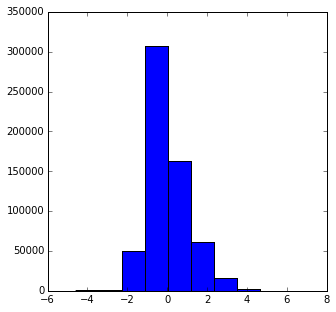

In [360]:
plt.figure(figsize=(5,5))
plt.hist(etas_2015_2016_sum.values.flatten())
plt.show()

In [361]:
for k in k_range:
    print(k)
    print(etas_2015_2016_sum[k].sort_values(inplace=False, ascending=False))

1
stellaris          5.478E+00
just               5.360E+00
like               5.326E+00
trump              5.314E+00
roadhog            5.236E+00
can                5.195E+00
removed            5.171E+00
get                5.110E+00
undertale          5.106E+00
one                5.093E+00
people             5.034E+00
will               5.011E+00
think              4.981E+00
really             4.883E+00
time               4.879E+00
good               4.872E+00
know               4.829E+00
even               4.813E+00
also               4.792E+00
much               4.757E+00
now                4.734E+00
see                4.710E+00
make               4.704E+00
well               4.692E+00
want               4.681E+00
way                4.671E+00
still              4.669E+00
go                 4.665E+00
game               4.646E+00
going              4.635E+00
right              4.589E+00
got                4.583E+00
cydney             4.575E+00
hillary            4.559E+00
something   

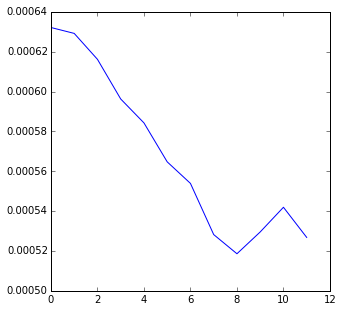

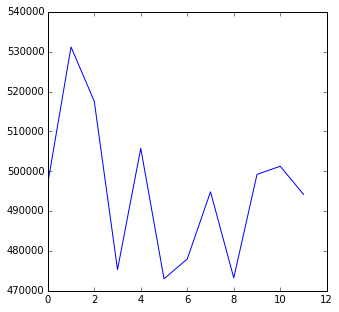

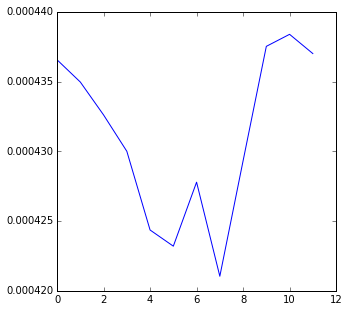

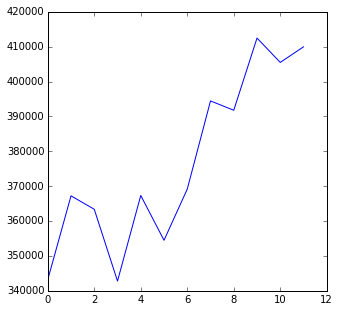

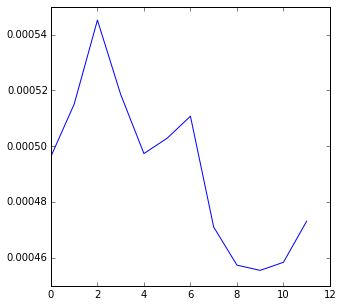

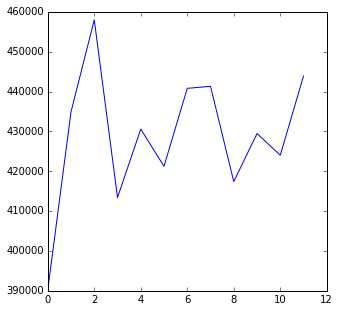

In [375]:
ws = ['awesome', 'important', 'op']
for w in ws:
    X = range(tf.shape[1])
    plt.figure(figsize=(5,5))
    plt.plot(X, tf_2015_2016.loc[w])
    plt.show()
    plt.figure(figsize=(5,5))
    plt.plot(X, tf_2015_2016_raw.loc[w])
    plt.show()

How does `awesome` have a high SAGE score??